#### NOVA IMS / BSc in Data Science / Text Mining 2024/2025
### <b>Group Project: "Solving the Hyderabadi Word Soup"</b>
#### Notebook `Project`

#### Group:
- `João Ferreira, 20221912`
- `Miguel Mendes, 20221904`
- `Rodrigo Maia, 20221934`
- `Maria Mendes 20211624`
- `Ricardo Coelho 20211633`

#### <font color='#BFD72'>Table of Contents </font> <a class="anchor" id='toc'></a> 
- [1. Data Understanding](#P1)
- [2. Data Exploration with visualizations](#P2) 
    - [2.1 BOW plot for the reviews](#P21)
    - [2.2 Word cloud of reviews](#P22)
    - [2.3 BOW treemap for the reviews](#P23)
    - [2.4 BOW plot for the cuisine types](#P24)
    - [2.5 Co-occurrence in `Cuisines` visualization](#P25)

- [3. Sentiment Analysis](#P3)
    - [3.1 Data Preprocessing](#P31)
    - [3.2 Model Implemetation - Vader](#P32)
    - [3.3 Model Evaluation - Vader](#P33)
    - [3.4 Model Implemetation - TextBlob](#P34)
    - [3.5 Model Evaluation - TextBlob](#P35)
    - [3.6 Model Evaluation - Vader vs TextBlob](#P36)
    - [3.7 Outliers analysis - good vader, bad rating and vice-versa](#P37)

- [4. Multilabel Classification](#P4)
    - [4.1 Specific Data Exploration](#P41)
    - [4.2 Data Preparation](#P42)
    - [4.3 Model Preparation](#P43)
    - [4.4 Random searches](#P44)
    - [4.5 OneVsRest LogisticRegression Model (best version from random search)](#P45)
    - [4.6 OneVsRest RandomForest Model (best version from random search)](#P46)
    - [4.7 ClassifierChain LogisticRegression Model (best version from random search)](#P47)
    - [4.8 ClassifierChain RandomForest Model (best version from random search)](#P48)
    - [4.9 Intermediate Conclusions (comparison between models)](#P49)
    - [4.10 Dummy Classifier (baseline model)](#P410)
    - [4.11 Final Conclusions (comparison of best model and baseline)](#P411)

- [5. Co-occurrence Analysis; Clustering](#P5)
    - [5.1 Data preparation and some data exploration](#P51)
    - [5.2 Dish co-ocorrence and analysis](#P52)
    - [5.3 Dish Clustering preprocessing](#P53)
    - [5.4 K-means number of clusters study](#P54)
    - [5.5 K-means](#P55)
    - [5.6 Optics](#P56)
    - [5.7 HDBSCAN](#P57)

- [6. Topic Modeling](#P6)
    - [6.1 Data preparation](#P61)
    - [6.2 Latent Semantic Analysis (LSA)](#P62)
    - [6.3 Latent Dirichlet Allocation (LDA)](#P63)
    - [6.4 BERTopic](#P64)
    - [6.5 Final Conclusions](#P65)

<i>## Note that the notebook structure differs from the report: instead of following the CRISP-DM phases and then specifying the different problems inside the phases, the notebook is structured by problem, with the CRISP-DM phases being defined for each specific problem.

In [1]:
%load_ext autoreload
%autoreload 2
#!pip install nltk==3.7
# basic libraries
import os
import pandas as pd
import numpy as np
from utils import pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from wordcloud import WordCloud
import re
import plotly.express as px
from tqdm import tqdm
from collections import Counter, defaultdict 

#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#nltk
import nltk
nltk.download("punkt")
from nltk.tokenize import PunktSentenceTokenizer
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

#textblob
from textblob import TextBlob

# multilabel classifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_array, check_is_fitted
from joblib import Parallel, delayed

# stats and metrics
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error,  mean_absolute_percentage_error
from scipy.stats import randint, uniform
from sklearn.metrics import f1_score, classification_report


# Clustering
from sklearn.cluster import KMeans, HDBSCAN, OPTICS
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA, TruncatedSVD
from itertools import product
from sklearn.manifold import TSNE

#Classification and Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#Topic Modelling
from sklearn.model_selection import GridSearchCV
from gensim.models import LsiModel, LdaModel
from bertopic import BERTopic
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import itertools
from gensim.corpora.dictionary import Dictionary


# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joaof\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\joaof\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<font color='#BFD72F' size=5>1. Data Understanding</font> <a class="anchor" id="P1"></a>
  
[Back to TOC](#toc)

In [2]:
reviews = pd.read_csv("data_hyderabad/10k_reviews.csv")
restaurants = pd.read_csv("data_hyderabad/105_restaurants.csv")

In [3]:
reviews

Restaurant              Reviewer  \
0      Beyond Flavours     Rusha Chakraborty   
1      Beyond Flavours  Anusha Tirumalaneedi   
2      Beyond Flavours       Ashok Shekhawat   
3      Beyond Flavours        Swapnil Sarkar   
4      Beyond Flavours                Dileep   
...                ...                   ...   
9995  Chinese Pavilion      Abhishek Mahajan   
9996  Chinese Pavilion        Sharad Agrawal   
9997  Chinese Pavilion             Ramandeep   
9998  Chinese Pavilion       Nayana Shanbhag   
9999  Chinese Pavilion      Bhargava Krishna   

                                                 Review Rating  \
0     The ambience was good, food was quite good . h...      5   
1     Ambience is too good for a pleasant evening. S...      5   
2     A must try.. great food great ambience. Thnx f...      5   
3     Soumen das and Arun was a great guy. Only beca...      5   
4     Food is good.we ordered Kodi drumsticks and ba...      5   
...                                                 ...    ...   
9995  Madhumathi Mahajan Well to start with nice cou...      3   
9996  This place has never disappointed us.. The foo...    4.5   
9997  Bad rating is mainly because of "Chicken Bone ...    1.5   
9998  I personally love and prefer Chinese Food. Had...      4   
9999  Checked in here to try some delicious chinese ...    3.5   

                          Metadata             Time  Pictures  
0           1 Review , 2 Followers  5/25/2019 15:54         0  
1          3 Reviews , 2 Followers  5/25/2019 14:20         0  
2          2 Reviews , 3 Followers  5/24/2019 22:54         0  
3            1 Review , 1 Follower  5/24/2019 22:11         0  
4          3 Reviews , 2 Followers  5/24/2019 21:37         0  
...                            ...              ...       ...  
9995     53 Reviews , 54 Followers    6/5/2016 0:08         0  
9996      2 Reviews , 53 Followers   6/4/2016 22:01         0  
9997    65 Reviews , 423 Followers   6/3/2016 10:37         3  
9998    13 Reviews , 144 Followers  5/31/2016 17:22         0  
9999  472 Reviews , 1302 Followers  5/31/2016 16:41         6  

[10000 rows x 7 columns]

In [4]:
print(reviews["Rating"].value_counts()) 
reviews[reviews["Rating"] == "Like"]

5       3832
4       2373
1       1735
3       1193
2        684
4.5       69
3.5       47
2.5       19
1.5        9
Like       1
Name: Rating, dtype: int64


Restaurant           Reviewer  \
7601  The Old Madras Baking Company  Dhanasekar Kannan   

                                                 Review Rating  \
7601  One of the best pizzas to try. It served with ...   Like   

                       Metadata             Time  Pictures  
7601  12 Reviews , 21 Followers  5/18/2019 12:31         1

In [5]:
reviews.describe(include = "all")

Restaurant     Reviewer Review Rating  Metadata             Time  \
count             10000         9962   9955   9962      9962             9962   
unique              100         7446   9364     10      2477             9782   
top     Beyond Flavours  Parijat Ray   good      5  1 Review  7/29/2018 20:34   
freq                100           13    237   3832       919                3   
mean                NaN          NaN    NaN    NaN       NaN              NaN   
std                 NaN          NaN    NaN    NaN       NaN              NaN   
min                 NaN          NaN    NaN    NaN       NaN              NaN   
25%                 NaN          NaN    NaN    NaN       NaN              NaN   
50%                 NaN          NaN    NaN    NaN       NaN              NaN   
75%                 NaN          NaN    NaN    NaN       NaN              NaN   
max                 NaN          NaN    NaN    NaN       NaN              NaN   

            Pictures  
count   10000.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean        0.748600  
std         2.570381  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max        64.000000

In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  10000 non-null  object
 1   Reviewer    9962 non-null   object
 2   Review      9955 non-null   object
 3   Rating      9962 non-null   object
 4   Metadata    9962 non-null   object
 5   Time        9962 non-null   object
 6   Pictures    10000 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 547.0+ KB


In [7]:
restaurants

Name  \
0                           Beyond Flavours   
1                                  Paradise   
2                                  Flechazo   
3            Shah Ghouse Hotel & Restaurant   
4                Over The Moon Brew Company   
..                                      ...   
100                               IndiBlaze   
101                            Sweet Basket   
102                        Angaara Counts 3   
103                             Wich Please   
104  Republic Of Noodles - Lemon Tree Hotel   

                                                 Links   Cost  \
0    https://www.zomato.com/hyderabad/beyond-flavou...    800   
1    https://www.zomato.com/hyderabad/paradise-gach...    800   
2    https://www.zomato.com/hyderabad/flechazo-gach...  1,300   
3    https://www.zomato.com/hyderabad/shah-ghouse-h...    800   
4    https://www.zomato.com/hyderabad/over-the-moon...  1,200   
..                                                 ...    ...   
100  https://www.zomato.com/hyderabad/indiblaze-gac...    600   
101  https://www.zomato.com/hyderabad/sweet-basket-...    200   
102  https://www.zomato.com/hyderabad/angaara-count...    500   
103  https://www.zomato.com/hyderabad/wich-please-1...    250   
104  https://www.zomato.com/hyderabad/republic-of-n...  1,700   

                                           Collections  \
0    Food Hygiene Rated Restaurants in Hyderabad, C...   
1                                  Hyderabad's Hottest   
2                   Great Buffets, Hyderabad's Hottest   
3                               Late Night Restaurants   
4    Best Bars & Pubs, Food Hygiene Rated Restauran...   
..                                                 ...   
100                                                NaN   
101                                                NaN   
102                                                NaN   
103                                                NaN   
104                               Pan-Asian Delicacies   

                                              Cuisines  \
0    Chinese, Continental, Kebab, European, South I...   
1                       Biryani, North Indian, Chinese   
2         Asian, Mediterranean, North Indian, Desserts   
3    Biryani, North Indian, Chinese, Seafood, Bever...   
4    Asian, Continental, North Indian, Chinese, Med...   
..                                                 ...   
100                                   Fast Food, Salad   
101                                     Bakery, Mithai   
102                     North Indian, Biryani, Chinese   
103                                          Fast Food   
104                    Thai, Asian, Chinese, Malaysian   

                                               Timings  
0        12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)  
1                                       11 AM to 11 PM  
2                11:30 AM to 4:30 PM, 6:30 PM to 11 PM  
3                                      12 Noon to 2 AM  
4    12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12no...  
..                                                 ...  
100                                     11 AM to 11 PM  
101  10 AM to 10 PM (Mon-Thu), 8 AM to 10:30 PM (Fr...  
102                                   12 Noon to 11 PM  
103                           8am to 12:30AM (Mon-Sun)  
104              11:30 AM to 3 PM, 7 PM to 12 Midnight  

[105 rows x 6 columns]

In [8]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         105 non-null    object
 1   Links        105 non-null    object
 2   Cost         105 non-null    object
 3   Collections  51 non-null     object
 4   Cuisines     105 non-null    object
 5   Timings      104 non-null    object
dtypes: object(6)
memory usage: 5.0+ KB


In [9]:
restaurants.describe(include="all")

Name                                              Links  \
count               105                                                105   
unique              105                                                105   
top     Beyond Flavours  https://www.zomato.com/hyderabad/beyond-flavou...   
freq                  1                                                  1   

       Cost                                  Collections  \
count   105                                           51   
unique   29                                           42   
top     500  Food Hygiene Rated Restaurants in Hyderabad   
freq     13                                            4   

                     Cuisines         Timings  
count                     105             104  
unique                     92              77  
top     North Indian, Chinese  11 AM to 11 PM  
freq                        4               6

In [3]:
# In this cell, we created a dictionary called dicti that maps restaurant names to their corresponding cuisines:
dicti = {}
for i in range(len(restaurants)):
    dicti[restaurants["Name"][i]] = restaurants["Cuisines"][i]

In [4]:
#Creates a new column on the reviews dataset with the cuisines respective to each restaurant
reviews["Cuisine"] = reviews["Restaurant"].map(dicti)

In [12]:
reviews

Restaurant              Reviewer  \
0      Beyond Flavours     Rusha Chakraborty   
1      Beyond Flavours  Anusha Tirumalaneedi   
2      Beyond Flavours       Ashok Shekhawat   
3      Beyond Flavours        Swapnil Sarkar   
4      Beyond Flavours                Dileep   
...                ...                   ...   
9995  Chinese Pavilion      Abhishek Mahajan   
9996  Chinese Pavilion        Sharad Agrawal   
9997  Chinese Pavilion             Ramandeep   
9998  Chinese Pavilion       Nayana Shanbhag   
9999  Chinese Pavilion      Bhargava Krishna   

                                                 Review Rating  \
0     The ambience was good, food was quite good . h...      5   
1     Ambience is too good for a pleasant evening. S...      5   
2     A must try.. great food great ambience. Thnx f...      5   
3     Soumen das and Arun was a great guy. Only beca...      5   
4     Food is good.we ordered Kodi drumsticks and ba...      5   
...                                                 ...    ...   
9995  Madhumathi Mahajan Well to start with nice cou...      3   
9996  This place has never disappointed us.. The foo...    4.5   
9997  Bad rating is mainly because of "Chicken Bone ...    1.5   
9998  I personally love and prefer Chinese Food. Had...      4   
9999  Checked in here to try some delicious chinese ...    3.5   

                          Metadata             Time  Pictures  \
0           1 Review , 2 Followers  5/25/2019 15:54         0   
1          3 Reviews , 2 Followers  5/25/2019 14:20         0   
2          2 Reviews , 3 Followers  5/24/2019 22:54         0   
3            1 Review , 1 Follower  5/24/2019 22:11         0   
4          3 Reviews , 2 Followers  5/24/2019 21:37         0   
...                            ...              ...       ...   
9995     53 Reviews , 54 Followers    6/5/2016 0:08         0   
9996      2 Reviews , 53 Followers   6/4/2016 22:01         0   
9997    65 Reviews , 423 Followers   6/3/2016 10:37         3   
9998    13 Reviews , 144 Followers  5/31/2016 17:22         0   
9999  472 Reviews , 1302 Followers  5/31/2016 16:41         6   

                                                Cuisine  
0     Chinese, Continental, Kebab, European, South I...  
1     Chinese, Continental, Kebab, European, South I...  
2     Chinese, Continental, Kebab, European, South I...  
3     Chinese, Continental, Kebab, European, South I...  
4     Chinese, Continental, Kebab, European, South I...  
...                                                 ...  
9995                                   Chinese, Seafood  
9996                                   Chinese, Seafood  
9997                                   Chinese, Seafood  
9998                                   Chinese, Seafood  
9999                                   Chinese, Seafood  

[10000 rows x 8 columns]

In [13]:
print(reviews["Review"].sample(12))

7477                                    No miyo was given
90      Lovely ambience..Roasted chicken soup was the ...
7769                                                 nice
3367    Rocking club....\nBut where is my Bro....DJ AS...
6233    taste was awesome but..... quantity was very less
212     Sabir excellent service panner verry good v ka...
500     One of the best restaurants visited till date ...
6319    this restaurant located in the same complex of...
6795                         price is too high on deserts
6141    Great place to party . Nice dance floor . Spac...
6270                     He came at right time and place.
5005    Definitely worth a try if you're looking for s...
Name: Review, dtype: object


In [14]:
print(reviews["Cuisine"].sample(12))

5859                          Desserts, Beverages
1077         Street Food, North Indian, Fast Food
8110                        North Indian, Chinese
4838          South Indian, North Indian, Chinese
5573                                 Cafe, Bakery
7509                   North Indian, South Indian
6555       North Indian, Chinese, Japanese, Sushi
3715    Andhra, Biryani, Hyderabadi, North Indian
7142             North Indian, Mughlai, Beverages
6298             North Indian, Chinese, Fast Food
4556       Chinese, Biryani, Andhra, North Indian
6925                    BBQ, Asian, Modern Indian
Name: Cuisine, dtype: object


From the initial data exploration we concluded:
- There are missing values in a lot of columns which should be dealt with accordingly to the tasks 
- We joined the cuisines from the `restaurants` to the `reviews` dataset so that we have the column `Cuisines` merged in only one dataset
- After taking samples of the `Review`, it is a string of words, numbers and emojis and some other signs and punctuation
- After taking samples of the `Cuisine`, it is a of types of cuisines separated by comas
- The column `Rating` has one value "Like" instead of being a number from 1 to 5 like all the others
- The columns `Restaurant` and `Name` from `reviews` and `restaurants` respectively consist in a string with the name of the restaurant
- The column `Metadata` consists of a string with the number of followers and numbers of reviews
- The column `Time` consists of a string with the time and date the review was made
- The column `Pictures` consists of an integer that is the number of fotos uploaded along with the review
- The column `Reviewer` consists of a string with the name of the person who wrote the review
- The column `Cost` consists of integers representing the estimate cost of dining in the restaurant
- The column `Link` consists of a string with the link corresponding to the restaurant in Zomato's website
- The column  `Collections` consists of a string with of which Zomato's collection the restaurant belongs to
- The column `Timings` consists of a string with the hours and days of the week the restaurant is open

<font color='#BFD72F' size=5>2. Data exploration with visualizations</font> <a class="anchor" id='#P2'></a>
  
[Back to TOC](#toc)


In [6]:
reviews_text_only = reviews.copy()
reviews_text_only.dropna(subset=['Review'], inplace= True) # remove all rows from the reviews DataFrame where the 'Review' column has missing (NaN) values:

# we are removing the columns that are irrelevant to the analysis:
reviews_text_only.drop(columns = ["Reviewer", "Time", "Pictures", "Metadata", "Rating"], inplace= True)

# We are creating two new columns one with the number of characters and the other with the number of sentences in each review
reviews_text_only["number_of characters"] = reviews_text_only["Review"].apply(lambda x: len(x))
reviews_text_only["numbers_of_sentences"] = reviews_text_only["Review"].apply(lambda x: len(x.split(".")))


reviews_text_only

Restaurant                                             Review  \
0      Beyond Flavours  The ambience was good, food was quite good . h...   
1      Beyond Flavours  Ambience is too good for a pleasant evening. S...   
2      Beyond Flavours  A must try.. great food great ambience. Thnx f...   
3      Beyond Flavours  Soumen das and Arun was a great guy. Only beca...   
4      Beyond Flavours  Food is good.we ordered Kodi drumsticks and ba...   
...                ...                                                ...   
9995  Chinese Pavilion  Madhumathi Mahajan Well to start with nice cou...   
9996  Chinese Pavilion  This place has never disappointed us.. The foo...   
9997  Chinese Pavilion  Bad rating is mainly because of "Chicken Bone ...   
9998  Chinese Pavilion  I personally love and prefer Chinese Food. Had...   
9999  Chinese Pavilion  Checked in here to try some delicious chinese ...   

                                                Cuisine  number_of characters  \
0     Chinese, Continental, Kebab, European, South I...                   222   
1     Chinese, Continental, Kebab, European, South I...                   144   
2     Chinese, Continental, Kebab, European, South I...                   189   
3     Chinese, Continental, Kebab, European, South I...                   148   
4     Chinese, Continental, Kebab, European, South I...                   160   
...                                                 ...                   ...   
9995                                   Chinese, Seafood                  1024   
9996                                   Chinese, Seafood                   320   
9997                                   Chinese, Seafood                  1555   
9998                                   Chinese, Seafood                   511   
9999                                   Chinese, Seafood                   517   

      numbers_of_sentences  
0                        6  
1                        5  
2                       13  
3                        3  
4                        8  
...                    ...  
9995                    12  
9996                     9  
9997                    11  
9998                     9  
9999                    12  

[9955 rows x 5 columns]

In [7]:
reviews_text_only.describe()

number_of characters  numbers_of_sentences
count           9955.000000           9955.000000
mean             279.774485              6.092215
std              338.598799              6.590854
min                1.000000              1.000000
25%              144.000000              2.000000
50%              189.000000              5.000000
75%              321.000000              7.000000
max             5212.000000            193.000000

We can conclude from this that the reviews contain 280 characters in average and are composed of 6 sentences in average

In [8]:
reviews_text_only["All_lower"] = reviews_text_only["Review"].apply(lambda x: x.lower())
reviews_text_only

Restaurant                                             Review  \
0      Beyond Flavours  The ambience was good, food was quite good . h...   
1      Beyond Flavours  Ambience is too good for a pleasant evening. S...   
2      Beyond Flavours  A must try.. great food great ambience. Thnx f...   
3      Beyond Flavours  Soumen das and Arun was a great guy. Only beca...   
4      Beyond Flavours  Food is good.we ordered Kodi drumsticks and ba...   
...                ...                                                ...   
9995  Chinese Pavilion  Madhumathi Mahajan Well to start with nice cou...   
9996  Chinese Pavilion  This place has never disappointed us.. The foo...   
9997  Chinese Pavilion  Bad rating is mainly because of "Chicken Bone ...   
9998  Chinese Pavilion  I personally love and prefer Chinese Food. Had...   
9999  Chinese Pavilion  Checked in here to try some delicious chinese ...   

                                                Cuisine  number_of characters  \
0     Chinese, Continental, Kebab, European, South I...                   222   
1     Chinese, Continental, Kebab, European, South I...                   144   
2     Chinese, Continental, Kebab, European, South I...                   189   
3     Chinese, Continental, Kebab, European, South I...                   148   
4     Chinese, Continental, Kebab, European, South I...                   160   
...                                                 ...                   ...   
9995                                   Chinese, Seafood                  1024   
9996                                   Chinese, Seafood                   320   
9997                                   Chinese, Seafood                  1555   
9998                                   Chinese, Seafood                   511   
9999                                   Chinese, Seafood                   517   

      numbers_of_sentences                                          All_lower  
0                        6  the ambience was good, food was quite good . h...  
1                        5  ambience is too good for a pleasant evening. s...  
2                       13  a must try.. great food great ambience. thnx f...  
3                        3  soumen das and arun was a great guy. only beca...  
4                        8  food is good.we ordered kodi drumsticks and ba...  
...                    ...                                                ...  
9995                    12  madhumathi mahajan well to start with nice cou...  
9996                     9  this place has never disappointed us.. the foo...  
9997                    11  bad rating is mainly because of "chicken bone ...  
9998                     9  i personally love and prefer chinese food. had...  
9999                    12  checked in here to try some delicious chinese ...  

[9955 rows x 6 columns]

In [12]:
n = np.random.randint(0,9555)
print(reviews_text_only.iloc[n]["Review"])
print(reviews_text_only.iloc[n]["All_lower"])

It was cold an tasted bàd.... what do you do for that....
it was cold an tasted bàd.... what do you do for that....


<font color='#BFD72F' size=4>2.1 BOW plot for the reviews</font> <a class="anchor" id="P21"></a>
  
[Back to TOC](#toc)

In [13]:
#Create a BOW and get the number of times each word in the reviews appears
bow_vectorizer = CountVectorizer()
clean_bow_td_matrix = bow_vectorizer.fit_transform(reviews_text_only["All_lower"]).toarray()
clean_bow_word_list = bow_vectorizer.get_feature_names_out().tolist()
clean_bow_words_freq = pipeline.word_freq_calculator(clean_bow_td_matrix, clean_bow_word_list)
clean_bow_words_freq

words  frequency
13504          the      23291
898            and      17638
14576          was      10320
13709           to       9905
6960            is       9253
...            ...        ...
8489       million          1
8486       millers          1
8485   millennials          1
8484    millennial          1
15066        éclat          1

[15067 rows x 2 columns]

In [14]:
reviews_text_only["First_BOW"] = clean_bow_td_matrix.tolist()
reviews_text_only

Restaurant                                             Review  \
0      Beyond Flavours  The ambience was good, food was quite good . h...   
1      Beyond Flavours  Ambience is too good for a pleasant evening. S...   
2      Beyond Flavours  A must try.. great food great ambience. Thnx f...   
3      Beyond Flavours  Soumen das and Arun was a great guy. Only beca...   
4      Beyond Flavours  Food is good.we ordered Kodi drumsticks and ba...   
...                ...                                                ...   
9995  Chinese Pavilion  Madhumathi Mahajan Well to start with nice cou...   
9996  Chinese Pavilion  This place has never disappointed us.. The foo...   
9997  Chinese Pavilion  Bad rating is mainly because of "Chicken Bone ...   
9998  Chinese Pavilion  I personally love and prefer Chinese Food. Had...   
9999  Chinese Pavilion  Checked in here to try some delicious chinese ...   

                                                Cuisine  number_of characters  \
0     Chinese, Continental, Kebab, European, South I...                   222   
1     Chinese, Continental, Kebab, European, South I...                   144   
2     Chinese, Continental, Kebab, European, South I...                   189   
3     Chinese, Continental, Kebab, European, South I...                   148   
4     Chinese, Continental, Kebab, European, South I...                   160   
...                                                 ...                   ...   
9995                                   Chinese, Seafood                  1024   
9996                                   Chinese, Seafood                   320   
9997                                   Chinese, Seafood                  1555   
9998                                   Chinese, Seafood                   511   
9999                                   Chinese, Seafood                   517   

      numbers_of_sentences                                          All_lower  \
0                        6  the ambience was good, food was quite good . h...   
1                        5  ambience is too good for a pleasant evening. s...   
2                       13  a must try.. great food great ambience. thnx f...   
3                        3  soumen das and arun was a great guy. only beca...   
4                        8  food is good.we ordered kodi drumsticks and ba...   
...                    ...                                                ...   
9995                    12  madhumathi mahajan well to start with nice cou...   
9996                     9  this place has never disappointed us.. the foo...   
9997                    11  bad rating is mainly because of "chicken bone ...   
9998                     9  i personally love and prefer chinese food. had...   
9999                    12  checked in here to try some delicious chinese ...   

                                              First_BOW  
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
...                                                 ...  
9995  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
9996  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
9997  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
9998  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
9999  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[9955 rows x 7 columns]

In [20]:
def plot_term_frequency(df, name, nr_terms, df_name, show=True):
    # Ensure seaborn and matplotlib are configured for high quality
    sns.set_theme(style="whitegrid", rc={"figure.dpi": 300})
    
    # Create the Seaborn bar plot
    plt.figure(figsize=(12, 10))  # Adjusted size for clarity
    sns_plot = sns.barplot(x='frequency', y='words', data=df.head(nr_terms))
    
    # Add a title and axis labels
    plt.title('Top {} Term Frequencies of {}'.format(nr_terms, df_name), fontsize=16)
    plt.xlabel('Frequency', fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Display or save the plot
    if show:
        plt.show()
    
    # Save the plot in a high-quality format
    fig = sns_plot.get_figure()
    fig.savefig(f'graphs/{name}.png', dpi=600, bbox_inches='tight')  # High DPI for better quality
    fig.savefig(f'graphs/{name}.svg', bbox_inches='tight')  # Vectorized format
    plt.close(fig)  # Clear figure context to avoid overlaps
    
    return fig


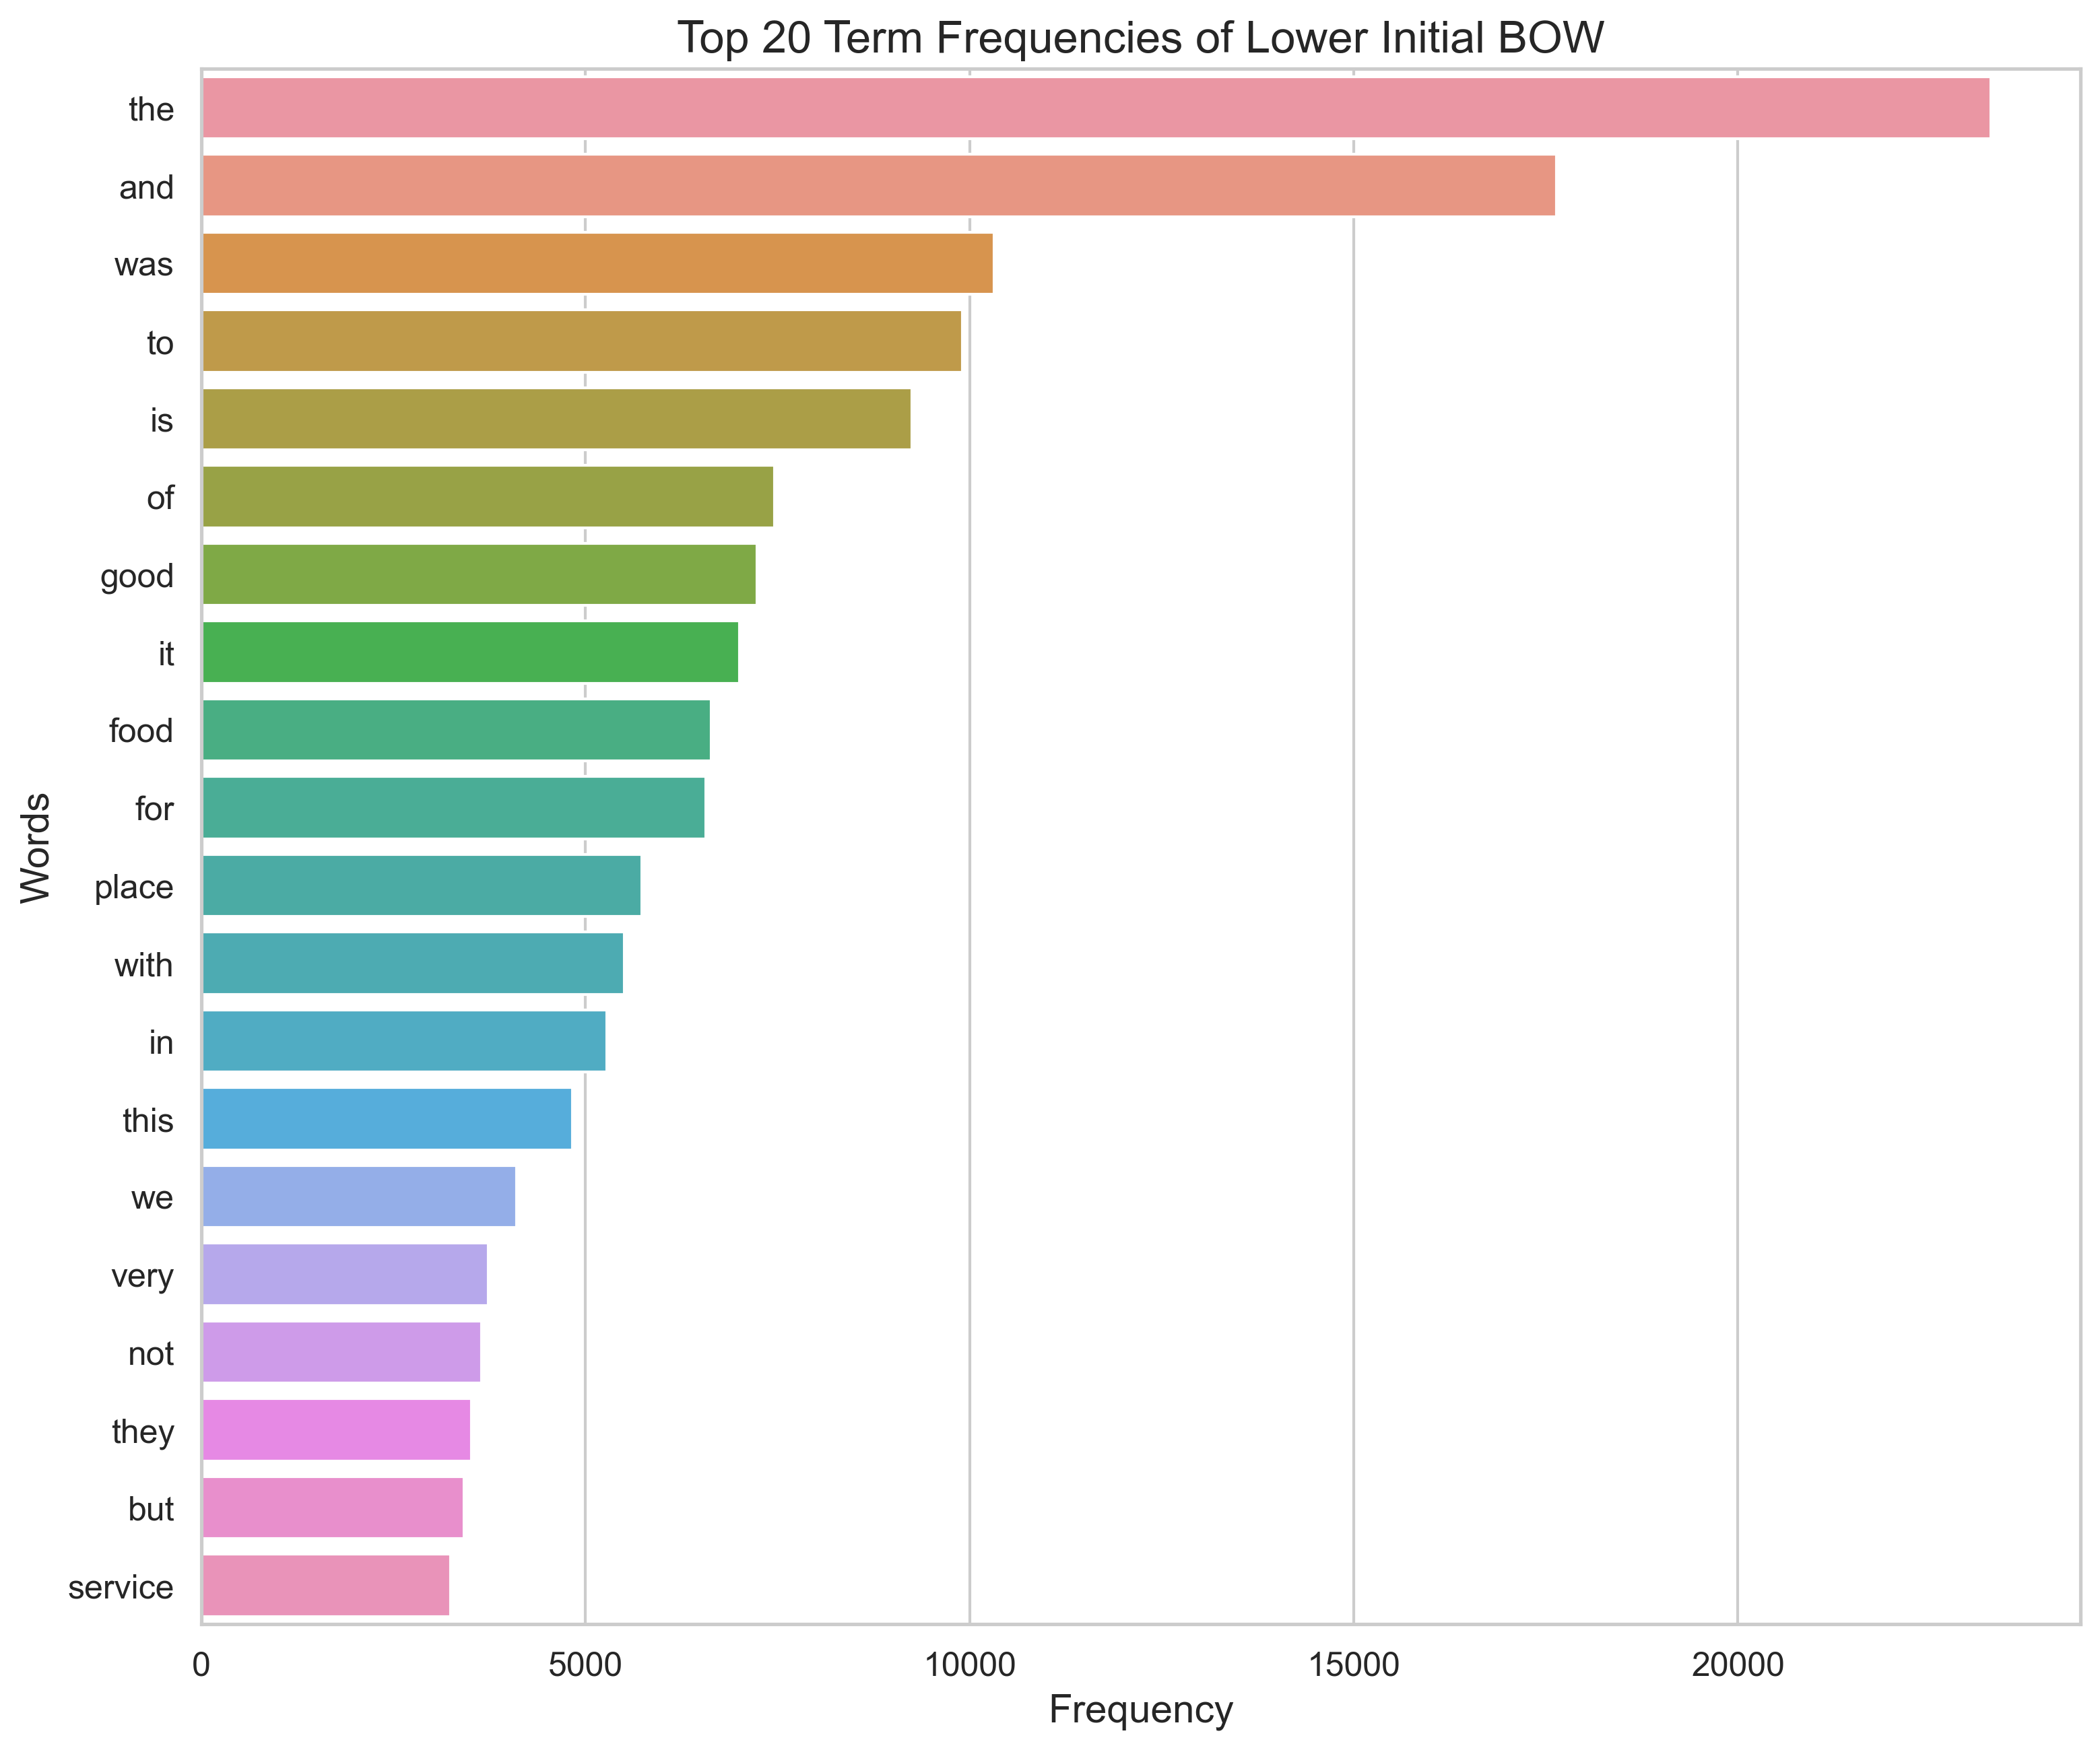

In [22]:
graph_clean_freq = plot_term_frequency(clean_bow_words_freq, name = "20_most_commun_words_initial", nr_terms=20, df_name = "Lower Initial BOW", show = True)

<font color='#BFD72F' size=4>2.2 Word cloud of reviews</font> <a class="anchor" id="P22"></a>
  
[Back to TOC](#toc)

In [ ]:
def word_cloud_generator(folder_path, wc):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    ##Bow visualization
    chapter_bow_df = pipeline.word_freq_calculator(clean_bow_td_matrix, clean_bow_word_list, df_output=False)
    wc.generate_from_frequencies(chapter_bow_df) ##Use color_func in word cloud?
    wc.to_file(os.path.join(folder_path, "First_BOW.png"))

In [24]:
wc = WordCloud(background_color="white",max_words=120, width = 220,height = 220, color_func=lambda *args, **kwargs: (0,0,0))
word_cloud_generator("graphs", wc)


<font color='#BFD72F' size=4>2.3 BOW treemap for the reviews</font> <a class="anchor" id="P23"></a>
  
[Back to TOC](#toc)

In [16]:
def get_pos_tag(word):
    tag = nltk.tag.pos_tag([word])[0][1]
    return tag

In [37]:
clean_bow_words_freq["pos_tag"] = clean_bow_words_freq["words"].apply(get_pos_tag)

#create a tree map
fig = px.treemap(clean_bow_words_freq[:350], 
                path=[px.Constant('Reviews'), 'pos_tag','words'], 
                values='frequency',
                color='frequency',
                color_continuous_scale='viridis',
                )

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

<font color='#BFD72F' size=4>2.4 BOW plot for the cuisine types</font> <a class="anchor" id="P24"></a>
  
[Back to TOC](#toc)

In [24]:
#Create a BOW and get the number of times each type of cuisine appears
bow_vectorizer = CountVectorizer(ngram_range=(1,2))
cuisine_td_matrix = bow_vectorizer.fit_transform(reviews_text_only["Cuisine"]).toarray()
cuisine_word_list = bow_vectorizer.get_feature_names_out().tolist()
cuisine_words_freq = pipeline.word_freq_calculator(cuisine_td_matrix, cuisine_word_list)
cuisine_words_freq

words  frequency
101               indian       7095
150                north       6095
152         north indian       5995
42               chinese       4095
106       indian chinese       2495
..                   ...        ...
60   continental biryani         99
153                pizza         99
155         salad burger         77
91            food salad         77
2          american fast         77

[173 rows x 2 columns]

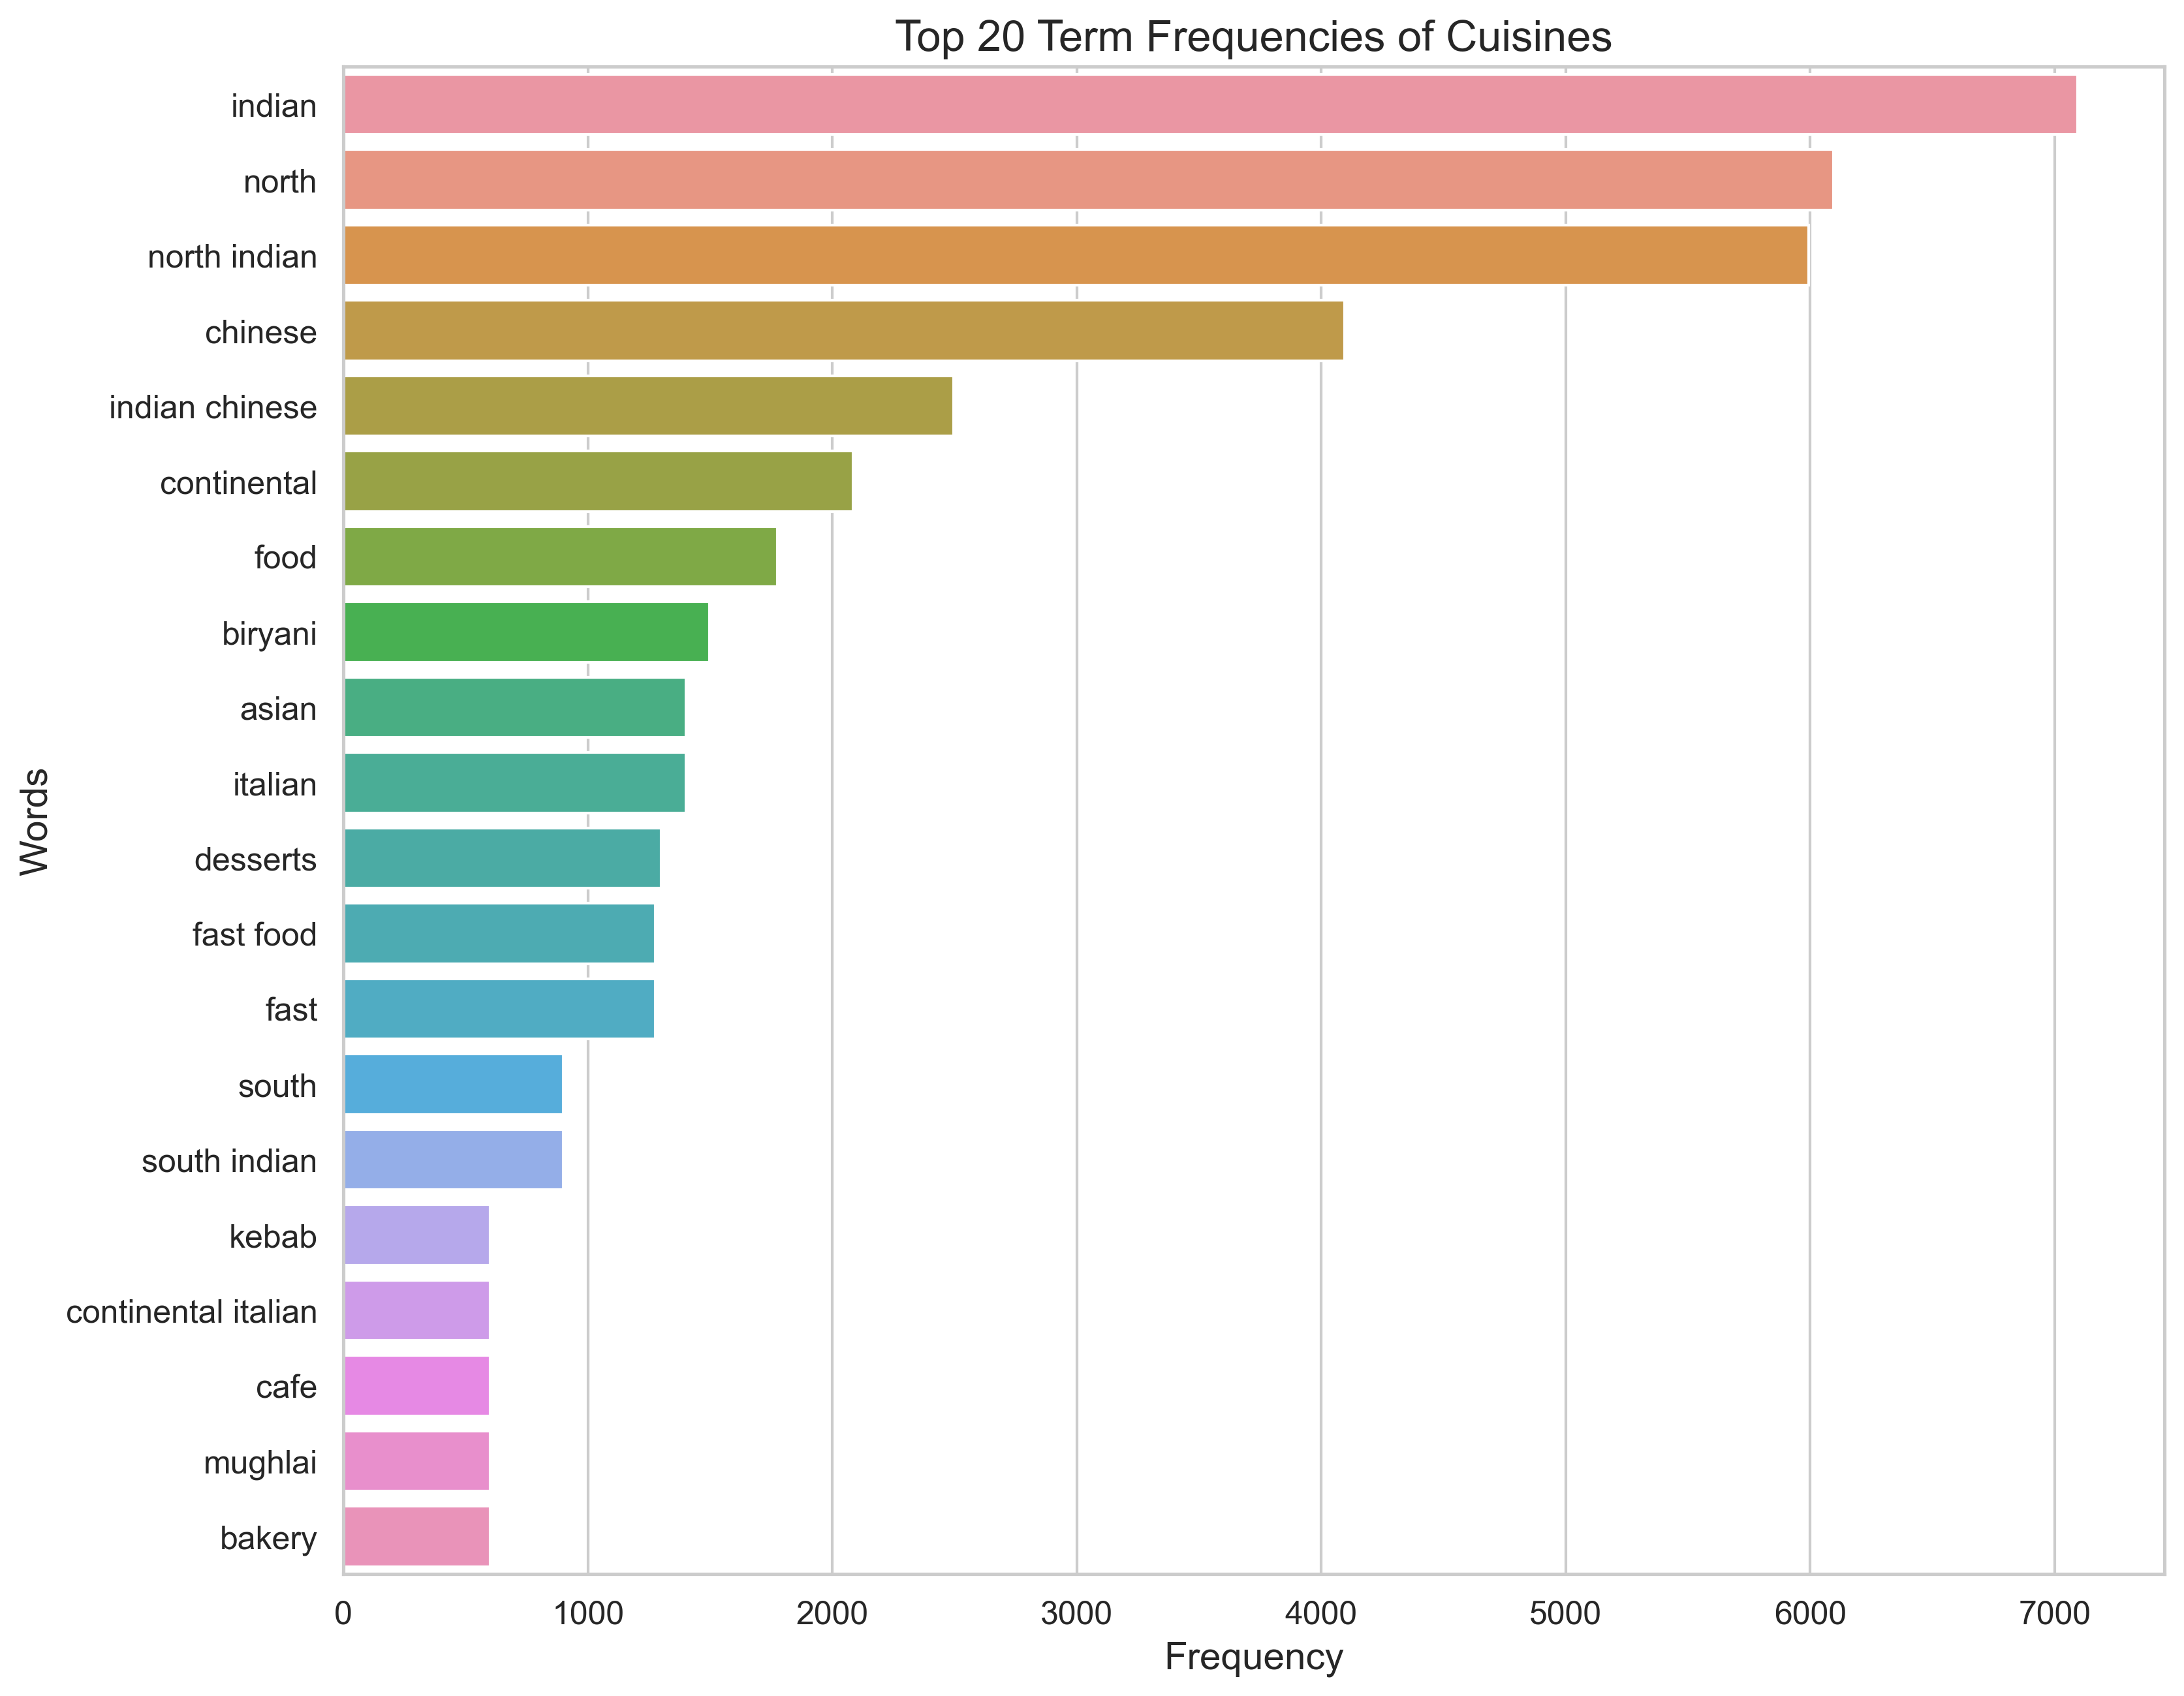

In [25]:
graph_clean_freq = plot_term_frequency(cuisine_words_freq, "20_most_commun_cuisine_types", 20, "Cuisines", show = True )

<font color='#BFD72F' size=4>2.5 Co-occurrence in `Cuisines` visualization</font> <a class="anchor" id="P25"></a>
  
[Back to TOC](#toc)

In [175]:
def cooccurrence_matrix_window_generator(preproc_sentences, window_size):

    co_occurrences = defaultdict(Counter)

    # Compute co-occurrences
    for sentence in tqdm(preproc_sentences):
        for i, word in enumerate(sentence):
            for j in range(max(0, i - window_size), min(len(sentence), i + window_size + 1)):
                if i != j:
                    co_occurrences[word][sentence[j]] += 1

    #ensure that words are unique
    unique_words = list(set([word for sentence in preproc_sentences for word in sentence]))

    # Initialize the co-occurrence matrix
    co_matrix = np.zeros((len(unique_words), len(unique_words)), dtype=int)

    # Populate the co-occurrence matrix
    word_index = {word: idx for idx, word in enumerate(unique_words)}
    for word, neighbors in co_occurrences.items():
        for neighbor, count in neighbors.items():
            co_matrix[word_index[word]][word_index[neighbor]] = count

    # Create a DataFrame for better readability
    co_matrix_df = pd.DataFrame(co_matrix, index=unique_words, columns=unique_words)

    co_matrix_df = co_matrix_df.reindex(co_matrix_df.sum().sort_values(ascending=False).index, axis=1)
    co_matrix_df = co_matrix_df.reindex(co_matrix_df.sum().sort_values(ascending=False).index, axis=0)

    # Return the co-occurrence matrix
    return co_matrix_df

In [ ]:
reviews_text_only["Cuisine_split"] = [[y.strip(' ') for y in x] for x in reviews_text_only["Cuisine"].map(lambda x: x.split(","))]

In [ ]:
print(reviews_text_only["Cuisine_split"].sample(1))

2706    [North Indian, Mediterranean, European]
Name: Cuisine_spit, dtype: object


In [ ]:
cuisines_cooccurrence_window = pipeline.cooccurrence_matrix_window_generator(reviews_text_only["Cuisine_split"].tolist(),10)

100%|██████████| 9955/9955 [00:00<00:00, 280529.53it/s]


In [179]:
fig = px.imshow(cuisines_cooccurrence_window.iloc[:, :], color_continuous_scale='reds', 
                labels=dict(x="Words", y="Words", color="Count"),
                title="Co-occurrence matrix for the Cuisines (All co-occurring words)", 
                width=1200, height=1200)

fig.show()

From this data exploration we concluded:
- There are a lot of stop words in the `Reviews` with only 4 words in the top 20 most common words that are not stop words
- In the list of the 20 most common cuisine types it was used bigramns in order to capture some types that had two words foming them
such as `North Indian`, however this led to other common combinations also appearing in the graph, from this plot we can conclude that `North Indian`, `Chinese` and `Continental` are the most common types of cuisines
- `North Indian` and `Chinese` are by far the two cuisine types that appear together in restaurants


<font color='#BFD72F' size=5>3. Sentiment Analysis</font> <a class="anchor" id="P3"></a>
  
[Back to TOC](#toc)


##### How well can we predict a restaurant’s Zomato score using the polarity of their reviews as input?

In [15]:
reviews

Restaurant              Reviewer  \
0      Beyond Flavours     Rusha Chakraborty   
1      Beyond Flavours  Anusha Tirumalaneedi   
2      Beyond Flavours       Ashok Shekhawat   
3      Beyond Flavours        Swapnil Sarkar   
4      Beyond Flavours                Dileep   
...                ...                   ...   
9995  Chinese Pavilion      Abhishek Mahajan   
9996  Chinese Pavilion        Sharad Agrawal   
9997  Chinese Pavilion             Ramandeep   
9998  Chinese Pavilion       Nayana Shanbhag   
9999  Chinese Pavilion      Bhargava Krishna   

                                                 Review Rating  \
0     The ambience was good, food was quite good . h...      5   
1     Ambience is too good for a pleasant evening. S...      5   
2     A must try.. great food great ambience. Thnx f...      5   
3     Soumen das and Arun was a great guy. Only beca...      5   
4     Food is good.we ordered Kodi drumsticks and ba...      5   
...                                                 ...    ...   
9995  Madhumathi Mahajan Well to start with nice cou...      3   
9996  This place has never disappointed us.. The foo...    4.5   
9997  Bad rating is mainly because of "Chicken Bone ...    1.5   
9998  I personally love and prefer Chinese Food. Had...      4   
9999  Checked in here to try some delicious chinese ...    3.5   

                          Metadata             Time  Pictures  \
0           1 Review , 2 Followers  5/25/2019 15:54         0   
1          3 Reviews , 2 Followers  5/25/2019 14:20         0   
2          2 Reviews , 3 Followers  5/24/2019 22:54         0   
3            1 Review , 1 Follower  5/24/2019 22:11         0   
4          3 Reviews , 2 Followers  5/24/2019 21:37         0   
...                            ...              ...       ...   
9995     53 Reviews , 54 Followers    6/5/2016 0:08         0   
9996      2 Reviews , 53 Followers   6/4/2016 22:01         0   
9997    65 Reviews , 423 Followers   6/3/2016 10:37         3   
9998    13 Reviews , 144 Followers  5/31/2016 17:22         0   
9999  472 Reviews , 1302 Followers  5/31/2016 16:41         6   

                                                Cuisine  
0     Chinese, Continental, Kebab, European, South I...  
1     Chinese, Continental, Kebab, European, South I...  
2     Chinese, Continental, Kebab, European, South I...  
3     Chinese, Continental, Kebab, European, South I...  
4     Chinese, Continental, Kebab, European, South I...  
...                                                 ...  
9995                                   Chinese, Seafood  
9996                                   Chinese, Seafood  
9997                                   Chinese, Seafood  
9998                                   Chinese, Seafood  
9999                                   Chinese, Seafood  

[10000 rows x 8 columns]

In [27]:
sent_analysis = reviews.copy()
sent_analysis.drop(columns = ["Restaurant", "Reviewer", "Metadata", "Time", "Cuisine", "Pictures"], inplace = True)
sent_analysis.dropna(subset = "Review", inplace = True)
sent_analysis.isna().sum()

Review    0
Rating    0
dtype: int64

In [28]:
unknown_rating = sent_analysis.loc[sent_analysis["Rating"] == "Like"].copy()
unknown_rating

Review Rating
7601  One of the best pizzas to try. It served with ...   Like

In [29]:
sent_analysis["Rating"] = sent_analysis["Rating"].apply(lambda x: float(x) if x != "Like" else np.nan)
sent_analysis.dropna(inplace=True)

In [30]:
sent_analysis.describe()

Rating
count  9954.000000
mean      3.600261
std       1.483573
min       1.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       5.000000

- There were missing values in the `Reviews`column which were dropped
- The "Like" in `Rating` previously mentioned was removed from the dataset but stored in a new variable to later on try and see what the probable value of the rating is based on the model that works best
- The mean rating is 3.6

<font color='#BFD72F' size=4>3.1 Data Preprocessing</font> <a class="anchor" id="P31"></a>
  
[Back to TOC](#toc)

In [31]:
sent_tokenizer = PunktSentenceTokenizer()

In [32]:
preprocessor = pipeline.MainPipeline(no_emojis = False,
                                        emojis_to_unicode = True,
                                        no_stopwords=False,
                                        lowercase=False,
                                        lemmatized=False,
                                        no_punctuation=False)


sent_analysis["Review_prepared"] = sent_analysis["Review"].map(lambda x:preprocessor.main_pipeline(x))

In [22]:
preprocessor = pipeline.MainPipeline(print_output=False,
                                        no_stopwords=False,
                                        lowercase=False,
                                        lemmatized=False,
                                        no_punctuation=False,
                                        no_emojis = False,
                                        emojis_to_unicode = True)

unknown_rating["Review_prepared"] = unknown_rating["Review"].apply(lambda x: preprocessor.main_pipeline(x))

In [23]:
preprocessor = pipeline.MainPipeline(print_output=False,
                                          no_stopwords=False,
                                          lowercase=False,
                                          lemmatized=False,
                                          no_punctuation=False,
                                          no_emojis = False,
                                          emojis_to_unicode = True
                                          )

sent_analysis["Review_prepared_sentences"] =\
      sent_analysis["Review"].map(lambda content : [preprocessor.main_pipeline(sentence)for sentence in sent_tokenizer.tokenize(content)])

In [24]:
sent_analysis

Review  Rating  \
0     The ambience was good, food was quite good . h...     5.0   
1     Ambience is too good for a pleasant evening. S...     5.0   
2     A must try.. great food great ambience. Thnx f...     5.0   
3     Soumen das and Arun was a great guy. Only beca...     5.0   
4     Food is good.we ordered Kodi drumsticks and ba...     5.0   
...                                                 ...     ...   
9995  Madhumathi Mahajan Well to start with nice cou...     3.0   
9996  This place has never disappointed us.. The foo...     4.5   
9997  Bad rating is mainly because of "Chicken Bone ...     1.5   
9998  I personally love and prefer Chinese Food. Had...     4.0   
9999  Checked in here to try some delicious chinese ...     3.5   

                                        Review_prepared  \
0     The ambience was good, food was quite good . h...   
1     Ambience is too good for a pleasant evening . ...   
2     A must try .. great food great ambience . Thnx...   
3     Soumen das and Arun was a great guy . Only bec...   
4     Food is ordered Kodi drumsticks and basket mut...   
...                                                 ...   
9995  Madhumathi Mahajan Well to start with nice cou...   
9996  This place has never disappointed us .. The fo...   
9997  Bad rating is mainly because of "Chicken Bone ...   
9998  I personally love and prefer Chinese Food . Ha...   
9999  Checked in here to try some delicious chinese ...   

                              Review_prepared_sentences  
0     [The ambience was good, food was quite good., ...  
1     [Ambience is too good for a pleasant evening.,...  
2     [A must try .. great food great ambience., Thn...  
3     [Soumen das and Arun was a great guy., Only be...  
4     [Food is ordered Kodi drumsticks and basket mu...  
...                                                 ...  
9995  [Madhumathi Mahajan Well to start with nice co...  
9996  [This place has never disappointed us .. The f...  
9997  [Bad rating is mainly because of "Chicken Bone...  
9998  [I personally love and prefer Chinese Food., H...  
9999  [Checked in here to try some delicious chinese...  

[9954 rows x 4 columns]

<font color='#BFD72F' size=4>3.2 Model Implemetation - Vader</font> <a class="anchor" id="P32"></a>
  
[Back to TOC](#toc)

In [33]:
vader = SentimentIntensityAnalyzer()

In [34]:
def vader_wrapper(user_review):    
    if type(user_review) == list:
        sent_compound_list = []
        for sentence in user_review:
            sent_compound_list.append(vader.polarity_scores(sentence)["compound"])
        polarity = np.array(sent_compound_list).mean()
    else:
        polarity = vader.polarity_scores(user_review)["compound"]
    return polarity

In [35]:
sent_analysis["Review_polarity_vader"] = sent_analysis["Review_prepared"].map(lambda review: vader_wrapper(review))
sent_analysis["Review_sentences_mean_polarity_vader"] = sent_analysis["Review_prepared_sentences"].map(lambda review: vader_wrapper(review))

In [28]:
sent_analysis.sample(5)

Review  Rating  \
2112  I think there is no point of taking a buffet h...     1.0   
7171  Being a foodie and going for a buffet is like ...     3.0   
2865  need more quantity..because We paid toomuch fo...     4.0   
1856  This was an amazing place . You can go there w...     5.0   
862   The drunch trend has picked up in Hyderabad an...     3.0   

                                        Review_prepared  \
2112  I think there is no point of taking a buffet h...   
7171  Being a foodie and going for a buffet is like ...   
2865             need more We paid toomuch for a single   
1856  This was an amazing place . You can go there w...   
862   The drunch trend has picked up in Hyderabad an...   

                              Review_prepared_sentences  \
2112  [I think there is no point of taking a buffet ...   
7171  [Being a foodie and going for a buffet is like...   
2865           [need more We paid toomuch for a single]   
1856  [This was an amazing place., You can go there ...   
862   [The drunch trend has picked up in Hyderabad a...   

      Review_polarity_vader  Review_sentences_mean_polarity_vader  
2112                 0.7964                              0.125740  
7171                -0.9397                             -0.033506  
2865                 0.0000                              0.000000  
1856                 0.9674                              0.451929  
862                  0.9343                              0.115050

<font color='#BFD72F' size=4>3.3 Model Evaluation - Vader</font> <a class="anchor" id="P33"></a>
  
[Back to TOC](#toc)

In [29]:
pearson_r, p_value = pearsonr(sent_analysis["Review_sentences_mean_polarity_vader"],sent_analysis["Review_polarity_vader"])
pearson_r

0.8210013150174685

In [30]:
pearson_r, p_value = pearsonr(sent_analysis["Review_sentences_mean_polarity_vader"],sent_analysis["Rating"])
pearson_r

0.6983362875728562

In [31]:
pearson_r, p_value = pearsonr(sent_analysis["Review_polarity_vader"],sent_analysis["Rating"])
pearson_r

0.7059359299656068

Vader conclusions:
- Theres a high correlation between separating the reviews into sentences or not which mean that they are given almost the same information
- The correlation between the values obtained when doing the sentiment analysis separating reviews in sentences is slightly lower than when reviews are treated as whole (0.698 < 0.706)
- With this we conclude that the best version of the Vader is the one that does not separate the reviews into sentences


<font color='#BFD72F' size=4>3.4 Model Implemetation - TextBlob</font> <a class="anchor" id="P34"></a>
  
[Back to TOC](#toc)

In [32]:
def textblob_wrapper(user_review):   
    if type(user_review) == list:
        sent_compound_list = []
        for sentence in user_review:
            sent_compound_list.append(TextBlob(sentence).sentiment.polarity)
        polarity = np.array(sent_compound_list).mean()
    else:
        polarity = TextBlob(user_review).sentiment.polarity
    return polarity

In [33]:
sent_analysis["Review_polarity_textblob"] = sent_analysis["Review_prepared"].map(lambda review : textblob_wrapper(review))
sent_analysis["Review_sentences_mean_polarity_textblob"] = sent_analysis["Review_prepared_sentences"].map(lambda review : textblob_wrapper(review))

In [34]:
sent_analysis.sample(5)

Review  Rating  \
6554  Fantastic Place to hangout with your buddies. ...     5.0   
5934  Visited with my gang here and tasted chicken f...     5.0   
9203  Had a great experience at this place. Went for...     5.0   
3620  Nice, cozy family restaurant. Offers a nice va...     4.0   
8459  Bad ambience, ok food.  Soups were great. Had ...     2.0   

                                        Review_prepared  \
6554  Fantastic Place to hangout with your buddies ....   
5934  Visited with my gang here and tasted chicken f...   
9203  Had a great experience at this place . Went fo...   
3620  Nice, cozy family restaurant . Offers a nice v...   
8459  Bad ambience, ok food . Soups were great . Had...   

                              Review_prepared_sentences  \
6554  [Fantastic Place to hangout with your buddies....   
5934  [Visited with my gang here and tasted chicken ...   
9203  [Had a great experience at this place., Went f...   
3620  [Nice, cozy family restaurant., Offers a nice ...   
8459  [Bad ambience, ok food., Soups were great., Ha...   

      Review_polarity_vader  Review_sentences_mean_polarity_vader  \
6554                 0.8976                              0.404450   
5934                 0.8251                              0.412550   
9203                 0.9643                              0.678033   
3620                 0.8807                              0.388075   
8459                 0.2732                              0.030983   

      Review_polarity_textblob  Review_sentences_mean_polarity_textblob  
6554                  0.325000                                 0.325000  
5934                  0.080000                                 0.050000  
9203                  0.660000                                 0.633333  
3620                  0.273810                                 0.289583  
8459                 -0.018681                                 0.022436

<font color='#BFD72F' size=4>3.5 Model Evaluation - TextBlob</font> <a class="anchor" id="P35"></a>
  
[Back to TOC](#toc)

In [35]:
pearson_r, p_value = pearsonr(sent_analysis["Review_sentences_mean_polarity_textblob"],sent_analysis["Review_polarity_textblob"])
pearson_r

0.9554386058038344

In [36]:
pearson_r, p_value = pearsonr(sent_analysis["Review_sentences_mean_polarity_textblob"],sent_analysis["Rating"])
pearson_r

0.6784612861491148

In [37]:
pearson_r, p_value = pearsonr(sent_analysis["Review_polarity_textblob"],sent_analysis["Rating"])
pearson_r

0.6946786704212996

TextBlob conclusions:
- Theres a very high correlation between separating the reviews into sentences or not which mean that they give pretty much the same information
- The correlation between the values obtained when doing the sentiment analysis separating reviews in sentences is slightly lower than when reviews are treated as whole (0.678 < 0.695)
- With this we conclude that the best version of the TextBlob is the one that does not separate the reviews into sentences

<font color='#BFD72F' size=4>3.6 Model Evaluation - Vader vs TextBlob</font> <a class="anchor" id="P36"></a>
  
[Back to TOC](#toc)

In [38]:
pearson_r, p_value = pearsonr(sent_analysis["Review_polarity_textblob"],sent_analysis["Review_polarity_vader"])
pearson_r

0.6588012374782717

In [39]:
scaler = preprocessing.MinMaxScaler()
normalized_score = scaler.fit_transform(sent_analysis["Rating"].to_numpy().reshape(-1, 1))
normalized_polarity_vader = scaler.fit_transform(sent_analysis["Review_polarity_vader"].to_numpy().reshape(-1, 1))
normalized_polarity_textblob = scaler.fit_transform(sent_analysis["Review_polarity_textblob"].to_numpy().reshape(-1, 1))
normalized_polarity_vader_sent = scaler.fit_transform(sent_analysis["Review_sentences_mean_polarity_vader"].to_numpy().reshape(-1, 1))
normalized_polarity_textblob_sent = scaler.fit_transform(sent_analysis["Review_sentences_mean_polarity_textblob"].to_numpy().reshape(-1, 1))

In [40]:
rmse = mean_squared_error(normalized_score.reshape(-1), normalized_polarity_vader.reshape(-1), squared=False)
mape = mean_absolute_percentage_error(normalized_score.reshape(-1)+1, normalized_polarity_vader.reshape(-1)+1)
print("Vader: RMSE: {}; MAPE: {}".format(round(rmse, 3), round(mape, 3)))

Vader: RMSE: 0.278; MAPE: 0.147


In [41]:
rmse = mean_squared_error(normalized_score.reshape(-1), normalized_polarity_vader_sent.reshape(-1), squared=False)
mape = mean_absolute_percentage_error(normalized_score.reshape(-1)+1, normalized_polarity_vader_sent.reshape(-1)+1)
print("Vader diveded into sentences: RMSE: {}; MAPE: {}".format(round(rmse, 3), round(mape, 3)))

Vader diveded into sentences: RMSE: 0.275; MAPE: 0.157


In [42]:
rmse = mean_squared_error(normalized_score.reshape(-1), normalized_polarity_textblob.reshape(-1), squared=False)
mape = mean_absolute_percentage_error(normalized_score.reshape(-1)+1, normalized_polarity_textblob.reshape(-1)+1)
print("Texblob: RMSE: {}; MAPE: {}".format(round(rmse, 3), round(mape, 3)))

Texblob: RMSE: 0.278; MAPE: 0.159


In [43]:
rmse = mean_squared_error(normalized_score.reshape(-1), normalized_polarity_textblob_sent.reshape(-1), squared=False)
mape = mean_absolute_percentage_error(normalized_score.reshape(-1)+1, normalized_polarity_textblob_sent.reshape(-1)+1)
print("Textblob diveded into sentences: RMSE: {}; MAPE: {}".format(round(rmse, 3), round(mape, 3)))

Textblob diveded into sentences: RMSE: 0.287; MAPE: 0.166


Comparisons first conclusions:
- The RMSE is almost identical in all the models, only varying from 0.275 to 0.287, the Vader model when the reviews separated by sentences is the other that has a lower error
- The MAPE is better in the Vader model that doesn't separate sentences, with value 0.147 which is significantly lower than the second best one that is the Vader that separates sentences model with value 0.157
- Overall we think that the model that performed the best was the Vader that does not separate the reviews into sentences with RMSE: 0.278 and MAPE: 0.147 and the second best is Vader with the sentences separated with RMSE: 0.275 and MAPE: 0.157
- Vader performs better than TextBlob which was expected as Vader is better for understanding informal text while TextBlob usually is better in formal text

In [44]:
sent_analysis["normalized_score"] = normalized_score.reshape(-1)
sent_analysis["normalized_polarity_vader"] = normalized_polarity_vader.reshape(-1)
sent_analysis["normalized_polarity_vader_sentences_sep"] = normalized_polarity_vader.reshape(-1)

sent_analysis.describe()

Rating  Review_polarity_vader  \
count  9954.000000            9954.000000   
mean      3.600261               0.475250   
std       1.483573               0.584884   
min       1.000000              -0.994200   
25%       3.000000               0.000000   
50%       4.000000               0.765200   
75%       5.000000               0.935850   
max       5.000000               0.999700   

       Review_sentences_mean_polarity_vader  Review_polarity_textblob  \
count                           9954.000000               9954.000000   
mean                               0.276817                  0.249211   
std                                0.374054                  0.364508   
min                               -0.972100                 -1.000000   
25%                                0.000000                  0.000182   
50%                                0.318971                  0.275000   
75%                                0.506739                  0.503125   
max                                0.995500                  1.000000   

       Review_sentences_mean_polarity_textblob  normalized_score  \
count                              9954.000000       9954.000000   
mean                                  0.227533          0.650065   
std                                   0.337089          0.370893   
min                                  -1.000000          0.000000   
25%                                   0.000000          0.500000   
50%                                   0.235014          0.750000   
75%                                   0.452470          1.000000   
max                                   1.000000          1.000000   

       normalized_polarity_vader  normalized_polarity_vader_sentences_sep  
count                9954.000000                              9954.000000  
mean                    0.736973                                 0.736973  
std                     0.293337                                 0.293337  
min                     0.000000                                 0.000000  
25%                     0.498621                                 0.498621  
50%                     0.882391                                 0.882391  
75%                     0.967977                                 0.967977  
max                     1.000000                                 1.000000

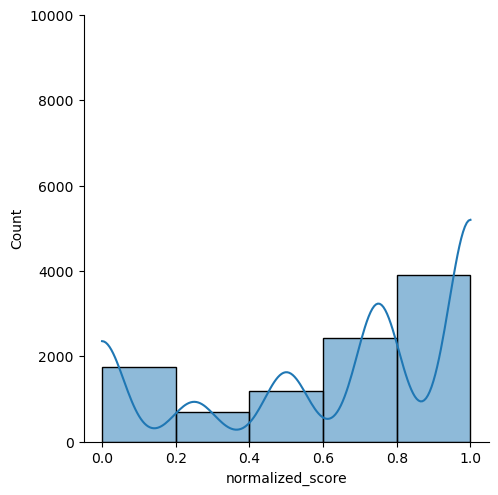

In [45]:
score_graph = sns.displot(sent_analysis["normalized_score"], kde=True, bins=5)
plt.ylim(0, 10000)
plt.show()

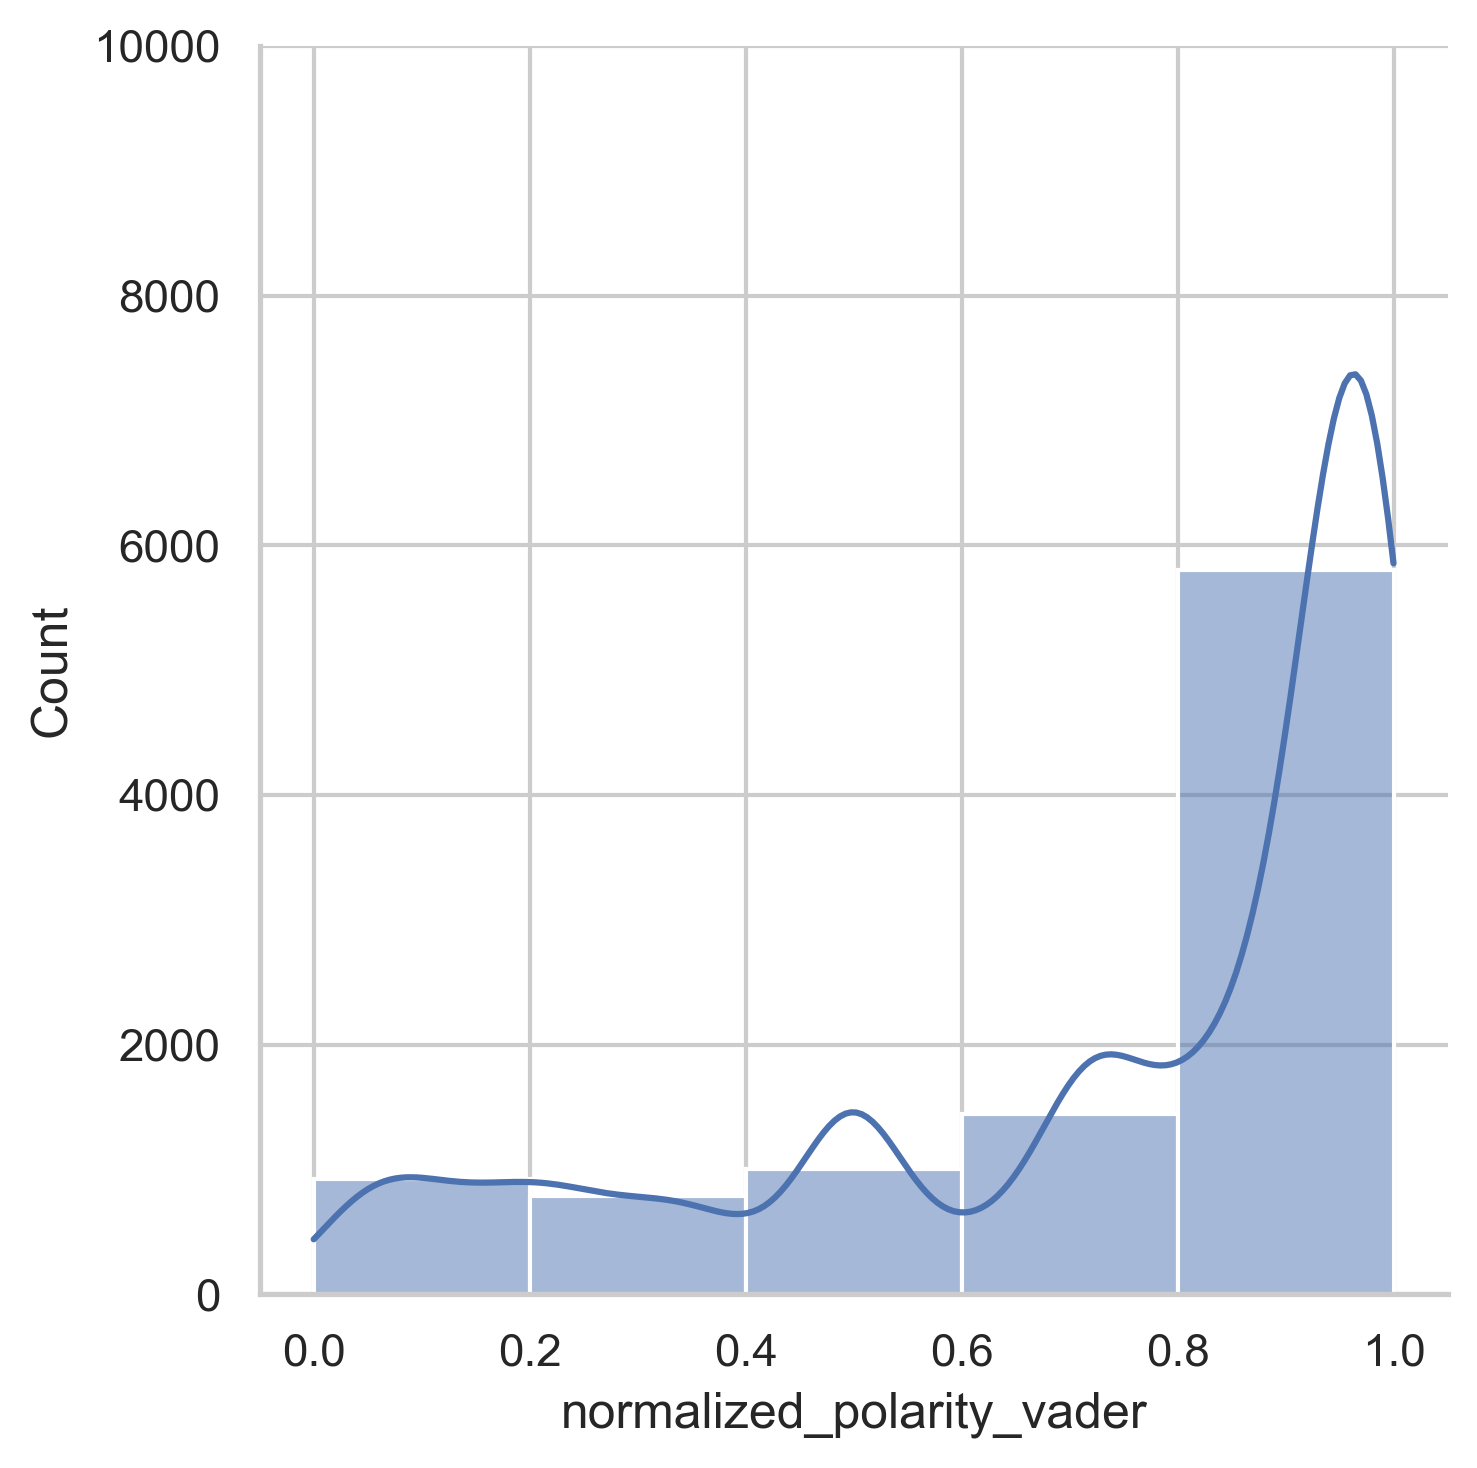

In [38]:
# done differently to use on report
polarity_graph = sns.displot(sent_analysis["normalized_polarity_vader"], kde=True, bins=5)
plt.ylim(0, 10000)
plt.show()
%config InlineBackend.figure.format = "svg"

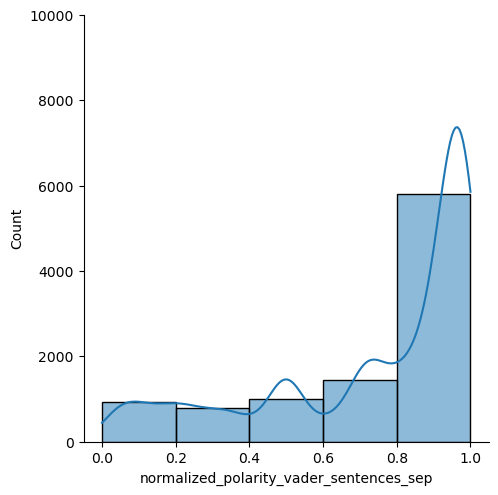

In [47]:
score_graph = sns.displot(sent_analysis["normalized_polarity_vader_sentences_sep"], kde=True, bins=5)
plt.ylim(0, 10000)
plt.show()

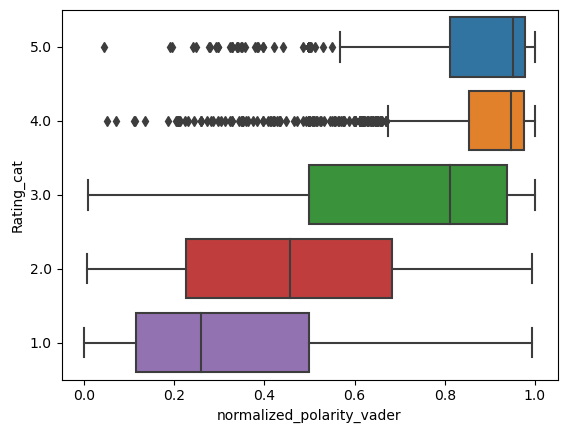

In [48]:
sent_analysis["Rating_cat"] = sent_analysis["Rating"].apply(lambda score : str(score))
sns.boxplot(data=sent_analysis, x="normalized_polarity_vader", y="Rating_cat", order=["5.0", "4.0", "3.0", "2.0", "1.0"])
plt.show()

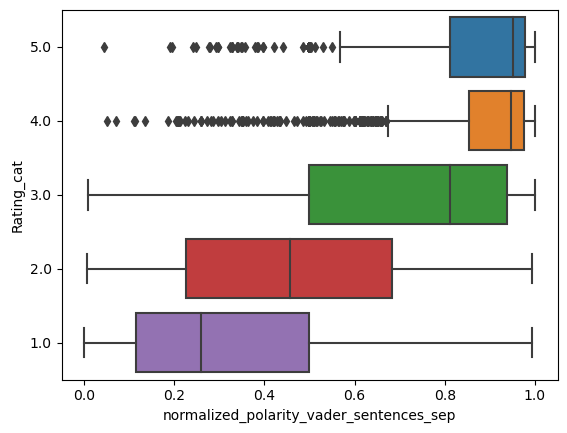

In [49]:
sent_analysis["Rating_cat"] = sent_analysis["Rating"].apply(lambda score : str(score))
sns.boxplot(data=sent_analysis, x="normalized_polarity_vader_sentences_sep", y="Rating_cat", order=["5.0", "4.0", "3.0", "2.0", "1.0"])
plt.show()

Comparisons final conclusions: 
- As we can see by analyzing both plots the results are very similar what was expected since the correlation between the 2 is extremely high, however when taken into account the metrics RMSE and MAPE and also the plots, we believe that Vader without the senteces separated works better

Final conclusions about the difference in rating and in speech score:
- The mean normalized rating is 0.650065
- The mean normalized Vader score is 0.736973
- This means that in average, people are rating restaurants worse than they actually fell about them
- This discrepancy in scores is about 0.086908, which is equivalent to 0.43454 in the scale 0 to 5 of the ranking
- Clients are on average giving half a star less than what they actually feel according to their reviews

<font color='#BFD72F' size=4>3.7 Outliers analysis - good vader, bad rating and vice-versa</font> <a class="anchor" id="P37"></a>
  
[Back to TOC](#toc)

#### Good Vader Scores and Bad Ratings

In [50]:
filtered_data = sent_analysis[(sent_analysis["Review_polarity_vader"] > 0.75) & (sent_analysis["Rating"] == 1.0)]
random_samples = filtered_data.sample(n=5, random_state=1)

In [51]:
len(filtered_data) / len(sent_analysis)

0.009041591320072333

In [52]:
random_samples

Review  Rating  \
5562  Update: Just wanted to make sure the cafe woul...     1.0   
8122  Chowmein was mentioned as ur special item, but...     1.0   
3832  Can improve your main course and desserts spre...     1.0   
5366  Many issues to start with :\n1. No Valet Parki...     1.0   
9455  no stars for these Dunkin outlet.\nwas craving...     1.0   

                                        Review_prepared  \
5562  Update: Just wanted to make sure the cafe woul...   
8122  Chowmein was mentioned as ur special item, but...   
3832  Can improve your main course and desserts spre...   
5366  Many issues to start with: 1 . No Valet Parkin...   
9455  no stars for these Dunkin outlet . was craving...   

                              Review_prepared_sentences  \
5562  [Update: Just wanted to make sure the cafe wou...   
8122  [Chowmein was mentioned as ur special item, bu...   
3832  [Can improve your main course and desserts spr...   
5366  [Many issues to start with: 1., No Valet Parki...   
9455  [no stars for these Dunkin outlet., was cravin...   

      Review_polarity_vader  Review_sentences_mean_polarity_vader  \
5562                 0.9542                              0.074636   
8122                 0.9198                              0.446833   
3832                 0.8861                              0.293640   
5366                 0.8257                              0.092911   
9455                 0.8658                              0.091536   

      Review_polarity_textblob  Review_sentences_mean_polarity_textblob  \
5562                  0.022619                                 0.052679   
8122                  0.130220                                 0.138350   
3832                 -0.033333                                -0.060000   
5366                  0.265278                                 0.114167   
9455                 -0.015556                                 0.004545   

      normalized_score  normalized_polarity_vader  \
5562               0.0                   0.977180   
8122               0.0                   0.959928   
3832               0.0                   0.943026   
5366               0.0                   0.912734   
9455               0.0                   0.932845   

      normalized_polarity_vader_sentences_sep Rating_cat  
5562                                 0.977180        1.0  
8122                                 0.959928        1.0  
3832                                 0.943026        1.0  
5366                                 0.912734        1.0  
9455                                 0.932845        1.0

In [53]:
print(random_samples["Review"][5562])

Update: Just wanted to make sure the cafe would know... I am reverting my rating to a 1 coz your staff's issue with the payment caused me a ton of pain now. To make a long story short.. you guys charged me twice on the same day and then charged me the same amount after almost 3days of visiting your cafe. Now thanks to that my bank decided my card has been compromised and blocked my card. My account went into negative balance you guys decided to charge me thrice overall and refund me once, my card is blocked and i am pissed. Truly a nightmare experience, all because i choose your establisment by mistake.

Old review:
                         This place was on my bookmark list for a while and I was excited to visit it on Saturday. We ordered a mushroom quiche, a primavera pizza and a grilled vegetable panini.The mushroom quiche was alright but what knocked me out was the price. It was a relatively small piece with a spoon of caramalized onions and a small amount of onions and salad and t

In this example the model may have mistakenly rated this review as it is composed by 2 reviews and one is very positive and the other negative

In [54]:
print(random_samples["Review"][8122])

Chowmein was mentioned as ur special item, but it was more like plain white noodles mixed with lots of different uncooked vegetables.
Bhindi masala was more like a thick curry, but could eat it somehow.
The only good thing in the entire order was fulkas, because I ordered fulkaas, and I got exactly that.


In this review the model could have done better however this also seams a review of a 2.0 rating instead of 1.0, so overall the model should have done better but this review could be confusing for a machine as it doesn't have clearly "bad" words

In [55]:
print(random_samples["Review"][3832])

Can improve your main course and desserts spread. I would have rated 3 but I am giving a 1 because one of your servers' behavior was bad in our office party. When my friend asked for a blue lagoon, he insulted him in front of everybody by saying that blue lagoon is for kids, not men... just because it's a soft drink. One need not believe in others' beliefs and customs, but at least respect them and not insult them. Train your staff appropriately.


In [56]:
print(random_samples["Review"][9455])

no stars for these Dunkin outlet.
was craving to have dounuts.. went with a happy face and came out with huge disappointment. huge chaos with h service . filthy .. table unclear for half hr. had to wait for 3 dounut for half hr. which were ready on display. burger was cold and potato wedges Wer half cooked. asked to warm up dounut, but the they were cold too. service girl was seen carring doughnuts in hand and not tray to service table. loud ringtone was playing on speaker. reluctantly carried dounuts, came out sat outside in clean place and ate it .. 😒


This two reviews are poorly avaliated by Vader, especially the second one, but both clearly don't deserve a score bigger than 0.8

In [57]:
print(random_samples["Review"][5366])

Many issues to start with :
1. No Valet Parking as quoted .
2. Everything that was served on the plate was chilled , and I mean it.
3. Nothing was planned , like the placement of food , it was more of a day to day kitchen.
4. On the contrary , Ice-cream was already melt :)

Taste was good, had it been served properly it would've definitely deserved more than 4*.

Hope these things are taken proper care of.


Has bullet points which could confuse the model and ends by saying that having the restaurant solved the 4 problems that aren't really something terrible it would have deserved at least a 4 star review. The rating of one star for this review seams pretty exagerated, so it more of a problem of the compatibility between the review and rating itself then the model

#### Bad Vader Scores and Good Ratings

In [61]:
print(sent_analysis[(sent_analysis["Review_polarity_vader"] < -0.75) & (sent_analysis["Rating"] == 5.0)]["Review"][306])

Used to hear that this was probably the best place to have haleem in the city. To my dismay I ordered their renowned haleem last night at about 12PM. Tastewise it seemed average but as I was hungry I finished it fast. Fell asleep at 2AM to wake up at 5AM with a severe upset stomach. This went on and when I woke up by 10AM my stomach still hurt. I'm pretty sure it was some form of mild food poisoning maybe due to hygiene  standards. Nonetheless if they keep this up they'll gradually lose their clientele. Would recommend a place called Cafe 555. Their haleem is far tastier and doesn't come with the complimentary food poisoning.


In [59]:
1/len(sent_analysis)

0.00010046212577858148

This is probably a mistake made by the client as this is a clear 1.0 star rating review, as nothing it says is positive and also reccomends people to go to other places as they got food poisoning there

Conclusion on outliers and model performance:

In the good vader and bad rating:
- There were only 0.9041591320072333% of outliers according to our threshold, which is a very low number and an acceptable value for any model that performs well
- The total of this outliers were 70, of which only a sample of 5 were analyzed. Of those 5, 3 were confusing reviews for machines to understand because they were composed of two completely opposite reviews or had bullet points and were exagerated, the other 2 were more or less clear errors of the model

In the bad vader and good rating:
- It was only found 1 outlier (0.010046212577858148%) and that outlier wasn't even an error of the model as the review was clearly very negative and the rating of 5.0 should have been instead a 1.0 which would represent much better what the reviewer meant in the review


Conclusions on how well can we predict a restaurant’s Zomato score using the polarity of their reviews as input:
- The results obtained were pretty good, especially with Vader that does not separate the reviews into sentences that has RMSE: 0.278 and MAPE: 0.147, also has a correlation of 0.7059359299656068 with the actual ratings, which are all fairly good values for the metrics
- With the analysis of the outliers we could also see that the model gets good scores as for the outliers where the model predicts good values but the real ones are bad represent only avery small part (0.9%) and also for the examples we got half were more human mistakes at giving the rating than the model's mistake, as for the only outlier where the model predicts bad values but the real one is good (this only one case represents 0.01% of the data) is not even a model's mistake as the review of that case is very bad towards the restaurant so that's no way the person should ever even given a good rating to begin with (the reving pointed towards a bad rating which was captured by the model, however the person, by mistake perhaps gave a good rating)

<font color='#BFD72F' size=5>4. Multilabel Classification</font> <a class="anchor" id="P4"></a>
  
[Back to TOC](#toc)

##### How well can we classify a restaurant’s cuisine type using the content of their reviews as input?

<font color='#BFD72F' size=4>4.1 Specific Data Exploration</font> <a class="anchor" id="P41"></a>
  
[Back to TOC](#toc)

In [5]:
reviews["Cuisine_split"] = [[y.strip(' ') for y in x] for x in reviews["Cuisine"].map(lambda x: x.split(","))]
unique_cuisines = []

for cuisines_list in list(reviews["Cuisine_split"]):
    for cuisine in cuisines_list:
        if cuisine not in unique_cuisines:
            unique_cuisines.append(cuisine)

unique_cuisines

['Chinese',
 'Continental',
 'Kebab',
 'European',
 'South Indian',
 'North Indian',
 'Biryani',
 'Asian',
 'Mediterranean',
 'Desserts',
 'Seafood',
 'Beverages',
 'Goan',
 'Healthy Food',
 'Lebanese',
 'American',
 'Ice Cream',
 'Street Food',
 'Fast Food',
 'BBQ',
 'Italian',
 'Finger Food',
 'Burger',
 'Japanese',
 'Salad',
 'Sushi',
 'Mexican',
 'Mughlai',
 'Andhra',
 'Bakery',
 'Juices',
 'Arabian',
 'Hyderabadi',
 'Cafe',
 'Spanish',
 'Wraps',
 'Thai',
 'Indonesian',
 'Modern Indian',
 'Momos',
 'Pizza',
 'North Eastern']

In [16]:
# Create a scratch dataset cuisines_exploration - to plot the number of reviews by cuisine and to generate TF-IDF word clouds by cuisine
cuisines_explore = pd.DataFrame()
cuisines_explore["Review"] = reviews["Review"]
for cuisine in unique_cuisines:
    cuisines_explore[cuisine] = reviews["Cuisine_split"].map(lambda cuisines_list : 1 if cuisine in cuisines_list else 0)

cuisines_explore.isna().sum()

Review           45
Chinese           0
Continental       0
Kebab             0
European          0
South Indian      0
North Indian      0
Biryani           0
Asian             0
Mediterranean     0
Desserts          0
Seafood           0
Beverages         0
Goan              0
Healthy Food      0
Lebanese          0
American          0
Ice Cream         0
Street Food       0
Fast Food         0
BBQ               0
Italian           0
Finger Food       0
Burger            0
Japanese          0
Salad             0
Sushi             0
Mexican           0
Mughlai           0
Andhra            0
Bakery            0
Juices            0
Arabian           0
Hyderabadi        0
Cafe              0
Spanish           0
Wraps             0
Thai              0
Indonesian        0
Modern Indian     0
Momos             0
Pizza             0
North Eastern     0
dtype: int64

In [17]:
cuisines_explore.dropna(inplace= True)

In [18]:
cuisines_explore.head(3)

Review  Chinese  Continental  \
0  The ambience was good, food was quite good . h...        1            1   
1  Ambience is too good for a pleasant evening. S...        1            1   
2  A must try.. great food great ambience. Thnx f...        1            1   

   Kebab  European  South Indian  North Indian  Biryani  Asian  Mediterranean  \
0      1         1             1             1        0      0              0   
1      1         1             1             1        0      0              0   
2      1         1             1             1        0      0              0   

   ...  Hyderabadi  Cafe  Spanish  Wraps  Thai  Indonesian  Modern Indian  \
0  ...           0     0        0      0     0           0              0   
1  ...           0     0        0      0     0           0              0   
2  ...           0     0        0      0     0           0              0   

   Momos  Pizza  North Eastern  
0      0      0              0  
1      0      0              0  
2      0      0              0  

[3 rows x 43 columns]

In [19]:
cuisines_explore.describe()

Chinese  Continental        Kebab     European  South Indian  \
count  9955.000000  9955.000000  9955.000000  9955.000000   9955.000000   
mean      0.411351     0.209342     0.060271     0.040181      0.090407   
std       0.492103     0.406859     0.238001     0.196393      0.286778   
min       0.000000     0.000000     0.000000     0.000000      0.000000   
25%       0.000000     0.000000     0.000000     0.000000      0.000000   
50%       0.000000     0.000000     0.000000     0.000000      0.000000   
75%       1.000000     0.000000     0.000000     0.000000      0.000000   
max       1.000000     1.000000     1.000000     1.000000      1.000000   

       North Indian      Biryani        Asian  Mediterranean     Desserts  \
count   9955.000000  9955.000000  9955.000000    9955.000000  9955.000000   
mean       0.602210     0.150477     0.140633       0.050226     0.130487   
std        0.489466     0.357556     0.347660       0.218422     0.336856   
min        0.000000     0.000000     0.000000       0.000000     0.000000   
25%        0.000000     0.000000     0.000000       0.000000     0.000000   
50%        1.000000     0.000000     0.000000       0.000000     0.000000   
75%        1.000000     0.000000     0.000000       0.000000     0.000000   
max        1.000000     1.000000     1.000000       1.000000     1.000000   

       ...   Hyderabadi         Cafe      Spanish        Wraps         Thai  \
count  ...  9955.000000  9955.000000  9955.000000  9955.000000  9955.000000   
mean   ...     0.040080     0.060271     0.010045     0.010045     0.020090   
std    ...     0.196158     0.238001     0.099726     0.099726     0.140317   
min    ...     0.000000     0.000000     0.000000     0.000000     0.000000   
25%    ...     0.000000     0.000000     0.000000     0.000000     0.000000   
50%    ...     0.000000     0.000000     0.000000     0.000000     0.000000   
75%    ...     0.000000     0.000000     0.000000     0.000000     0.000000   
max    ...     1.000000     1.000000     1.000000     1.000000     1.000000   

        Indonesian  Modern Indian        Momos        Pizza  North Eastern  
count  9955.000000    9955.000000  9955.000000  9955.000000    9955.000000  
mean      0.010045       0.020090     0.040181     0.009945       0.010045  
std       0.099726       0.140317     0.196393     0.099231       0.099726  
min       0.000000       0.000000     0.000000     0.000000       0.000000  
25%       0.000000       0.000000     0.000000     0.000000       0.000000  
50%       0.000000       0.000000     0.000000     0.000000       0.000000  
75%       0.000000       0.000000     0.000000     0.000000       0.000000  
max       1.000000       1.000000     1.000000     1.000000       1.000000  

[8 rows x 42 columns]

<Axes: title={'center': 'Number_of_reviews_per_cuisine_type'}>

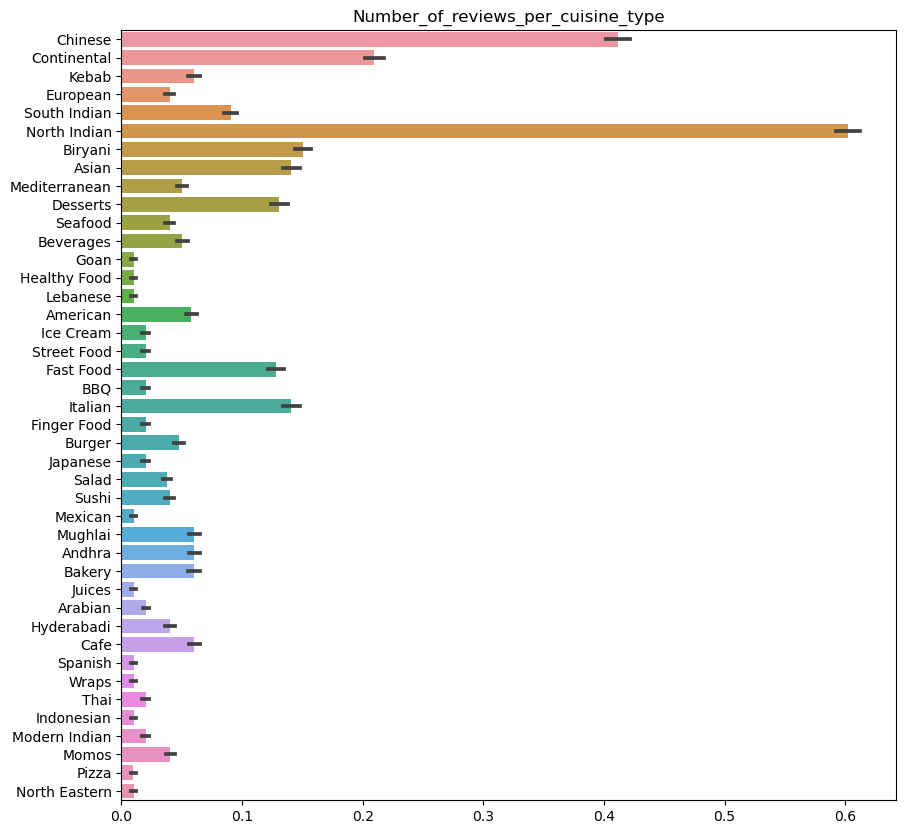

In [67]:
fig = plt.figure(figsize=(10, 10))
plt.title("Number_of_reviews_per_cuisine_type")
sns.barplot(cuisines_explore, orient="h")

In [20]:
preprocessor = pipeline.MainPipeline()
cuisines_explore["Review_preproc"] = cuisines_explore["Review"].apply(lambda x: preprocessor.main_pipeline(x))

In [69]:
cuisines_explore.head(1)

Review  Chinese  Continental  \
0  The ambience was good, food was quite good . h...        1            1   

   Kebab  European  South Indian  North Indian  Biryani  Asian  Mediterranean  \
0      1         1             1             1        0      0              0   

   ...  Cafe  Spanish  Wraps  Thai  Indonesian  Modern Indian  Momos  Pizza  \
0  ...     0        0      0     0           0              0      0      0   

   North Eastern                                     Review_preproc  
0              0  ambience good food quite good saturday lunch c...  

[1 rows x 44 columns]

In [70]:
corpus = []
for cuisine in unique_cuisines:
    cuisine_doc = ""
    for review in cuisines_explore["Review_preproc"].loc[cuisines_explore[cuisine]==1]:        
        cuisine_doc = cuisine_doc + " " + review
    corpus.append(cuisine_doc)

print("Length of unique_cuisines: {}; Length of corpus: {}".format(len(unique_cuisines), len(corpus)))

Length of unique_cuisines: 42; Length of corpus: 42


In [71]:
bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), token_pattern=r"(?u)\b\w+\b")  
wc = WordCloud(background_color="white",max_words=120, width = 220,height = 220, color_func=lambda *args, **kwargs: (0,0,0))

In [72]:
folder_path = "graphs/Multilabel_classification_graphs/Count_Vec"
bigram_count_vectorizer = CountVectorizer(ngram_range=(1,2), token_pattern=r"(?u)\b\w+\b") 

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

for idx, document in enumerate(corpus):
    cuisine_corpus_bigram_count_td_matrix = bigram_count_vectorizer.fit_transform(corpus)
    cuisine_corpus_bigram_count_word_list = bigram_count_vectorizer.get_feature_names_out()

    genre_corpus_vocabulary = pipeline.word_freq_calculator(cuisine_corpus_bigram_count_td_matrix[idx].toarray(),\
                                                                        cuisine_corpus_bigram_count_word_list, df_output=False)
    wc.generate_from_frequencies(genre_corpus_vocabulary)
    wc.to_file(os.path.join(folder_path, "WC_"+unique_cuisines[idx]+"Count_Vectorizer.png"))

In [73]:
folder_path = "graphs/Multilabel_classification_graphs/Tfidf_Vec"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

for idx, document in enumerate(corpus):
    cuisine_corpus_tfidf_td_matrix = bigram_tfidf_vectorizer.fit_transform(corpus)
    cuisine_corpus_tfidf_word_list = bigram_tfidf_vectorizer.get_feature_names_out()

    genre_corpus_vocabulary = pipeline.word_freq_calculator(cuisine_corpus_tfidf_td_matrix[idx].toarray(),\
                                                                        cuisine_corpus_tfidf_word_list, df_output=False)
    wc.generate_from_frequencies(genre_corpus_vocabulary)
    wc.to_file(os.path.join(folder_path, "WC_"+unique_cuisines[idx]+"TFIDF.png"))

In [74]:
# Folder path for saving word clouds
folder_path = "graphs/Multilabel_classification_graphs/Doc2Vec_Vec"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Prepare Doc2Vec
tagged_documents = [TaggedDocument(words=doc.split(" "), tags=[str(i)]) for i, doc in enumerate(corpus)]
doc2vec_model = Doc2Vec(vector_size=200, window=5, min_count=1, workers=4, epochs=10)

# Train Doc2Vec
doc2vec_model.build_vocab(tagged_documents)
doc2vec_model.train(tagged_documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# Initialize WordCloud
wc = WordCloud(background_color="white", width=800, height=400)

# Generate Word Clouds
for idx, doc in enumerate(corpus):
    # Calculate word frequencies
    words = doc.split(" ")
    word_frequencies = {word: words.count(word) for word in set(words)}  # Use word counts as frequencies

    # Generate word cloud
    wc.generate_from_frequencies(word_frequencies)
    wc.to_file(os.path.join(folder_path, f"WC_{unique_cuisines[idx]}_Doc2vec_Vectorizer.png"))


In [25]:
def generate_treemap(data, cuisine_name,output_folder):
    data['pos_tag'] = data['words'].apply(get_pos_tag)

    # Generate the treemap
    fig = px.treemap(
        data[:350], 
        path=[px.Constant('Reviews'), 'pos_tag', 'words'], 
        values='frequency',
        color='frequency',
        color_continuous_scale='viridis',
    )

    # Customize layout
    fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))

    # Save the treemap
    file_path = os.path.join(output_folder, f"{cuisine_name}.png")
    fig.write_image(file_path, format="png")
    print(f"Saved treemap for {cuisine_name} at {file_path}")

In [26]:
#Code to generate a tree map for each cuisine type and store it in a new folder
output_folder = "graphs/Multilabel_classification_graphs/TreeMaps"
os.makedirs(output_folder, exist_ok=True)

for idx, data in enumerate(corpus):
    bow_vectorizer = CountVectorizer()
    data =[data]
    data_bow_td_matrix = bow_vectorizer.fit_transform(data).toarray()
    data_bow_word_list = bow_vectorizer.get_feature_names_out().tolist()
    data_bow_words_freq = pipeline.word_freq_calculator(data_bow_td_matrix, data_bow_word_list)

    cuisine_name = unique_cuisines[idx]
    generate_treemap(data_bow_words_freq, cuisine_name, output_folder)


Saved treemap for Chinese at graphs/Multilabel_classification_graphs/TreeMaps\Chinese.png
Saved treemap for Continental at graphs/Multilabel_classification_graphs/TreeMaps\Continental.png
Saved treemap for Kebab at graphs/Multilabel_classification_graphs/TreeMaps\Kebab.png
Saved treemap for European at graphs/Multilabel_classification_graphs/TreeMaps\European.png
Saved treemap for South Indian at graphs/Multilabel_classification_graphs/TreeMaps\South Indian.png
Saved treemap for North Indian at graphs/Multilabel_classification_graphs/TreeMaps\North Indian.png
Saved treemap for Biryani at graphs/Multilabel_classification_graphs/TreeMaps\Biryani.png
Saved treemap for Asian at graphs/Multilabel_classification_graphs/TreeMaps\Asian.png
Saved treemap for Mediterranean at graphs/Multilabel_classification_graphs/TreeMaps\Mediterranean.png
Saved treemap for Desserts at graphs/Multilabel_classification_graphs/TreeMaps\Desserts.png
Saved treemap for Seafood at graphs/Multilabel_classification_gr

In [75]:
len(unique_cuisines)

42

Observations:
- We have 42 unique cuisine types, with a very unbalanced number of observations, `chinese` and `north indian`have much more reviews than the rest
- The word frequency and Doc2vec the word cloud of each cuisine type is very similar and the tfidf is also similar (slightly more different) in some such as `Andhra` and `North Indian` and `Chinese` for example so it is not expected that the model will distinguish between them very well
- Also by analyzing the tree maps they look all very similar, with only small differences in the less common words but for the most cases the mos common words are all the same
- Overall it is expected that the model will perform much better with tdidf because it is the one that produces the most diverse output out of the three

<font color='#BFD72F' size=4>4.2 Data Preparation</font> <a class="anchor" id="P42"></a>
  
[Back to TOC](#toc)

In [40]:
reviews_multilabel = reviews[["Review", "Cuisine_split"]]
reviews_multilabel.dropna(inplace=True)
reviews_multilabel.head(3)

Review  \
0  The ambience was good, food was quite good . h...   
1  Ambience is too good for a pleasant evening. S...   
2  A must try.. great food great ambience. Thnx f...   

                                       Cuisine_split  
0  [Chinese, Continental, Kebab, European, South ...  
1  [Chinese, Continental, Kebab, European, South ...  
2  [Chinese, Continental, Kebab, European, South ...

In [17]:
mlb = MultiLabelBinarizer()
binarised_labels = mlb.fit_transform(reviews_multilabel["Cuisine_split"])
reviews_multilabel["Cuisine_binary"] = binarised_labels.tolist()

In [18]:
reviews_multilabel.head(3)

Review  \
0  The ambience was good, food was quite good . h...   
1  Ambience is too good for a pleasant evening. S...   
2  A must try.. great food great ambience. Thnx f...   

                                       Cuisine_split  \
0  [Chinese, Continental, Kebab, European, South ...   
1  [Chinese, Continental, Kebab, European, South ...   
2  [Chinese, Continental, Kebab, European, South ...   

                                      Cuisine_binary  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ...

In [19]:
X_train, X_test, y_train, y_test = train_test_split(reviews_multilabel["Review"], binarised_labels,
                                                    test_size=0.3, random_state=42, shuffle = True, stratify = binarised_labels)

In [20]:
X_train

8453    One word YUKk !!! Uncooked, smelly grilled pra...
572     Goa in Hyderabad!! These guys have cracked thi...
1708    I ordered Afghani chicken from here but I got ...
344     Me and my friends has a mandi at Shah Ghouse r...
5699    Very good and service from Varsha and very goo...
                              ...                        
6519    and this place iss just marvelous. perfct dini...
7808    Food was nice and good staff supportive .ambie...
9063    Nice place to chill out with good food at Affo...
4665    This is my favorite restaurant always... But i...
9473    2018 is the first time I had chance to eat don...
Name: Review, Length: 6968, dtype: object

In [21]:
y_train

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

<font color='#BFD72F' size=4>4.3 Model Preparation</font> <a class="anchor" id="P43"></a>
  
[Back to TOC](#toc)

In [22]:
class HermeticClassifier(ClassifierMixin, BaseEstimator):

    def __init__(self, preprocessor, vectorizer, classifier, d2v_vector_size=300, d2v_window=6, **kwargs):
        self.preprocessor = preprocessor
        self.vectorizer = vectorizer
        self.classifier = classifier
        self.d2v_vector_size = d2v_vector_size
        self.d2v_window = d2v_window

    def fit(self, X, y, **kwargs):

        X_preproc = [self.preprocessor.main_pipeline(doc, **kwargs) for doc in X]

        try:
            X_train = self.vectorizer.fit_transform(X_preproc)
        except AttributeError:
            documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X)]
            self.d2v_model = self.vectorizer(documents, vector_size=300, window=6, min_count=1, workers=4)
            X_train = [self.d2v_model.dv[idx].tolist() for idx in range(len(X_preproc))]

        y_train = y
            
        try:
            X_train = X_train.toarray()
        except AttributeError:
            pass
        try:
            y_train = y_train.to_numpy()
        except AttributeError:
            pass

        #X_train, y_train = check_X_y(X_train, y_train)

        self.classifier.fit(X_train, y_train)

        self.X_ = X_train
        self.y_ = y_train

        return self

    def predict(self, X_test_raw, **kwargs):

        # Check if fit has been called
        check_is_fitted(self)

        X_test = [self.preprocessor.main_pipeline(doc, **kwargs) for doc in X_test_raw]

        try:
            X_test = self.vectorizer.transform(X_test)
        except AttributeError:
            X_test = [self.d2v_model.infer_vector(word_tokenize(content)).tolist() for content in X_test]

        try:
            X_test = check_array(X_test.toarray())
        except AttributeError:
            X_test = check_array(X_test)
            
        y_pred = self.classifier.predict(X_test)

        return y_pred
    def score(self, X, y, **kwargs):
        y_pred = self.predict(X, **kwargs)
        return f1_score(y, y_pred, average='weighted')

<font color='#BFD72F' size=4>4.4 Random searches</font> <a class="anchor" id="P44"></a>
  
[Back to TOC](#toc)

In [58]:
bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), token_pattern=r"(?u)\b\w+\b")

ml_ovr = OneVsRestClassifier(LogisticRegression())  
preprocessor = pipeline.MainPipeline()

hermetic_classifier = HermeticClassifier(preprocessor, bigram_tfidf_vectorizer, ml_ovr)

# Parameter distribution for RandomizedSearchCV
param_dist = {
    'preprocessor__no_stopwords': [True, False],
    'preprocessor__lemmatized': [True, False],
    'preprocessor__lowercase': [True, False],
    'vectorizer': [bigram_tfidf_vectorizer],
    'classifier': [ml_ovr],  
    'classifier__estimator__C': uniform(1e-5, 100),  # Regularization strength for LogisticRegression
    'classifier__estimator__penalty': ['l1', 'l2'],  # Penalty type
    'classifier__estimator__solver': ['liblinear', 'saga'],  # Compatible solvers
    'classifier__estimator__class_weight': [None, 'balanced'],
    'd2v_window': randint(3, 16),  # Doc2Vec window size
}

randomized_search = RandomizedSearchCV(
    hermetic_classifier, 
    param_distributions=param_dist, 
    n_iter=10,  
    cv=5,  
    verbose=4,  
    n_jobs=4,  
    random_state=42  
)

randomized_search.fit(X_train, y_train)

print("Best Parameters:", randomized_search.best_params_)
print("Best Score:", randomized_search.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'classifier': OneVsRestClassifier(estimator=LogisticRegression()), 'classifier__estimator__C': 37.45402188473625, 'classifier__estimator__class_weight': None, 'classifier__estimator__penalty': 'l1', 'classifier__estimator__solver': 'liblinear', 'd2v_window': 10, 'preprocessor__lemmatized': True, 'preprocessor__lowercase': True, 'preprocessor__no_stopwords': True, 'vectorizer': TfidfVectorizer(ngram_range=(1, 2), token_pattern='(?u)\\b\\w+\\b')}
Best Score: 0.5755813530524


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Best Parameters: {'classifier': OneVsRestClassifier(estimator=LogisticRegression()), 'classifier__estimator__C': 37.45402188473625, 'classifier__estimator__class_weight': None, 'classifier__estimator__penalty': 'l1', 'classifier__estimator__solver': 'liblinear', 'd2v_window': 10, 'preprocessor__lemmatized': True, 'preprocessor__lowercase': True, 'preprocessor__no_stopwords': True, 'vectorizer': TfidfVectorizer(ngram_range=(1, 2), token_pattern='(?u)\\b\\w+\\b')}


Best Score: 0.5755813530524

Run time: 1643m 28.6s

In [61]:
bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), token_pattern=r"(?u)\b\w+\b")

rf_ovr = OneVsRestClassifier(RandomForestClassifier())

preprocessor = pipeline.MainPipeline()

hermetic_classifier = HermeticClassifier(preprocessor, bigram_tfidf_vectorizer, rf_ovr)

# Parameter distribution for RandomizedSearchCV
parameter_grid = {
    'preprocessor__no_stopwords': [True, False],
    'preprocessor__lemmatized': [True, False],
    'preprocessor__lowercase': [True, False],
    'vectorizer': [bigram_tfidf_vectorizer],
    'classifier': [rf_ovr],  # Ensure it uses RandomForestClassifier
    'classifier__estimator__n_estimators': [50, 100, 200],
    'classifier__estimator__max_depth': [None, 10, 20],
    'classifier__estimator__min_samples_split': [2, 5, 10],
    'classifier__estimator__min_samples_leaf': [1, 2, 4],
    'classifier__estimator__class_weight': [None, 'balanced'],
    'classifier__estimator__random_state': [42],
}


rand_result_ovr2 = RandomizedSearchCV(
    hermetic_classifier,
    param_distributions=parameter_grid,
    n_iter=5,  
    verbose=4,
    cv=3,  
    n_jobs=4  
).fit(X_train, y_train)

print("Best Parameters:", rand_result_ovr2.best_params_)
print("Best Score:", rand_result_ovr2.best_score_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'vectorizer': TfidfVectorizer(ngram_range=(1, 2), token_pattern='(?u)\\b\\w+\\b'), 'preprocessor__no_stopwords': True, 'preprocessor__lowercase': False, 'preprocessor__lemmatized': True, 'classifier__estimator__random_state': 42, 'classifier__estimator__n_estimators': 100, 'classifier__estimator__min_samples_split': 2, 'classifier__estimator__min_samples_leaf': 4, 'classifier__estimator__max_depth': 20, 'classifier__estimator__class_weight': 'balanced', 'classifier': OneVsRestClassifier(estimator=RandomForestClassifier())}
Best Score: 0.48306457257527874


Here we only did fewer iterations and folds to not spend so much time running the Random Search


Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best Parameters: {'vectorizer': TfidfVectorizer(ngram_range=(1, 2), token_pattern='(?u)\\b\\w+\\b'), 'preprocessor__no_stopwords': True, 'preprocessor__lowercase': False, 'preprocessor__lemmatized': True, 'classifier__estimator__random_state': 42, 'classifier__estimator__n_estimators': 100, 'classifier__estimator__min_samples_split': 2, 'classifier__estimator__min_samples_leaf': 4, 'classifier__estimator__max_depth': 20, 'classifier__estimator__class_weight': 'balanced', 'classifier': OneVsRestClassifier(estimator=RandomForestClassifier())}

Best Score: 0.48306457257527874

Run time: 227m 22.4s

In [ ]:
tfidf_vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")


ml_rd_cc = ClassifierChain(LogisticRegression(), order = "random") #order is random because finding out what the best order is would take a lot of time

hermetic_classifier = HermeticClassifier(preprocessor, tfidf_vectorizer, ml_rd_cc)

# Parameter distribution for RandomizedSearchCV
param_dist = {
    'preprocessor__no_stopwords': [True, False],
    'preprocessor__lemmatized': [True, False],
    'preprocessor__lowercase': [True, False],
    'vectorizer': [tfidf_vectorizer],
    'classifier': [ml_rd_cc],  
    'classifier__base_estimator__C': uniform(1e-5, 100),  
    'classifier__base_estimator__penalty': ['l1', 'l2'],  
    'classifier__base_estimator__solver': ['liblinear', 'saga'],  
    'classifier__base_estimator__class_weight': [None, 'balanced'],
    'classifier__random_state': [42],
    'd2v_vector_size': [200],
    'd2v_window': randint(3, 16), 
}

randomized_search = RandomizedSearchCV(
    hermetic_classifier, 
    param_distributions=param_dist, 
    n_iter=10,  
    cv=5,  
    verbose=4,  
    n_jobs=4,  
    random_state=42,  
)

rand_result_cc = randomized_search.fit(X_train, y_train)

print("Best Parameters:", rand_result_cc.best_params_)
print("Best Score:", rand_result_cc.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'classifier': ClassifierChain(base_estimator=LogisticRegression(C=43.19451186421158,
                                                  penalty='l1',
                                                  solver='liblinear'),
                order='random', random_state=42), 'classifier__base_estimator__C': 43.19451186421158, 'classifier__base_estimator__class_weight': None, 'classifier__base_estimator__penalty': 'l1', 'classifier__base_estimator__solver': 'liblinear', 'classifier__random_state': 42, 'd2v_vector_size': 200, 'd2v_window': 12, 'preprocessor__lemmatized': False, 'preprocessor__lowercase': False, 'preprocessor__no_stopwords': False, 'vectorizer': TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b')}
Best Score: 0.5483608715856629


Firstly this random search despite similar to the one with LogisticRegression in OnevsRestClassifier, doesn't have the number of n-grams being tested it is just assumed that it is one-gram, this because we thought that having another model running for more than 1600 min was too much, we couldn't afford to lose another day and 3 hours

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Parameters: {'classifier': ClassifierChain(base_estimator=LogisticRegression(C=43.19451186421158,
                                                  penalty='l1',
                                                  solver='liblinear'),
                order='random', random_state=42), 'classifier__base_estimator__C': 43.19451186421158, 'classifier__base_estimator__class_weight': None, 'classifier__base_estimator__penalty': 'l1', 'classifier__base_estimator__solver': 'liblinear', 'classifier__random_state': 42, 'd2v_vector_size': 200, 'd2v_window': 12, 'preprocessor__lemmatized': False, 'preprocessor__lowercase': False, 'preprocessor__no_stopwords': False, 'vectorizer': TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b')}

Best Score: 0.5483608715856629

Running time: 200m 0.9s

In [52]:
bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), token_pattern=r"(?u)\b\w+\b")
rf_chain = ClassifierChain(RandomForestClassifier(), order="random")
hermetic_classifier_chain = HermeticClassifier(preprocessor, bigram_tfidf_vectorizer, rf_chain)

# Parameter distribution for RandomizedSearchCV
parameter_grid_chain = {
    'preprocessor__no_stopwords': [True, False],
    'preprocessor__lemmatized': [True, False],
    'preprocessor__lowercase': [True, False],
    'vectorizer': [bigram_tfidf_vectorizer],
    'classifier': [rf_chain],
    'classifier__base_estimator__n_estimators': [50, 100, 200],
    'classifier__base_estimator__max_depth': [None, 10, 20],
    'classifier__base_estimator__min_samples_split': [2, 5, 10],
    'classifier__base_estimator__min_samples_leaf': [1, 2, 4],
    'classifier__base_estimator__class_weight': [None, 'balanced'],
    'classifier__base_estimator__random_state': [42],
}

rand_result_chain = RandomizedSearchCV(
    hermetic_classifier_chain,
    param_distributions=parameter_grid_chain,
    n_iter=5,  
    verbose=4,
    cv=3,  
    n_jobs=4  
).fit(X_train, y_train)

print("Best Parameters:", rand_result_chain.best_params_)
print("Best Score:", rand_result_chain.best_score_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'vectorizer': TfidfVectorizer(ngram_range=(1, 2), token_pattern='(?u)\\b\\w+\\b'), 'preprocessor__no_stopwords': True, 'preprocessor__lowercase': False, 'preprocessor__lemmatized': True, 'classifier__base_estimator__random_state': 42, 'classifier__base_estimator__n_estimators': 200, 'classifier__base_estimator__min_samples_split': 2, 'classifier__base_estimator__min_samples_leaf': 4, 'classifier__base_estimator__max_depth': 20, 'classifier__base_estimator__class_weight': 'balanced', 'classifier': ClassifierChain(base_estimator=RandomForestClassifier(), order='random')}
Best Score: 0.47419235311410884


Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best Parameters: {'vectorizer': TfidfVectorizer(ngram_range=(1, 2), token_pattern='(?u)\\b\\w+\\b'), 'preprocessor__no_stopwords': True, 'preprocessor__lowercase': False, 'preprocessor__lemmatized': True, 'classifier__base_estimator__random_state': 42, 'classifier__base_estimator__n_estimators': 200, 'classifier__base_estimator__min_samples_split': 2, 'classifier__base_estimator__min_samples_leaf': 4, 'classifier__base_estimator__max_depth': 20, 'classifier__base_estimator__class_weight': 'balanced', 'classifier': ClassifierChain(base_estimator=RandomForestClassifier(), order='random')}

Best Score: 0.47419235311410884

Run time: 205m 57.1

It was only done 4 random searches (2 for `LogisticRegression` one for `ClassifierChain` and one for `OnevsRestClassifier` each with 10 iterations and 5 folds, 2 for `RandomForestClassifier` one for `ClassifierChain` and one for `OnevsRestClassifier` each with 5 iterations and 3 folds), totalizing a total of 80 runs and a total run time of more than 2200 min, approximately more than a day and a half.

- The random searches all only used TF-IDF as in the trial and error phase we tried before running the random searches using TF-IDF seemed to always lead to better results
- They had to be done separately because the name of some parameters was different from one to another and would lead to errors if made all  models in one random search, also it is easier to accompany the results
- It could not be grid searches because there was an incredibly high number of different models that would be run and each had to run 3 or 5 times leading to run times too big to be possible to run, we only ran 80 time and it was more than a day if we used gridsearches we would need to run the models for at least 8000 time so we would expect tha we needed at least 15 days to run it all what would be unfeasible
- Only a few models were searched for each random search as the random searches already took the other running and increasing the number of models to search was not seen as rewarding enough:
    - Increasing by only a few amount of models (5 each for example) wouldn't likely improve much the results obtained and would lead to an overall run time of more approximately 194min which is more than 3h
    - Increasing by a moderate/big amount of models (like 30/40 or 200 each) would still be considerate a small number having in consideration the number total of possible of combinations, but would potentially lead to slightly better results however run times would be higher than 24h for the moderate case and higher than 5 days for the big case 
- Also the `ClassifierChain` with the `LogisticRegression` was only run with ngrams equal to 1 instead of (1,2) as it would take a lot more time to run, approximately the same 1600 minutes it took to run the similar model with `OnevsRestClassifier` and we couldn't afford it

<font color='#BFD72F' size=4>4.5 OneVsRest LogisticRegression Model (best version from random search)</font> <a class="anchor" id="P45"></a>
  
[Back to TOC](#toc)

In [23]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), token_pattern='(?u)\\b\\w+\\b') 
lg_ovrc = OneVsRestClassifier(estimator=LogisticRegression(C=37.45402188473625,
                                                 penalty='l1', random_state=42,
                                                 solver='liblinear', class_weight=None)) 
preprocessor = pipeline.MainPipeline(lemmatized=True, lowercase= True, no_stopwords= True)

hermetic_classifier_ovrc = HermeticClassifier(preprocessor, tfidf_vectorizer, lg_ovrc, n_jobs= 4, d2v_vector_size= 200, d2v_window= 10)

In [24]:
hermetic_classifier_ovrc.fit(X_train,y_train)

HermeticClassifier(classifier=OneVsRestClassifier(estimator=LogisticRegression(C=37.45402188473625,
                                                                               penalty='l1',
                                                                               random_state=42,
                                                                               solver='liblinear')),
                   d2v_vector_size=200, d2v_window=10,
                   preprocessor=MainPipeline(),
                   vectorizer=TfidfVectorizer(ngram_range=(1, 2),
                                              token_pattern='(?u)\\b\\w+\\b'))

##### Model Evaluation (on never before seen data)


In [25]:
y_pred_ovrc = hermetic_classifier_ovrc.predict(X_test)

In [26]:
pipeline.fold_score_calculator(y_pred_ovrc ,y_test, verbose=True)

Accuracy: 0.20220957482423838 
Precision: 0.6370722561945209 
Recall: 0.5421901056142301 
F1: 0.577512414848068


(0.20220957482423838,
 0.6370722561945209,
 0.5421901056142301,
 0.577512414848068)

In [28]:
report = classification_report(y_test, y_pred_ovrc, target_names=mlb.classes_, output_dict=True)

# Build a DataFrame using a list comprehension
f1_df = pd.DataFrame([
    {"Class Name": class_name, "F1 Score Logistic OnevsRest": f"{report[class_name]['f1-score']:.4f}"}
    for class_name in mlb.classes_
])



<font color='#BFD72F' size=4>4.6 OneVsRest RandomForest Model (best version from random search)</font> <a class="anchor" id="P46"></a>
  
[Back to TOC](#toc)

In [30]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), token_pattern='(?u)\\b\\w+\\b') 
rf_ovrc = OneVsRestClassifier(estimator=RandomForestClassifier(n_estimators = 100,
                                                 min_samples_split = 2, random_state=42,
                                                 min_samples_leaf = 4, max_depth = 20, class_weight="balanced")) 
preprocessor = pipeline.MainPipeline(lemmatized=True, lowercase= False, no_stopwords= True)

hermetic_classifier_rf_ovrc = HermeticClassifier(preprocessor, tfidf_vectorizer, rf_ovrc, n_jobs= 4, d2v_vector_size= 200, d2v_window= 10)

In [31]:
hermetic_classifier_rf_ovrc.fit(X_train,y_train)

HermeticClassifier(classifier=OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                                                   max_depth=20,
                                                                                   min_samples_leaf=4,
                                                                                   random_state=42)),
                   d2v_vector_size=200, d2v_window=10,
                   preprocessor=MainPipeline(lowercase=False),
                   vectorizer=TfidfVectorizer(ngram_range=(1, 2),
                                              token_pattern='(?u)\\b\\w+\\b'))

##### Model Evaluation (on never before seen data)


In [32]:
y_pred_rf_ovrc = hermetic_classifier_rf_ovrc.predict(X_test)

In [33]:
pipeline.fold_score_calculator(y_pred_rf_ovrc ,y_test, verbose=True)

Accuracy: 0.054904586541680615 
Precision: 0.480786745608166 
Recall: 0.610005558643691 
F1: 0.5147632962446372


(0.054904586541680615,
 0.480786745608166,
 0.610005558643691,
 0.5147632962446372)

In [34]:
class_names = mlb.classes_
report = classification_report(y_test, y_pred_rf_ovrc, target_names=class_names, output_dict=True)

f1_score_dict = {class_name: f"{report[class_name]['f1-score']:.4f}" for class_name in class_names}

# Join the new data to the dataset
f1_df["F1 Score RandomForest OnevsRest"] = f1_df["Class Name"].map(f1_score_dict)

<font color='#BFD72F' size=4>4.7 ClassifierChain LogisticRegression Model (best version from random search)</font> <a class="anchor" id="P47"></a>
  
[Back to TOC](#toc)

In this one we will create 2 models just to test if the best model from the random search with only ngrams = (1,1) is better or worse than the same model but with ngrams = (1,2)

Model 1 is the one from the random search, and model 2 is the one with ngrams = (1,2)

In [36]:
tfidf_vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b") 
ml_cc =ClassifierChain(base_estimator=LogisticRegression(C=43.19451186421158,
                                                  penalty='l1',
                                                  solver='liblinear', class_weight= None, random_state=42),
                                                    order='random') 
preprocessor = pipeline.MainPipeline(lemmatized=False, lowercase= False, no_stopwords= False)

hermetic_classifier_cc = HermeticClassifier(preprocessor, tfidf_vectorizer, ml_cc, n_jobs= 4, d2v_vector_size= 200, d2v_window= 12)

In [41]:
tfidf_vectorizer2 = TfidfVectorizer(ngram_range=(1,2), token_pattern=r"(?u)\b\w+\b") 
ml_cc2 =ClassifierChain(base_estimator=LogisticRegression(C=43.19451186421158,
                                                  penalty='l1',
                                                  solver='liblinear', class_weight= None, random_state=42),
                                                    order='random') 
preprocessor2 = pipeline.MainPipeline(lemmatized=False, lowercase= False, no_stopwords= False)

hermetic_classifier_cc2 = HermeticClassifier(preprocessor2, tfidf_vectorizer2, ml_cc2, n_jobs= 4, d2v_vector_size= 200, d2v_window= 12)

In [37]:
hermetic_classifier_cc.fit(X_train,y_train)

HermeticClassifier(classifier=ClassifierChain(base_estimator=LogisticRegression(C=43.19451186421158,
                                                                                penalty='l1',
                                                                                random_state=42,
                                                                                solver='liblinear'),
                                              order='random'),
                   d2v_vector_size=200, d2v_window=12,
                   preprocessor=MainPipeline(lemmatized=False, lowercase=False,
                                             no_stopwords=False),
                   vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'))

In [42]:
hermetic_classifier_cc2.fit(X_train,y_train)

HermeticClassifier(classifier=ClassifierChain(base_estimator=LogisticRegression(C=43.19451186421158,
                                                                                penalty='l1',
                                                                                random_state=42,
                                                                                solver='liblinear'),
                                              order='random'),
                   d2v_vector_size=200, d2v_window=12,
                   preprocessor=MainPipeline(lemmatized=False, lowercase=False,
                                             no_stopwords=False),
                   vectorizer=TfidfVectorizer(ngram_range=(1, 2),
                                              token_pattern='(?u)\\b\\w+\\b'))

##### Model Evaluation (on never before seen data)

In [38]:
y_pred_cc = hermetic_classifier_cc.predict(X_test)

In [39]:
pipeline.fold_score_calculator(y_pred_cc ,y_test, verbose=True)

Accuracy: 0.2480749916303984 
Precision: 0.5691786092142267 
Recall: 0.5167315175097277 
F1: 0.5345543773827309


(0.2480749916303984,
 0.5691786092142267,
 0.5167315175097277,
 0.5345543773827309)

In [43]:
y_pred_cc2 = hermetic_classifier_cc2.predict(X_test)

In [44]:
pipeline.fold_score_calculator(y_pred_cc2 ,y_test, verbose=True)

Accuracy: 0.24673585537328424 
Precision: 0.5741396313887627 
Recall: 0.5221789883268483 
F1: 0.5384671919236018


(0.24673585537328424,
 0.5741396313887627,
 0.5221789883268483,
 0.5384671919236018)

Results are very similar therefore we can conclude that the model 1 is better as it only has a weighted f1 score 0.04 smaller and takes minus 9 min to run so it is way more efficient 

In [45]:
class_names = mlb.classes_
report = classification_report(y_test, y_pred_cc, target_names=class_names, output_dict=True)

f1_score_dict = {class_name: f"{report[class_name]['f1-score']:.4f}" for class_name in class_names}

# Join the new data to the dataset
f1_df["F1 Score Logistic ClassifierChain"] = f1_df["Class Name"].map(f1_score_dict)

<font color='#BFD72F' size=4>4.8 ClassifierChain RandomForest Model (best version from random search)</font> <a class="anchor" id="P48"></a>
  
[Back to TOC](#toc)

In [47]:
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,2), token_pattern=r"(?u)\b\w+\b") 
rf_cc =ClassifierChain(base_estimator=RandomForestClassifier(n_estimators = 200,
                                                  min_samples_split = 2,
                                                  min_samples_leaf = 4, max_depth = 20, class_weight = 'balanced', random_state=42),
                                                    order='random') 
preprocessor = pipeline.MainPipeline(lemmatized=True, lowercase= False, no_stopwords= True)

hermetic_classifier_rf_cc = HermeticClassifier(preprocessor, tfidf_vectorizer, rf_cc, n_jobs= 4, d2v_vector_size= 200, d2v_window= 12)

In [48]:
hermetic_classifier_rf_cc.fit(X_train,y_train)

HermeticClassifier(classifier=ClassifierChain(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                                                    max_depth=20,
                                                                                    min_samples_leaf=4,
                                                                                    n_estimators=200,
                                                                                    random_state=42),
                                              order='random'),
                   d2v_vector_size=200, d2v_window=12,
                   preprocessor=MainPipeline(lowercase=False),
                   vectorizer=TfidfVectorizer(ngram_range=(1, 2),
                                              token_pattern='(?u)\\b\\w+\\b'))

##### Model Evaluation (on never before seen data)

In [49]:
y_pred_rf_cc = hermetic_classifier_rf_cc.predict(X_test)

In [50]:
pipeline.fold_score_calculator(y_pred_rf_cc ,y_test, verbose=True)

Accuracy: 0.05959156344158018 
Precision: 0.4930042408162306 
Recall: 0.6200111172873819 
F1: 0.5224114281200546


(0.05959156344158018,
 0.4930042408162306,
 0.6200111172873819,
 0.5224114281200546)

In [51]:
class_names = mlb.classes_
report = classification_report(y_test, y_pred_rf_cc, target_names=class_names, output_dict=True)

f1_score_dict = {class_name: f"{report[class_name]['f1-score']:.4f}" for class_name in class_names}

# Join the new data to the dataset
f1_df["F1 Score RandomForest ClassifierChain"] = f1_df["Class Name"].map(f1_score_dict)

<font color='#BFD72F' size=4>4.9 Intermediate Conclusions (comparison between models)</font> <a class="anchor" id="P49"></a>
  
[Back to TOC](#toc)

In [52]:
f1_df

Class Name F1 Score Logistic OnevsRest F1 Score RandomForest OnevsRest  \
0        American                      0.6373                          0.4236   
1          Andhra                      0.3056                          0.2411   
2         Arabian                      0.2250                          0.1839   
3           Asian                      0.5499                          0.5216   
4             BBQ                      0.6078                          0.2676   
5          Bakery                      0.6545                          0.5619   
6       Beverages                      0.5344                          0.4453   
7         Biryani                      0.4403                          0.4351   
8          Burger                      0.5798                          0.2370   
9            Cafe                      0.5761                          0.4593   
10        Chinese                      0.6489                          0.6631   
11    Continental                      0.5655                          0.5359   
12       Desserts                      0.5953                          0.5375   
13       European                      0.6570                          0.3251   
14      Fast Food                      0.5182                          0.4277   
15    Finger Food                      0.2264                          0.1493   
16           Goan                      0.5714                          0.2162   
17   Healthy Food                      0.4000                          0.3077   
18     Hyderabadi                      0.1899                          0.1727   
19      Ice Cream                      0.5000                          0.3317   
20     Indonesian                      0.3182                          0.0588   
21        Italian                      0.5124                          0.4678   
22       Japanese                      0.3696                          0.1944   
23         Juices                      0.4082                          0.0000   
24          Kebab                      0.3673                          0.2442   
25       Lebanese                      0.4706                          0.2740   
26  Mediterranean                      0.5993                          0.4468   
27        Mexican                      0.1176                          0.1860   
28  Modern Indian                      0.6214                          0.3521   
29          Momos                      0.5592                          0.4593   
30        Mughlai                      0.4281                          0.3894   
31  North Eastern                      0.6786                          0.4103   
32   North Indian                      0.8123                          0.8062   
33          Pizza                      0.2667                          0.0894   
34          Salad                      0.3214                          0.1879   
35        Seafood                      0.3497                          0.3212   
36   South Indian                      0.3981                          0.2869   
37        Spanish                      0.4727                          0.1622   
38    Street Food                      0.2581                          0.1218   
39          Sushi                      0.4677                          0.3377   
40           Thai                      0.3125                          0.2118   
41          Wraps                      0.5185                          0.3556   

   F1 Score Logistic ClassifierChain F1 Score RandomForest ClassifierChain  
0                             0.5902                                0.4536  
1                             0.2789                                0.2187  
2                             0.1926                                0.1067  
3                             0.5126                                0.5035  
4                             0.5116                                0.3740  
5                             0.6361                         

Comparing the models (deemed the best from each random search):
- The `OneVsRest Logistic Classifier` has accuracy: 0.20220957482423838, precision: 0.6370722561945209, recall: 0.5421901056142301, f1: 0.577512414848068 (all measures are weighted)
- The `OneVsRest RandomForest Classifier` has accuracy: 0.054904586541680615, precision: 0.480786745608166, recall: 0.610005558643691, f1: 0.5147632962446372 (all measures are weighted)
- The `Logistic ClassifierChain` has accuracy: 0.2480749916303984, precision: 0.5691786092142267, recall: 0.5167315175097277, f1: 0.5345543773827309 (all measures are weighted)
- The `RandomForest ClassifierChain` has accuracy: 0.05959156344158018, precision: 0.4930042408162306, recall: 0.6200111172873819, f1: 0.5224114281200546(all measures are weighted)
- As we have unbalanced data, we shouldn't consider accuracy as a meaningful evaluation method, instead we should pay more attention to the weighted f1 score
- As the weighted f1 score of the `OneVsRest Logistic Classifier` is higher we can conclude that out of the two models it is the best, which can also be seen by analyzing the f1 score per class as it predicts almost all classes better than any other of the models.

As we have conclude that `OneVsRest Logistic Classifier` is the best model we will use this one to analyze the results per class:
- North Indian is the cuisine type with the best f1 score (0.8123) which was expected as it is the most common cuisine type
- Mexican is the cuisine type with the worst f1 score (0.1176)
- South Indian has a low f1 score (0.3981) which was expected as it is very similar to North Indian in terms of reviews context

<font color='#BFD72F' size=4>4.10 Dummy Classifier (baseline model)</font> <a class="anchor" id="P410"></a>
  
[Back to TOC](#toc)

The dummy has ngrams = (1,2) because the best and also most of the models had, and so that the dummy is more similar to them

In [53]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), token_pattern=r"(?u)\b\w+\b") 
dummy_classifier =OneVsRestClassifier(DummyClassifier(random_state=42)) 

preprocessor = pipeline.MainPipeline(lemmatized=False, lowercase= False, no_stopwords= False)

hermetic_classifier_dummy = HermeticClassifier(preprocessor, tfidf_vectorizer, dummy_classifier, n_jobs= 4, d2v_vector_size= 200, d2v_window= 12)

In [55]:
hermetic_classifier_dummy.fit(X_train,y_train)

HermeticClassifier(classifier=OneVsRestClassifier(estimator=DummyClassifier(random_state=42)),
                   d2v_vector_size=200, d2v_window=12,
                   preprocessor=MainPipeline(lemmatized=False, lowercase=False,
                                             no_stopwords=False),
                   vectorizer=TfidfVectorizer(ngram_range=(1, 2),
                                              token_pattern='(?u)\\b\\w+\\b'))

##### Model Evaluation (on never before seen data)

In [56]:
y_pred_dummy = hermetic_classifier_dummy.predict(X_test)

In [57]:
pipeline.fold_score_calculator(y_pred_dummy ,y_test, verbose=True)

Accuracy: 0.03013056578506863 
Precision: 0.12045530632741883 
Recall: 0.2 
F1: 0.1503552026744672


(0.03013056578506863, 0.12045530632741883, 0.2, 0.1503552026744672)

In [58]:
class_names = mlb.classes_
report = classification_report(y_test, y_pred_dummy, target_names=class_names, output_dict=True)

f1_score_dict = {class_name: f"{report[class_name]['f1-score']:.4f}" for class_name in class_names}

# Join the new data to the dataset
f1_df["F1 Score Dummy Classifier"] = f1_df["Class Name"].map(f1_score_dict)

<font color='#BFD72F' size=4>4.11 Final Conclusions (comparison of best model and baseline)</font> <a class="anchor" id="P411"></a>
  
[Back to TOC](#toc)

In [59]:
f1_df

Class Name F1 Score Logistic OnevsRest F1 Score RandomForest OnevsRest  \
0        American                      0.6373                          0.4236   
1          Andhra                      0.3056                          0.2411   
2         Arabian                      0.2250                          0.1839   
3           Asian                      0.5499                          0.5216   
4             BBQ                      0.6078                          0.2676   
5          Bakery                      0.6545                          0.5619   
6       Beverages                      0.5344                          0.4453   
7         Biryani                      0.4403                          0.4351   
8          Burger                      0.5798                          0.2370   
9            Cafe                      0.5761                          0.4593   
10        Chinese                      0.6489                          0.6631   
11    Continental                      0.5655                          0.5359   
12       Desserts                      0.5953                          0.5375   
13       European                      0.6570                          0.3251   
14      Fast Food                      0.5182                          0.4277   
15    Finger Food                      0.2264                          0.1493   
16           Goan                      0.5714                          0.2162   
17   Healthy Food                      0.4000                          0.3077   
18     Hyderabadi                      0.1899                          0.1727   
19      Ice Cream                      0.5000                          0.3317   
20     Indonesian                      0.3182                          0.0588   
21        Italian                      0.5124                          0.4678   
22       Japanese                      0.3696                          0.1944   
23         Juices                      0.4082                          0.0000   
24          Kebab                      0.3673                          0.2442   
25       Lebanese                      0.4706                          0.2740   
26  Mediterranean                      0.5993                          0.4468   
27        Mexican                      0.1176                          0.1860   
28  Modern Indian                      0.6214                          0.3521   
29          Momos                      0.5592                          0.4593   
30        Mughlai                      0.4281                          0.3894   
31  North Eastern                      0.6786                          0.4103   
32   North Indian                      0.8123                          0.8062   
33          Pizza                      0.2667                          0.0894   
34          Salad                      0.3214                          0.1879   
35        Seafood                      0.3497                          0.3212   
36   South Indian                      0.3981                          0.2869   
37        Spanish                      0.4727                          0.1622   
38    Street Food                      0.2581                          0.1218   
39          Sushi                      0.4677                          0.3377   
40           Thai                      0.3125                          0.2118   
41          Wraps                      0.5185                          0.3556   

   F1 Score Logistic ClassifierChain F1 Score RandomForest ClassifierChain  \
0                             0.5902                                0.4536   
1                             0.2789                                0.2187   
2                             0.1926                                0.1067   
3                             0.5126                                0.5035   
4                             0.5116                                0.3740   
5                             0.6361                   

Conclusions on how well we can classify the cuisine type of a restaurant based on its reviews:
- The base line model has performed with this results: accuracy: 0.03013056578506863, precision: 0.12045530632741883, recall: 0.2 and f1: 0.1503552026744672 (all measures are weighted)
- Focusing on the weighted f1 score we can see that the model chosen by us has a score almost 5 times bigger than the baseline (0.577512414848068)
- This means that our model has performed much better than the baseline, however it's still very far away from being a "good" model, this can be explained by the fact that reviews don't often are very useful to know what the cuisine type of a restaurant is. As a big part of them is just comments on if their experience was good or bad and not really a description of what they ate, this only corresponds to a small part of reviews
- If we look at the f1 scores per cuisine type our results seem much better than the baseline dummy models as it fails to predict every class except for North Indian, having a 0.75 f1 score in that class and 0 score in all other, just for the simple fact that our model is able to correctly predict most classes some times it is already a big win comparing to the baseline and we also are able to predict North Indian	cuisine better than the baseline (f1 score in our model 0.81, in the baseline model 0.75)
- Concluding:
    - Our model is much better than a basic Dummy Classifier meaning we can classify the cuisine type of a restaurant based on its reviews way better than just using a random model
    - The results obtained were good considering the circumstances as these was a sort of garbage in garbage out model, as it was said before reviews aren't the best thing to base a model to predict cuisine types


<font color='#BFD72F' size=5>5. Co-occurrence Analysis; Clustering</font> <a class="anchor" id="P5"></a>
  
[Back to TOC](#toc)

#### What dishes are mentioned together in the reviews? Do they form clusters? Can you identify cuisine types based on those clusters? 

<font color='#BFD72F' size=4>5.1 Data preparation and some data exploration</font> <a class="anchor" id="P51"></a>
  
[Back to TOC](#toc)

In [41]:
dishes = [
    # Bread and Baked Goods
    "bread", "roll", "bun", "bagel", "croissant", "pita", "flatbread", "naan", "tortilla", "loaf", "crust", "brioche",
    
    # Grains and Rice
    "pasta", "noodles", "couscous", "quinoa", "barley", "polenta", "risotto", "ramen", "spaghetti", "macaroni", "soba",
    
    # Meat-based Dishes
    "meat", "steak", "chicken", "pork", "beef", "lamb", "goat", "turkey", "duck", "fish", "seafood", "crustaceans", "shellfish",
    
    # Vegetarian Dishes
    "tofu", "beans", "lentils", "peas", "root vegetables", "vegetable stew", "vegetable curry", "vegetarian soup", "plant-based",
    
    # Seafood and Fish
    "fish", "shrimp", "prawns", "lobster", "crab", "mussels", "clams", "squid", "octopus", "scallops", "seafood stew", "fish curry",
    
    # Soups and Stews
    "soup", "stew", "broth", "chowder", "bisque", "broth-based soup", "cream soup", "chili", "curry", "soup and sandwich",
    
    # Grilled and Roasted Dishes
    "grilled", "roast", "bbq", "barbecue", "smoked", "charcoal-cooked", "open fire", "grilled seafood", "grilled vegetables",
    
    # Fried Dishes
    "deep-fried", "crispy", "breaded", "tempura", "pan-fried", "sautéed", "fritters", "battered", "fish and chips", "fried chicken",
    
    # Stir-Fried Dishes
    "stir-fry", "sauté", "wok", "fry-up", "stir-fried vegetables", "stir-fried noodles", "fried rice", "noodle stir fry",
    
    # Dips and Sauces
    "dip", "sauce", "condiment", "pesto", "hummus", "guacamole", "salsa", "ketchup", "mustard", "mayonnaise", "yogurt-based sauce",
    
    # Sandwiches and Wraps
    "sandwich", "wrap", "burger", "hot dog", "sub", "club sandwich", "kebab wrap", "shawarma wrap", "panini", "taco", "burrito",
    
    # Pasta and Noodles
    "pasta", "spaghetti", "lasagna", "mac and cheese", "ravioli", "gnocchi", "pasta salad", "noodle soup", "pad thai", "ramen", "soba", "dumplings",
    
    # Pizza and Flatbreads
    "pizza", "flatbread", "naan", "focaccia", "calzone", "pita", "tortilla", "stuffed bread", "cheese bread", "garlic bread",
    
    # Rice and Grain Bowls
    "bowl", "rice bowl", "grain bowl", "poke bowl", "quinoa bowl", "bibimbap", "risotto", "fried rice", "pilaf", "paella", "jambalaya",
    
    # Salads
    "salad", "green salad", "fruit salad", "potato salad", "coleslaw", "bean salad", "quinoa salad", "tabbouleh", "cabbage salad", "cucumber salad",
    
    # Stews and Casseroles
    "stew", "casserole", "chili", "bake", "pot pie", "gravy", "hot dish", "slow-cooked stew", "baked beans", "tuna casserole",
    
    # Desserts and Sweets
    "cake", "pie", "cookies", "brownies", "pudding", "ice cream", "tiramisu", "cheesecake", "candy", "sweet pastry", "donuts", "macarons",
    
    # Beverages
    "coffee", "tea", "juice", "smoothie", "cocktail", "beer", "wine", "soda", "milkshake", "lemonade", "espresso", "latte",
    
    # Appetizers and Snacks
    "snack", "appetizer", "finger food", "chips", "crackers", "nachos", "popcorn", "fruit", "cheese platter", "nuts", "pretzels", "olives", "bruschetta",
    
    # Asian Dishes
    "dim sum", "sushi", "ramen", "tempura", "noodle soup", "dumplings", "fried rice", "kung pao chicken", "pad thai", "spring rolls", "satay",
    
    # Indian Dishes
    "biryani", "tikka masala", "dal", "curry", "chapati", "naan", "samosa", "pulao", "vindaloo", "momos", "kebabs", "pakora", "idli", "dosa", "biryani"
    
    # Middle Eastern Dishes
    "hummus", "falafel", "shawarma", "kebab", "tabbouleh", "baklava", "couscous", "manakish", "baba ghanoush", "pita", "mezze",
    
    # Latin American Dishes
    "taco", "burrito", "enchilada", "quesadilla", "tostada", "empanada", "ceviche", "arepa", "tamale", "salsa", "guacamole", "churros",
    
    # European Dishes
    "pizza", "pasta", "paella", "ratatouille", "moussaka", "risotto", "bruschetta", "frittata", "schnitzel", "bratwurst", "goulash", "beef stroganoff", 
    
    # African Dishes
    "jollof rice", "injera", "couscous", "bunny chow", "nyama choma", "biltong", "tagine", "stew", "samp", "shakshuka",
    
    # Fast Food and Casual Dishes
    "fast food", "burger", "fries", "hot dog", "chicken nuggets", "fried chicken", "pizza slice", "cheeseburger", "fried fish", "wrap", "sandwich",
    
    # Comfort Food
    "comfort food", "mac and cheese", "meatloaf", "pot roast", "gravy", "tater tots", "chicken and waffles", "baked potato", "casserole",
    
    # Finger Foods and Street Foods
    "street food", "finger food", "snack", "bite-sized", "onion rings", "spring rolls", "empanada", "samosa", "kebab", "fries", "corn dog",
    
    # Drinks and Smoothies
    "smoothie", "shake", "cocktail", "mocktail", "coffee", "tea", "beer", "wine", "juice", "lemonade", "milkshake", "iced tea", "latte",
    
    # Specialty and Regional Dishes
    "sushi", "maki", "tempura", "tandoori", "gyros", "pierogi", "tapas", "ceviche", "shawarma", "dim sum", "pasta carbonara", "pho", "ramen",
    "cripsy corn and pineapple", "jalebi", "masala pan"
]
 

In [42]:
co_occurence_cluster = reviews.copy()
co_occurence_cluster.drop(columns = ["Reviewer", "Rating", "Metadata", "Time", "Pictures", "Cuisine","Cuisine_split"], inplace = True)
co_occurence_cluster

Restaurant                                             Review
0      Beyond Flavours  The ambience was good, food was quite good . h...
1      Beyond Flavours  Ambience is too good for a pleasant evening. S...
2      Beyond Flavours  A must try.. great food great ambience. Thnx f...
3      Beyond Flavours  Soumen das and Arun was a great guy. Only beca...
4      Beyond Flavours  Food is good.we ordered Kodi drumsticks and ba...
...                ...                                                ...
9995  Chinese Pavilion  Madhumathi Mahajan Well to start with nice cou...
9996  Chinese Pavilion  This place has never disappointed us.. The foo...
9997  Chinese Pavilion  Bad rating is mainly because of "Chicken Bone ...
9998  Chinese Pavilion  I personally love and prefer Chinese Food. Had...
9999  Chinese Pavilion  Checked in here to try some delicious chinese ...

[10000 rows x 2 columns]

In [43]:
co_occurence_cluster.isna().sum()

Restaurant     0
Review        45
dtype: int64

In [44]:
# We will drop the missing values in the Review column as we cannot replace them and cannot procede with missing values
co_occurence_cluster.dropna(inplace = True)

In [45]:
preprocessor = pipeline.MainPipeline(tokenized_output=False, lowercase=True,
                                        lemmatized=False)


co_occurence_cluster["Review_prepared"] = co_occurence_cluster["Review"].map(lambda x:preprocessor.main_pipeline(x))

In [46]:
co_occurence_cluster.sample(5)

Restaurant  \
661                    eat.fit   
5866                  Tempteys   
180                   Paradise   
791   Shah Ghouse Spl Shawarma   
3980             Deli 9 Bistro   

                                                 Review  \
661   I ordered tofu keema paratha and it was really...   
5866                       good and polite delivery man   
180   was beautiful-peaceful and relaxing. Staff was...   
791   Chicken shawarma is awesome.. but ordered veg ...   
3980  I had a nice dinner planned with my wife here....   

                                        Review_prepared  
661   ordered tofu keema paratha really good right m...  
5866                           good polite delivery man  
180   beautiful-peaceful relaxing staff outstanding ...  
791   chicken shawarma awesome ordered veg falafel i...  
3980  nice dinner planned wife lunch many times plac...

In [47]:
def find_dishes_in_review(review):
    # Find all dishes that are substrings of the review
    matching_dishes = set([dish for dish in dishes if dish in review])
    return matching_dishes if matching_dishes else None

In [48]:
co_occurence_cluster["dishes"] = co_occurence_cluster["Review_prepared"].apply(find_dishes_in_review)

In [49]:
co_occurence_cluster["dishes"] = co_occurence_cluster["dishes"].apply(lambda x: [ele for ele in x] if x is not None else None)

In [50]:
co_occurence_cluster["dishes"] 

0                                                    None
1                                                    None
2                                            [sub, pasta]
3                                                    None
4                                               [biryani]
                              ...                        
9995    [cake, tea, salad, fried rice, soup, sauce, ch...
9996                        [tea, chicken, noodles, fish]
9997    [pho, salad, fried rice, soup, noodles, sauce,...
9998                                                 None
9999          [salad, fried rice, soup, noodles, chicken]
Name: dishes, Length: 9955, dtype: object

In [51]:
len(co_occurence_cluster[~co_occurence_cluster["dishes"].isna()])

5451

In [27]:
co_occurence_cluster[co_occurence_cluster["dishes"].isna()].sample(5)["Review"].values

array(['verry good',
       'Great place for chocolate lovers. My kids enjoy it every time. The cuddle cup concept is too cute. Chocolate fondue is to die for. The staff is a little untrained. Could do with some more sophistication.',
       'Worst service, food is not good. And people are not polite here. Very slow service. Not preffered for professional parties. Only appearance is good',
       'Services is so good jayanta hasebul kusul has so good gggggggggggggggggggggggggggggggggggggjhhghhhhghhgghhghhhgghhggghhhghhggghhgggggggffgghgg',
       'The ambience and food was amazing. Too mesmerized by the service provided to us by Tapan. Overall wonderful experience at this restaurant. Will recommend this to my friends.'],
      dtype=object)

Explanation on the preprocessing:
- We got a lot of the most typical dishes in lower case in a list and compare the names of dishes in that list to the reviews left by the clients
- We then proceeded to use the pipeline to make the reviews all in lower case to be easier to compare 
- Then we defined a function that would compare the dishes to the reviews text and create a list with those dishes
- Finally a new column was created to store the dishes mentioned in the corresponding review

After analyzing this new column:
- There were 5451 rows in which at lest a dish mentioned in the list was found
- From the one's where no dish was found we sampled some and in none of them was found the reference to any dish so we decided to not update further the list. Examples of this sentences sampled were:
    - 'Great place to chill with friends. Value for money. Love the taste of the food and the service of staff. Especially Praveen was amazing at his job.'
    - 'nice'
    - 'Great food, worst attitude of staff members - Especially Mr.Ajay. Rude and never accepted his fault of taking the order wrongly, made me stand in queue and order again. God knows how he got a 3 star badge.'
    - 'Great delivery'
    - 'Great place, good music and late night hours. Wanna party after 11pm - zega is the place.\nThere is a rooftop to chill on and the club to dance at. Crowd is amazing and perfect for after hours party.'


<font color='#BFD72F' size=4>5.2 Dish co-ocorrence and analysis</font> <a class="anchor" id="P52"></a>
  
[Back to TOC](#toc)

In [52]:
co_occurence_cluster["dishes"] = co_occurence_cluster["dishes"].apply(lambda x: [] if x is None else x)

In [53]:
number_of_dishes = [(len(ele), ele) for ele in co_occurence_cluster["dishes"]]

In [54]:
max(number_of_dishes)

(27,
 ['bread',
  'salad',
  'bowl',
  'tandoori',
  'biryani',
  'bruschetta',
  'fries',
  'crispy',
  'bake',
  'grilled',
  'mayonnaise',
  'nachos',
  'tortilla',
  'sandwich',
  'olives',
  'prawns',
  'appetizer',
  'pie',
  'pizza',
  'chips',
  'mocktail',
  'cocktail',
  'beans',
  'spaghetti',
  'chicken',
  'fish',
  'curry'])

In [55]:
coocurrence_dishes = pipeline.cooccurrence_matrix_window_generator(co_occurence_cluster["dishes"].tolist(),27)

100%|██████████| 9955/9955 [00:00<00:00, 438282.49it/s]


In [56]:
coocurrence_dishes

chicken  biryani  fish  bowl  sauce  tea  soup  pizza  pie  crispy  \
chicken         0      382   230   159    131  137   127    108  186     101   
biryani       382        0    72    60     27   50    37     16   97      22   
fish          230       72     0    38     41   29    45     45   36      28   
bowl          159       60    38     0     47   44    37     23   25      32   
sauce         131       27    41    47      0   35    40     34   20      40   
...           ...      ...   ...   ...    ...  ...   ...    ...  ...     ...   
pakora          0        0     0     0      0    0     0      0    0       1   
fritters        1        0     0     0      0    0     0      0    0       0   
burrito         0        0     0     0      0    0     0      1    0       0   
octopus         0        0     0     0      0    0     0      0    0       0   
tapas           0        0     0     0      0    0     0      0    0       0   

          ...  crackers  duck  cheese bread  pasta salad  jambalaya  pakora  \
chicken   ...         0     0             0            0          0       0   
biryani   ...         0     0             0            0          0       0   
fish      ...         0     0             0            0          0       0   
bowl      ...         0     0             0            0          0       0   
sauce     ...         0     1             0            0          0       0   
...       ...       ...   ...           ...          ...        ...     ...   
pakora    ...         0     0             0            0          0       0   
fritters  ...         0     0             0            0          0       0   
burrito   ...         0     0             0            0          0       0   
octopus   ...         0     0             0            0          0       0   
tapas     ...         0     0             0            0          0       0   

          fritters  burrito  octopus  tapas  
chicken          1        0        0      0  
biryani          0        0        0      0  
fish             0        0        0      0  
bowl             0        0        0      0  
sauce            0        0        0      0  
...            ...      ...      ...    ...  
pakora           0        0        0      0  
fritters         0        0        0      0  
burrito          0        0        0      0  
octopus          0        0        0      0  
tapas            0        0        0      0  

[185 rows x 185 columns]

In [57]:
print(coocurrence_dishes.columns[:100])

Index(['chicken', 'biryani', 'fish', 'bowl', 'sauce', 'tea', 'soup', 'pizza',
       'pie', 'crispy', 'noodles', 'cake', 'kebab', 'pasta', 'curry', 'prawns',
       'bread', 'grilled', 'mocktail', 'burger', 'bake', 'salad', 'ice cream',
       'gravy', 'fried rice', 'tandoori', 'latte', 'naan', 'sandwich',
       'coffee', 'beer', 'meat', 'dal', 'fruit', 'kebabs', 'fries', 'pita',
       'roll', 'shake', 'nuts', 'lamb', 'pork', 'maki', 'snack', 'appetizer',
       'dip', 'cocktail', 'bbq', 'wrap', 'bun', 'juice', 'sub', 'nachos',
       'shawarma', 'crust', 'roast', 'momos', 'pho', 'fried chicken',
       'cheesecake', 'garlic bread', 'donuts', 'chips', 'pulao', 'brownies',
       'beef', 'mayonnaise', 'steak', 'popcorn', 'onion rings', 'soda',
       'sushi', 'tikka masala', 'croissant', 'milkshake', 'spaghetti',
       'cookies', 'crab', 'wine', 'chicken nuggets', 'fried fish', 'lemonade',
       'chili', 'idli', 'rice bowl', 'stew', 'pesto', 'tiramisu', 'barbecue',
       'ravioli',

In [58]:
print(coocurrence_dishes.columns[100:])

Index(['spring rolls', 'seafood', 'iced tea', 'street food', 'dumplings',
       'bagel', 'olives', 'mustard', 'wok', 'jalebi', 'bruschetta',
       'fish curry', 'mezze', 'battered', 'ketchup', 'peas', 'smoothie',
       'finger food', 'lobster', 'tempura', 'panini', 'condiment', 'tofu',
       'hummus', 'fast food', 'chapati', 'shrimp', 'pad thai', 'bibimbap',
       'soba', 'hot dog', 'fruit salad', 'taco', 'risotto', 'quesadilla',
       'grilled vegetables', 'ramen', 'green salad', 'macaroni', 'satay',
       'squid', 'club sandwich', 'calzone', 'brioche', 'comfort food',
       'cheese platter', 'tortilla', 'focaccia', 'paella', 'dim sum', 'goat',
       'loaf', 'shawarma wrap', 'baked potato', 'baklava', 'falafel',
       'espresso', 'guacamole', 'enchilada', 'kebab wrap', 'coleslaw',
       'cucumber salad', 'pizza slice', 'pot pie', 'candy', 'quinoa',
       'baked beans', 'masala pan', 'macarons', 'vegetable stew', 'polenta',
       'lentils', 'chowder', 'couscous', 'cream so

In [59]:
visual_cooccurrence = coocurrence_dishes.drop(columns=["chicken", "fish", "fried rice", "meat", "crispy", "bake", "bread", "grilled", "gravy", "sauce"])
visual_cooccurrence = visual_cooccurrence.drop(index=["chicken", "fish", "fried rice", "meat", "crispy", "bake", "bread", "grilled", "gravy", "sauce"])

In [60]:
def cooccurrence_network_generator(cooccurrence_matrix_df, n_highest_words, output=None):
    
    filtered_df = cooccurrence_matrix_df.iloc[:n_highest_words, :n_highest_words]
    graph = nx.Graph()

    # Add nodes for words and set their sizes based on frequency
    for word in filtered_df.columns:
        graph.add_node(word, size=filtered_df[word].sum())

    # Add weighted edges to the graph based on co-occurrence frequency
    for word1 in filtered_df.columns:
        for word2 in filtered_df.columns:
            if word1 != word2:
                graph.add_edge(word1, word2, weight=filtered_df.loc[word1, word2])

    figure = plt.figure(figsize=(14, 12))

    # Generate positions for the nodes
    pos = nx.spring_layout(graph, k=0.5)

    # Calculate edge widths based on co-occurrence frequency
    edge_weights = [0.1 * graph[u][v]['weight'] for u, v in graph.edges()]

    # Get node sizes based on the frequency of words
    node_sizes = [data['size'] * 2 for _, data in graph.nodes(data=True)]

    # Create the network graph
    nx.draw_networkx_nodes(graph, pos, node_color='skyblue', node_size=node_sizes)
    nx.draw_networkx_edges(graph, pos, edge_color='gray', width=edge_weights)
    nx.draw_networkx_labels(graph, pos, font_weight='bold', font_size=12)

    plt.show() 
    %config InlineBackend.figure.format = "svg"
    
    if output=="return":
        return figure

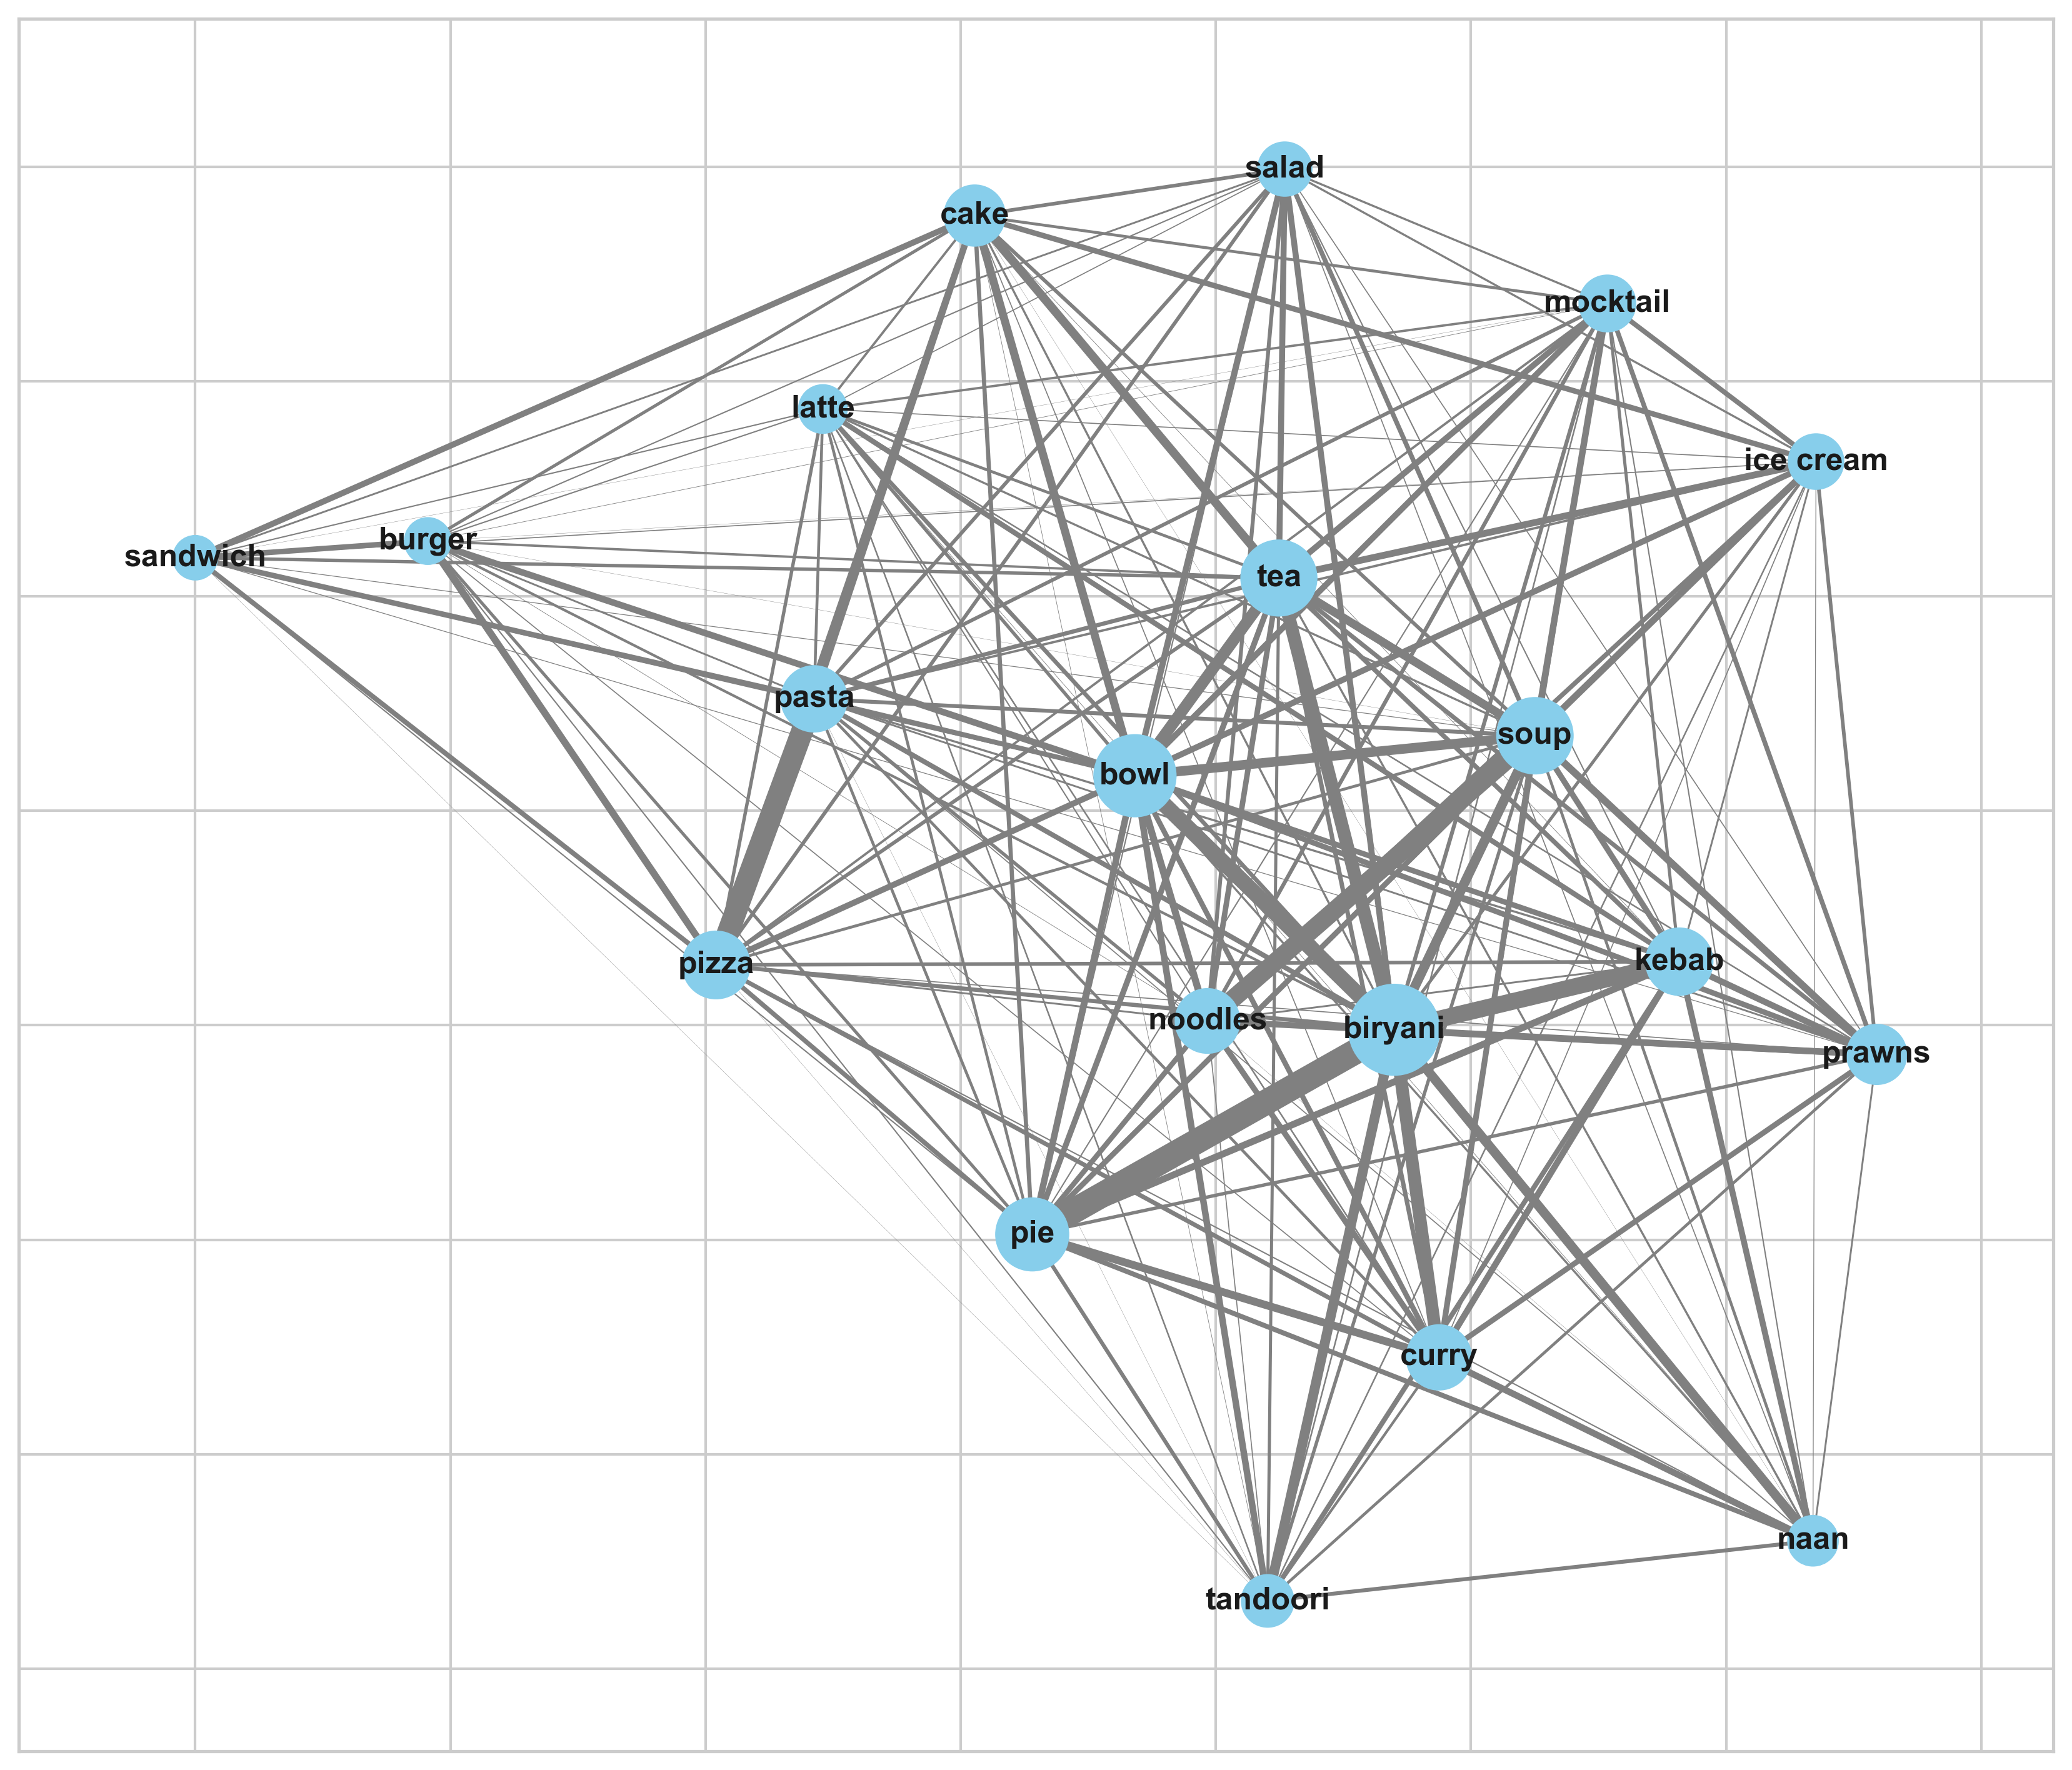

In [61]:
cooccurrence_network_generator(visual_cooccurrence,20)

<font color='#BFD72F' size=4>5.3 Dish Clustering preprocessing</font> <a class="anchor" id="P53"></a>
  
[Back to TOC](#toc)

In [62]:
coocurrence_dishes

chicken  biryani  fish  bowl  sauce  tea  soup  pizza  pie  crispy  \
chicken         0      382   230   159    131  137   127    108  186     101   
biryani       382        0    72    60     27   50    37     16   97      22   
fish          230       72     0    38     41   29    45     45   36      28   
bowl          159       60    38     0     47   44    37     23   25      32   
sauce         131       27    41    47      0   35    40     34   20      40   
...           ...      ...   ...   ...    ...  ...   ...    ...  ...     ...   
pakora          0        0     0     0      0    0     0      0    0       1   
fritters        1        0     0     0      0    0     0      0    0       0   
burrito         0        0     0     0      0    0     0      1    0       0   
octopus         0        0     0     0      0    0     0      0    0       0   
tapas           0        0     0     0      0    0     0      0    0       0   

          ...  crackers  duck  cheese bread  pasta salad  jambalaya  pakora  \
chicken   ...         0     0             0            0          0       0   
biryani   ...         0     0             0            0          0       0   
fish      ...         0     0             0            0          0       0   
bowl      ...         0     0             0            0          0       0   
sauce     ...         0     1             0            0          0       0   
...       ...       ...   ...           ...          ...        ...     ...   
pakora    ...         0     0             0            0          0       0   
fritters  ...         0     0             0            0          0       0   
burrito   ...         0     0             0            0          0       0   
octopus   ...         0     0             0            0          0       0   
tapas     ...         0     0             0            0          0       0   

          fritters  burrito  octopus  tapas  
chicken          1        0        0      0  
biryani          0        0        0      0  
fish             0        0        0      0  
bowl             0        0        0      0  
sauce            0        0        0      0  
...            ...      ...      ...    ...  
pakora           0        0        0      0  
fritters         0        0        0      0  
burrito          0        0        0      0  
octopus          0        0        0      0  
tapas            0        0        0      0  

[185 rows x 185 columns]

In [63]:
cooc_matrix = np.array(coocurrence_dishes)
cooc_matrix_normalized = cooc_matrix / cooc_matrix.max() 

In [64]:
cooc_matrix_normalized

array([[0.        , 1.        , 0.60209424, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.18848168, ..., 0.        , 0.        ,
        0.        ],
       [0.60209424, 0.18848168, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

<font color='#BFD72F' size=4>5.4 Optics </font> <a class="anchor" id="P54"></a>
  
[Back to TOC](#toc)

In [106]:
np.linspace(0.001, 0.1, 10).tolist()

[0.001,
 0.012,
 0.023000000000000003,
 0.034,
 0.045000000000000005,
 0.05600000000000001,
 0.067,
 0.07800000000000001,
 0.08900000000000001,
 0.1]

In [ ]:
param_grid = {
    "min_samples": [2, 3, 5, 7, 10],
    "max_eps": [0.5, 1, 1.5, 2, 2.5],
    "xi": [0.001, 0.005, 0.01, 0.05, 0.1],
    "metric": ["euclidean", "cosine", "manhattan"],
    "min_cluster_size": [2, 5, 10, 20]
}

param_combinations = list(product(
    param_grid["min_samples"],
    param_grid["max_eps"],
    param_grid["xi"],
    param_grid["metric"],
    param_grid["min_cluster_size"],
))

results = []

for min_samples, max_eps, xi, metric, min_cluster_size in tqdm(param_combinations, desc="Grid Search Progress"):
    optics = OPTICS(
        min_samples=min_samples,
        max_eps=max_eps,
        xi=xi,
        metric=metric,
        min_cluster_size=min_cluster_size,
    )
    optics_labels = optics.fit_predict(cooc_matrix_normalized)
    
    # Filter noise points (-1) for silhouette score calculation
    filtered_labels = optics_labels[optics_labels != -1]
    filtered_data = cooc_matrix_normalized[optics_labels != -1]
    
    # Calculate silhouette score only if there are at least 2 clusters
    if len(np.unique(filtered_labels)) > 1:
        sil_score = silhouette_score(filtered_data, filtered_labels)
    else:
        sil_score = -1

    num_clusters = len(set(filtered_labels)) - (1 if -1 in filtered_labels else 0)
    
    results.append({
        "min_samples": min_samples,
        "max_eps": max_eps,
        "xi": xi,
        "metric": metric,
        "min_cluster_size": min_cluster_size,
        "num_clusters": num_clusters,
        "silhouette_score": sil_score
    })

results = sorted(results, key=lambda x: (x["num_clusters"], x["silhouette_score"]), reverse=True)

# Display the top result
best_result = results[0]
print("\nBest Parameters:")
print(f"min_samples: {best_result['min_samples']}")
print(f"max_eps: {best_result['max_eps']}")
print(f"xi: {best_result['xi']}")
print(f"metric: {best_result['metric']}")
print(f"min_cluster_size: {best_result['min_cluster_size']}")
print(f"Number of Clusters: {best_result['num_clusters']}")
print(f"Silhouette Score: {best_result['silhouette_score']}")

# Top 5 results for further insights
print("\nTop 5 Results:")
for i, result in enumerate(results[:5]):
    print(f"{i + 1}: {result}")


Grid Search Progress: 100%|██████████| 1500/1500 [11:59<00:00,  2.08it/s]


Best Parameters:
min_samples: 2
max_eps: 0.5
xi: 0.001
metric: cosine
min_cluster_size: 2
Number of Clusters: 22
Silhouette Score: -0.08449836997561255

Top 5 Results:
1: {'min_samples': 2, 'max_eps': 0.5, 'xi': 0.001, 'metric': 'cosine', 'min_cluster_size': 2, 'num_clusters': 22, 'silhouette_score': -0.08449836997561255}
2: {'min_samples': 2, 'max_eps': 1, 'xi': 0.001, 'metric': 'cosine', 'min_cluster_size': 2, 'num_clusters': 22, 'silhouette_score': -0.08449836997561255}
3: {'min_samples': 2, 'max_eps': 1.5, 'xi': 0.001, 'metric': 'cosine', 'min_cluster_size': 2, 'num_clusters': 22, 'silhouette_score': -0.08449836997561255}
4: {'min_samples': 2, 'max_eps': 2, 'xi': 0.001, 'metric': 'cosine', 'min_cluster_size': 2, 'num_clusters': 22, 'silhouette_score': -0.08449836997561255}
5: {'min_samples': 2, 'max_eps': 2.5, 'xi': 0.001, 'metric': 'cosine', 'min_cluster_size': 2, 'num_clusters': 22, 'silhouette_score': -0.08449836997561255}


Silhouette Score for OPTICS: -0.1096


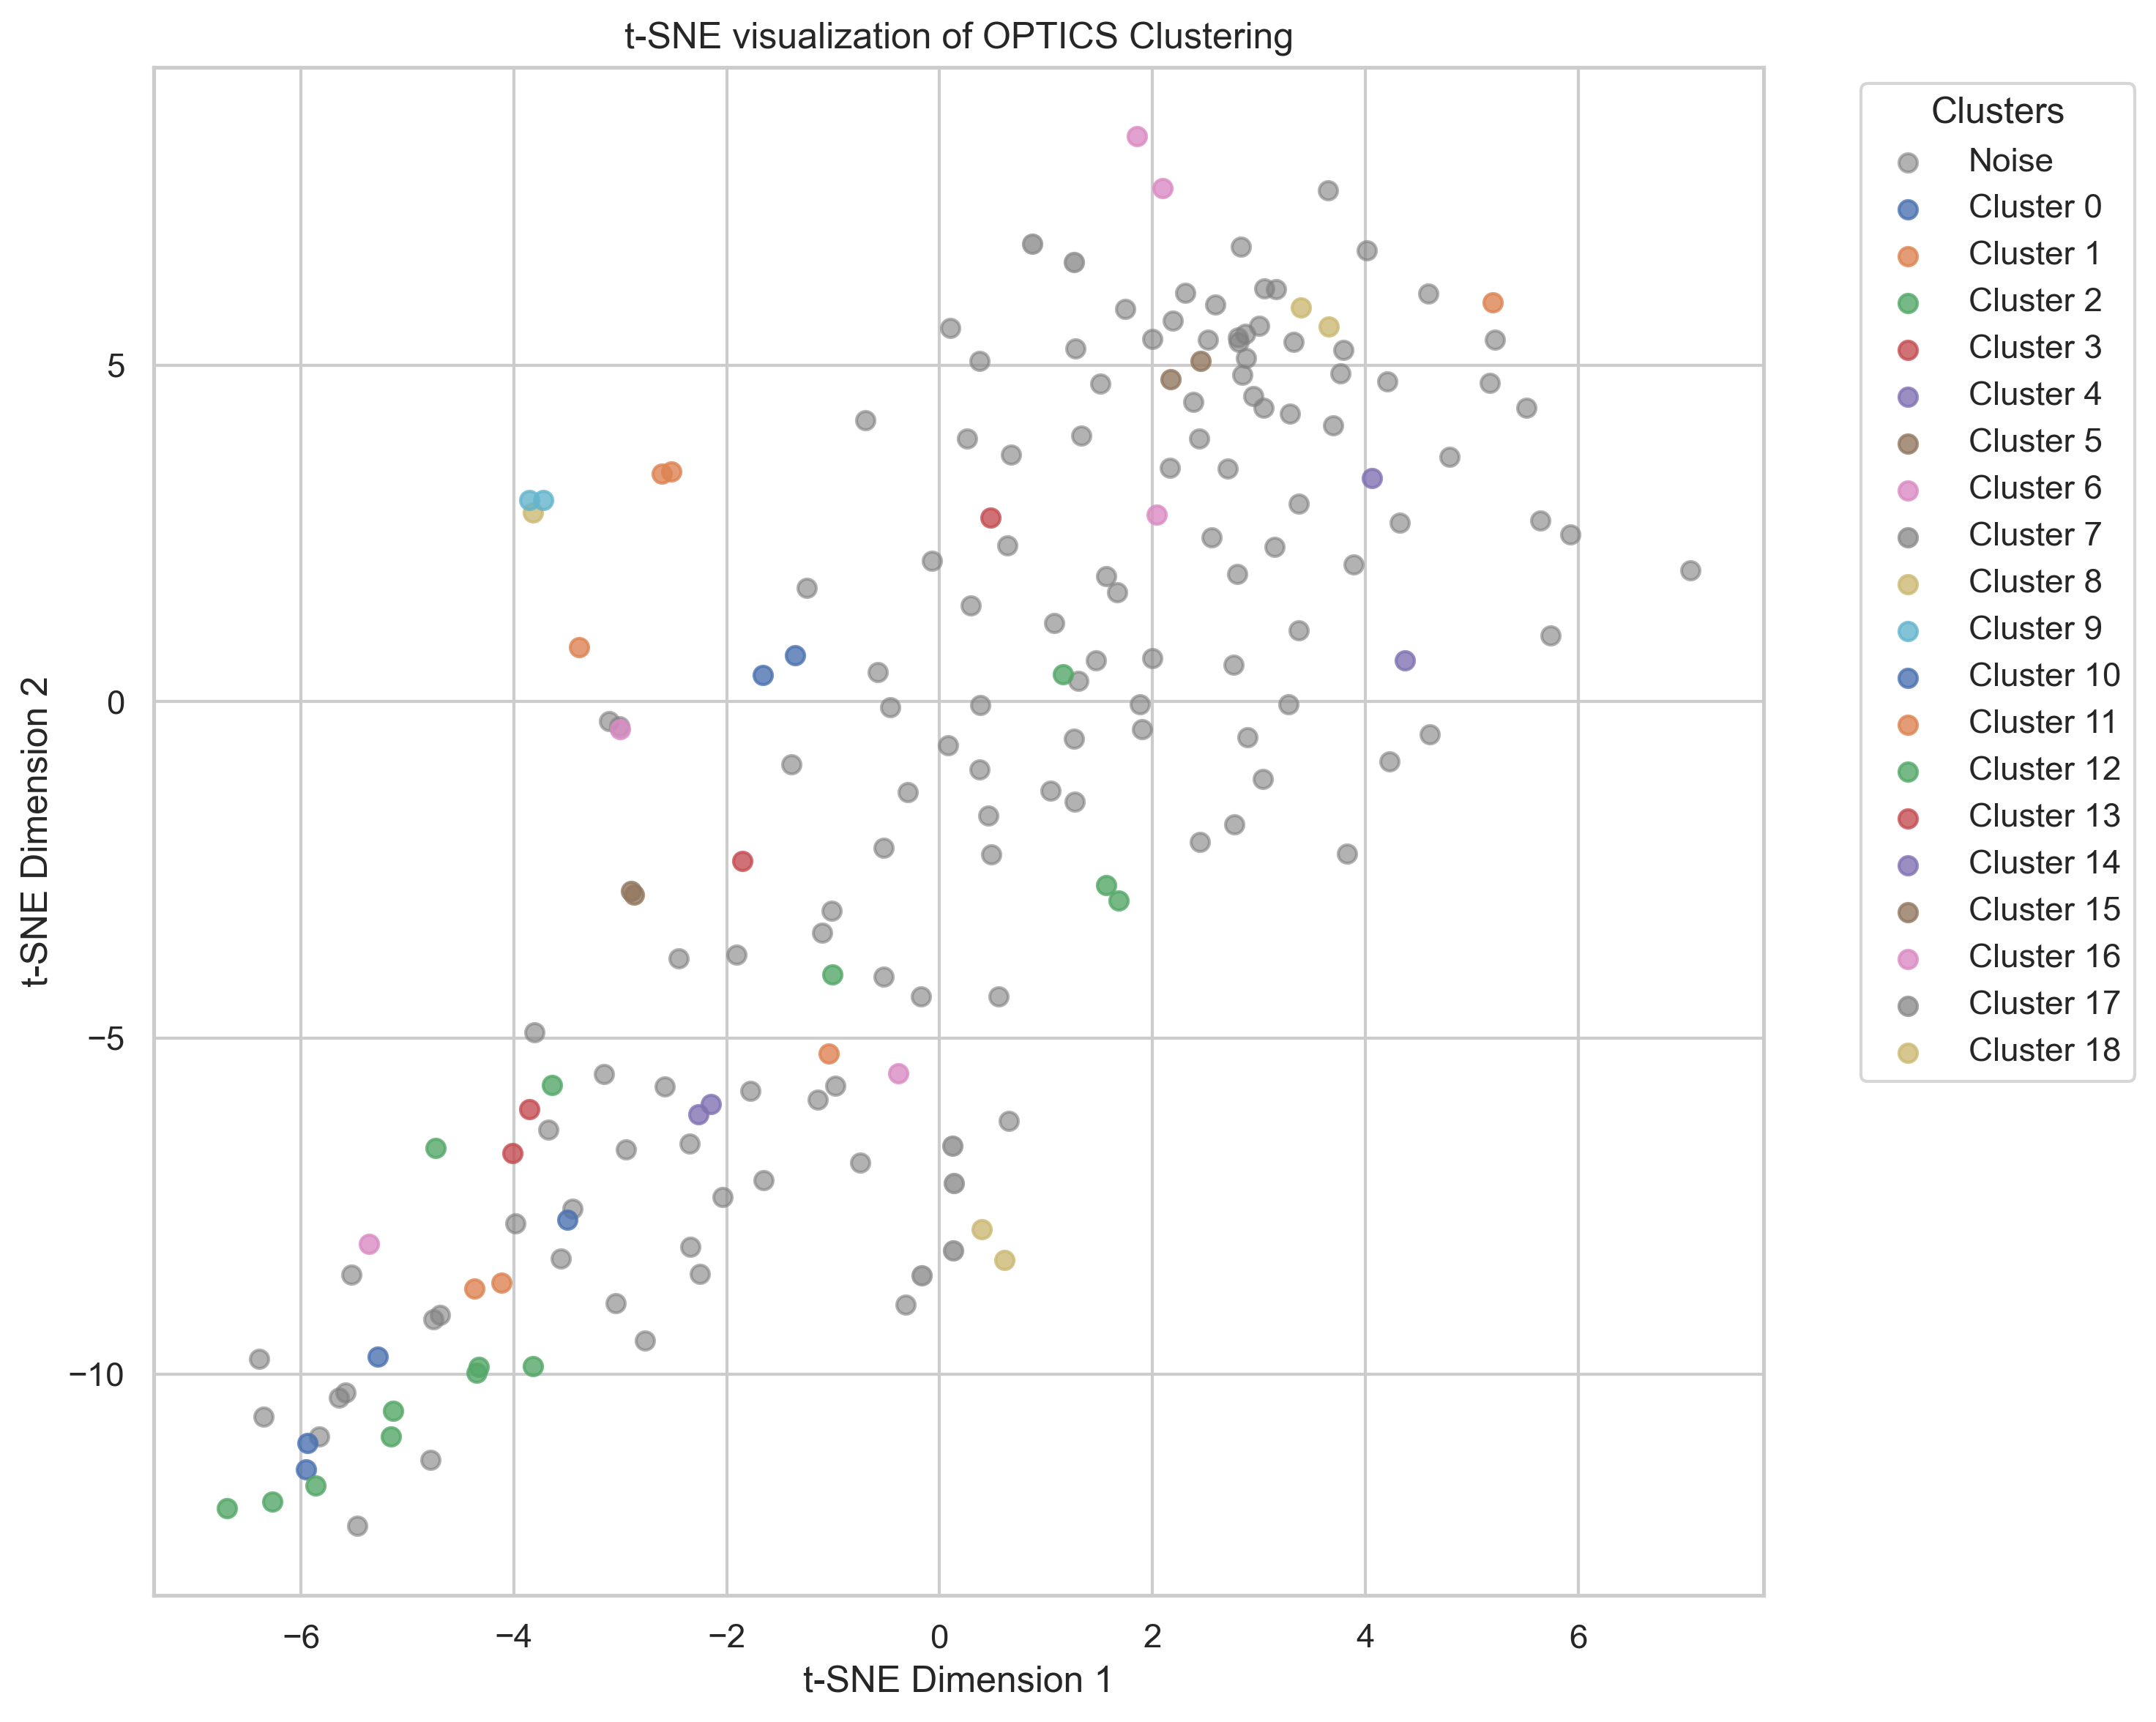

In [65]:
optics = OPTICS(min_samples=2, max_eps=0.5, metric="cosine", xi=0.001, min_cluster_size=2)
optics_labels = optics.fit_predict(cooc_matrix_normalized)

filtered_labels = optics_labels[optics_labels != -1]
filtered_data = cooc_matrix_normalized[optics_labels != -1]

if len(filtered_labels) > 1: 
    sil_score = silhouette_score(filtered_data, filtered_labels)
    print(f'Silhouette Score for OPTICS: {sil_score:.4f}')
else:
    print('No valid clusters found by OPTICS.')

# Visualization of clusters using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_2d = tsne.fit_transform(cooc_matrix_normalized)

unique_labels = np.unique(optics_labels)

# Assign colors and labels for plotting
colors = plt.cm.get_cmap('viridis', len(unique_labels))

plt.figure(figsize=(10, 8))
for label in unique_labels:
    cluster_points = reduced_2d[optics_labels == label]
    if label == -1:
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color='gray', label='Noise', alpha=0.6)
    else:
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {label}', cmap=colors, alpha=0.8)

plt.title('t-SNE visualization of OPTICS Clustering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
%config InlineBackend.figure.format = "svg"
 

In [ ]:
optics_dish_labels_df = pd.DataFrame({
    'Dish': coocurrence_dishes.columns,
    'Cluster': optics_labels
})
print(optics_dish_labels_df)


         Dish  Cluster
0     chicken       -1
1        fish       -1
2     biryani       -1
3        bowl        2
4       sauce       -1
..        ...      ...
180    pakora       -1
181  fritters       -1
182   octopus       -1
183   burrito       -1
184     tapas       -1

[185 rows x 2 columns]


In [114]:
optics_clustered_dishes = optics_dish_labels_df.groupby('Cluster')['Dish'].apply(list).reset_index()
print(optics_clustered_dishes)

    Cluster                                               Dish
0        -1  [chicken, fish, biryani, sauce, tea, pizza, ca...
1         0                       [pie, naan, tandoori, pulao]
2         1                                   [curry, grilled]
3         2                              [bowl, crispy, salad]
4         3                                      [soup, gravy]
5         4                     [bbq, shawarma, fried chicken]
6         5                            [beer, cocktail, pesto]
7         6                                        [maki, pho]
8         7                           [appetizer, onion rings]
9         8                               [lemonade, barbecue]
10        9                           [bread, sandwich, snack]
11       10                 [pasta, crust, spaghetti, risotto]
12       11                                 [bake, cheesecake]
13       12                                [brownies, cookies]
14       13                                  [steak, ic

In [115]:
[i for i in optics_clustered_dishes[optics_clustered_dishes["Cluster"] != -1].Dish.values]

[['pie', 'naan', 'tandoori', 'pulao'],
 ['curry', 'grilled'],
 ['bowl', 'crispy', 'salad'],
 ['soup', 'gravy'],
 ['bbq', 'shawarma', 'fried chicken'],
 ['beer', 'cocktail', 'pesto'],
 ['maki', 'pho'],
 ['appetizer', 'onion rings'],
 ['lemonade', 'barbecue'],
 ['bread', 'sandwich', 'snack'],
 ['pasta', 'crust', 'spaghetti', 'risotto'],
 ['bake', 'cheesecake'],
 ['brownies', 'cookies'],
 ['steak', 'iced tea'],
 ['chips', 'fried fish'],
 ['beef', 'smoked', 'shrimp'],
 ['dumplings', 'loaf'],
 ['garlic bread', 'croissant', 'bagel', 'focaccia', 'brioche'],
 ['polenta', 'pasta salad'],
 ['mezze', 'cheese platter'],
 ['shawarma wrap', 'falafel'],
 ['cucumber salad', 'couscous']]

For cluster making with optics we optimized the parameters by running a gridsearch optimized to get the best silhouette score.

After analyzing the cluster plot:
- The clusters don't seem very distinct (colors are blended together) are there is not much intra cluster similarities as the points belonging to a cluster are not always seen together. However, such was expected as the model has a low silhouette score, -0.0845

We created a dataframe with the dishes belonging to each one of the 22 clusters and their respective number from that we concluded:
 - 0 ['pie', 'naan', 'tandoori', 'pulao']:  `Pie is a bit of an outlier as the other 3 could be seen in Indian cuisine`
 - 1 ['curry', 'grilled']: `Also Indian cuisine`
 - 2 ['bowl', 'crispy', 'salad']: `Vegetarian cuisine`
 - 3 ['soup', 'gravy']: `Could be any cuisine type from Western, to Indian, to Asian as soup and gravy can be found on them all`
 - 4 ['bbq', 'shawarma', 'fried chicken']: `Can be a cuisine like KFC for example`
 - 5 ['beer', 'cocktail', 'pesto']: `Can be a bar for example`
 - 6 ['maki', 'pho']: `Asian cuisine`
 - 7 ['appetizer', 'onion rings']: `Entrees`
 - 8 ['lemonade', 'barbecue']: `Can be American cuisine as both are most known for being american`
 - 9 ['bread', 'sandwich', 'snack']: `Can be a snack-bar or cafe`
 - 10 ['pasta', 'crust', 'spaghetti', 'risotto']: `Italian cuisine`
 - 11 ['bake', 'cheesecake']: `Bakery`
 - 12 ['brownies', 'cookies']: `Bakery`
 - 13 ['steak', 'iced tea']: `Steak houses`
 - 14 ['chips', 'fried fish']: `May be reference to fish and chips famous british dish and therefore represents the british cuisine`
 - 15 ['beef', 'smoked', 'shrimp']: `Any cuisine type, all three are very common`
 - 16 ['dumplings', 'loaf']: `Don't share a common cuisine type`
 - 17 ['garlic bread', 'croissant', 'bagel', 'focaccia', 'brioche']: `Cafe`
 - 18 ['polenta', 'pasta salad']: `Italian cuisine`
 - 19 ['mezze', 'cheese platter']: `European, Mediterranean cuisines`
 - 20 ['shawarma wrap', 'falafel']: `Middle Eastern Street Food`
 - 21 ['cucumber salad', 'couscous']: `Vegetarian`

Overall we can see a lot of cuisines, all for exception of one have one assigned to the cluster. However there also are some repeated cuisines


<font color='#BFD72F' size=4>5.5 HDBSCAN </font> <a class="anchor" id="P55"></a>
  
[Back to TOC](#toc)

In [ ]:
param_grid = {
    "min_samples": [2, 3, 5, 7, 10],
    "min_cluster_size": [2, 5, 10, 20],
    "metric": ["euclidean", "manhattan"],
    "alpha": [0.5, 1.0, 1.5],
    "cluster_selection_epsilon": [0.0, 0.1, 0.2]
}

param_combinations = list(product(
    param_grid["min_samples"],
    param_grid["min_cluster_size"],
    param_grid["metric"],
    param_grid["alpha"],
    param_grid["cluster_selection_epsilon"]
))

results = []

for min_samples, min_cluster_size, metric, alpha, cluster_selection_epsilon in tqdm(param_combinations, desc="Grid Search Progress"):
    clusterer = HDBSCAN(
        min_samples=min_samples,
        min_cluster_size=min_cluster_size,
        metric=metric,
        alpha=alpha,
        cluster_selection_epsilon=cluster_selection_epsilon
    )
    
    hdbscan_labels = clusterer.fit_predict(cooc_matrix_normalized)
    
    filtered_labels = hdbscan_labels[hdbscan_labels != -1]
    filtered_data = cooc_matrix_normalized[hdbscan_labels != -1]
    
    if len(np.unique(filtered_labels)) > 1:
        sil_score = silhouette_score(filtered_data, filtered_labels)
    else:
        sil_score = -1
        
    num_clusters = len(set(filtered_labels)) - (1 if -1 in filtered_labels else 0)
    
    results.append({
        "min_samples": min_samples,
        "min_cluster_size": min_cluster_size,
        "metric": metric,
        "alpha": alpha,
        "cluster_selection_epsilon": cluster_selection_epsilon,
        "num_clusters": num_clusters,
        "silhouette_score": sil_score
    })

results = sorted(results, key=lambda x: (x["num_clusters"], x["silhouette_score"]), reverse=True)

best_result = results[0]
print("\nBest Parameters:")
print(f"min_samples: {best_result['min_samples']}")
print(f"min_cluster_size: {best_result['min_cluster_size']}")
print(f"metric: {best_result['metric']}")
print(f"alpha: {best_result['alpha']}")
print(f"cluster_selection_epsilon: {best_result['cluster_selection_epsilon']}")
print(f"Number of Clusters: {best_result['num_clusters']}")
print(f"Silhouette Score: {best_result['silhouette_score']}")

print("\nTop 5 Results:")
for i, result in enumerate(results[:5]):
    print(f"{i + 1}: {result}")

Grid Search Progress: 100%|██████████| 360/360 [00:02<00:00, 136.72it/s]


Best Parameters:
min_samples: 2
min_cluster_size: 2
metric: euclidean
alpha: 0.5
cluster_selection_epsilon: 0.0
Number of Clusters: 17
Silhouette Score: 0.3272007658828842

Top 5 Results:
1: {'min_samples': 2, 'min_cluster_size': 2, 'metric': 'euclidean', 'alpha': 0.5, 'cluster_selection_epsilon': 0.0, 'num_clusters': 17, 'silhouette_score': 0.3272007658828842}
2: {'min_samples': 2, 'min_cluster_size': 2, 'metric': 'euclidean', 'alpha': 1.0, 'cluster_selection_epsilon': 0.0, 'num_clusters': 17, 'silhouette_score': 0.3272007658828842}
3: {'min_samples': 3, 'min_cluster_size': 2, 'metric': 'euclidean', 'alpha': 0.5, 'cluster_selection_epsilon': 0.0, 'num_clusters': 17, 'silhouette_score': 0.3272007658828842}
4: {'min_samples': 5, 'min_cluster_size': 2, 'metric': 'euclidean', 'alpha': 0.5, 'cluster_selection_epsilon': 0.0, 'num_clusters': 17, 'silhouette_score': 0.3272007658828842}
5: {'min_samples': 7, 'min_cluster_size': 2, 'metric': 'euclidean', 'alpha': 0.5, 'cluster_selection_epsilo

Silhouette Score for HDBSCAN: 0.2308


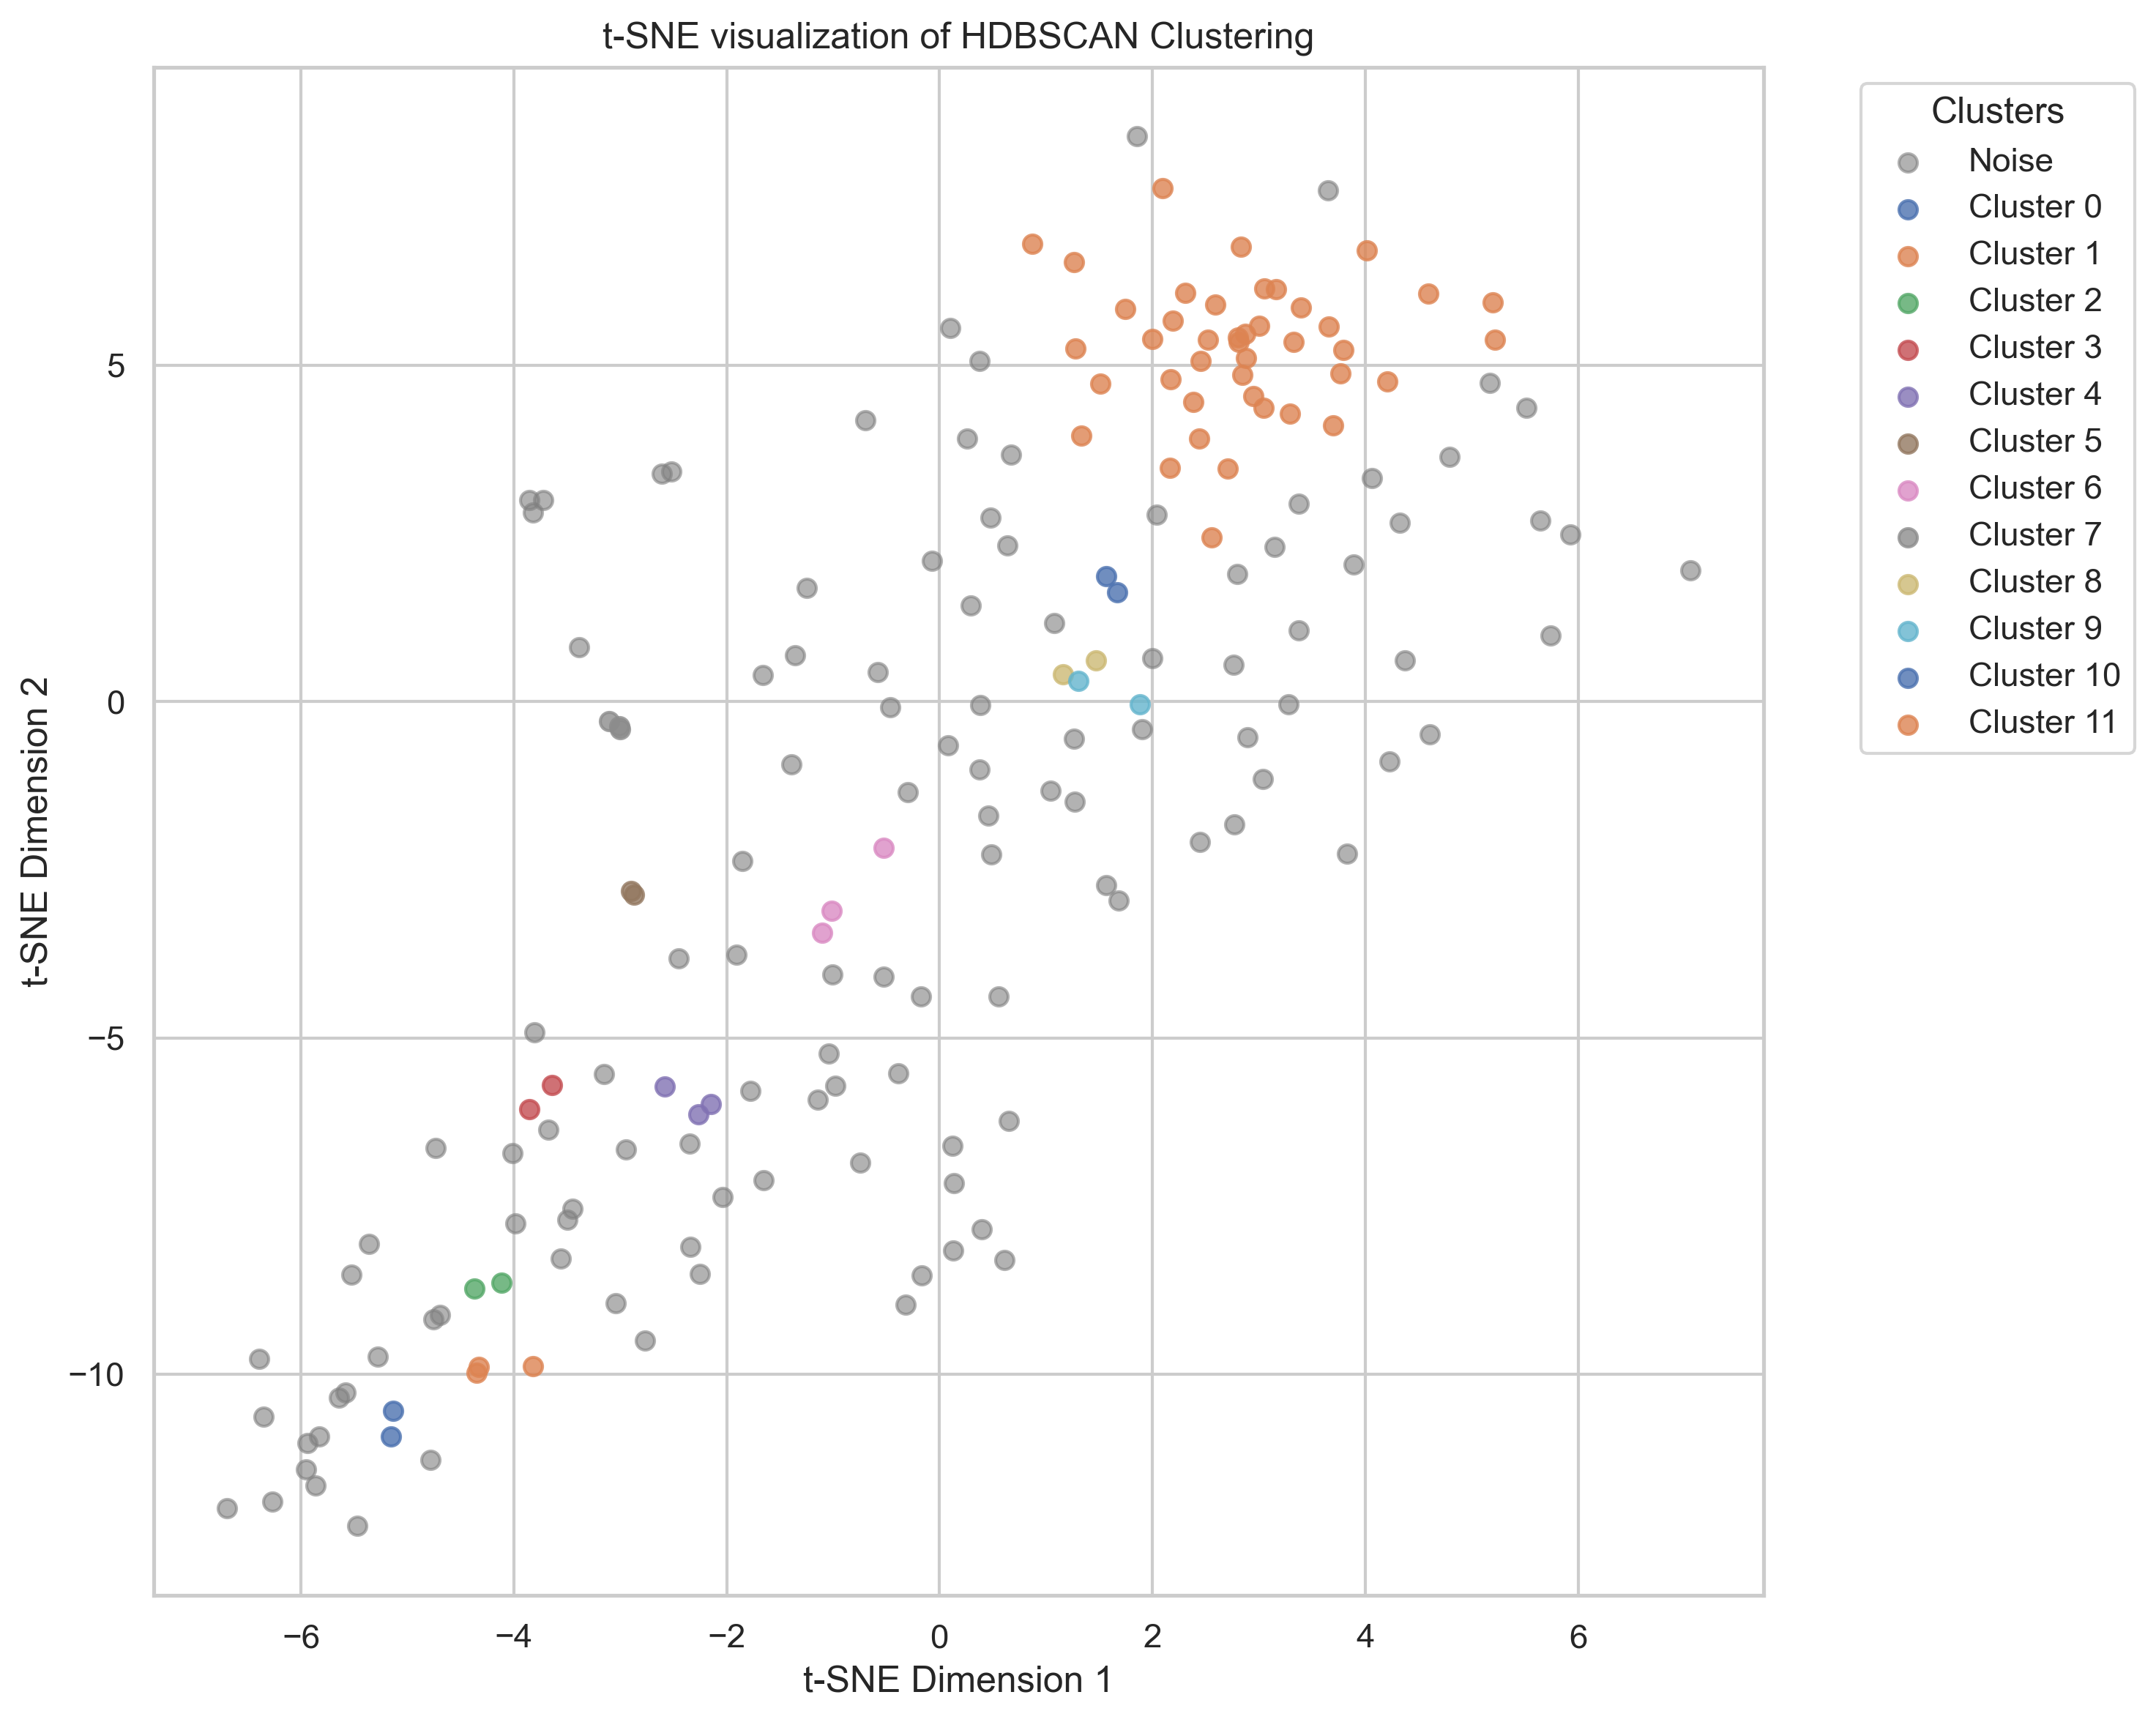

In [66]:
hdbscan = HDBSCAN(min_cluster_size=2, min_samples = 2, metric= "euclidean", alpha = 0.5, cluster_selection_epsilon= 0.0).fit(cooc_matrix_normalized)
hdbscan_labels = hdbscan.fit_predict(cooc_matrix_normalized)

filtered_labels = hdbscan_labels[hdbscan_labels != -1]
filtered_data = cooc_matrix_normalized[hdbscan_labels != -1]

if len(filtered_labels) > 1:
    sil_score = silhouette_score(filtered_data, filtered_labels)
    print(f'Silhouette Score for HDBSCAN: {sil_score:.4f}')
else:
    print('No valid clusters found by HDBSCAN.')

tsne = TSNE(n_components=2, random_state=42)
reduced_2d = tsne.fit_transform(cooc_matrix_normalized)

unique_labels = np.unique(hdbscan_labels)

colors = plt.cm.get_cmap('viridis', len(unique_labels))

plt.figure(figsize=(10, 8))
for label in unique_labels:
    cluster_points = reduced_2d[hdbscan_labels == label]
    if label == -1:
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color='gray', label='Noise', alpha=0.6)
    else:
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {label}', cmap=colors, alpha=0.8)

plt.title('t-SNE visualization of HDBSCAN Clustering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
%config InlineBackend.figure.format = "svg" 

In [ ]:
hdbscan_dish_labels_df = pd.DataFrame({
    'Dish': coocurrence_dishes.columns,
    'Cluster': hdbscan_labels
})
print(hdbscan_dish_labels_df)


         Dish  Cluster
0     chicken       -1
1        fish       -1
2     biryani       -1
3        bowl        0
4       sauce       -1
..        ...      ...
180    pakora       16
181  fritters       16
182   octopus       16
183   burrito       16
184     tapas       16

[185 rows x 2 columns]


In [ ]:
hdbscan_clustered_dishes = hdbscan_dish_labels_df.groupby('Cluster')['Dish'].apply(list).reset_index()

print(hdbscan_clustered_dishes)

    Cluster                                               Dish
0        -1  [chicken, fish, biryani, sauce, pizza, soup, c...
1         0                                        [bowl, tea]
2         1                              [mocktail, ice cream]
3         2                            [naan, gravy, tandoori]
4         3                                       [bun, snack]
5         4                   [roll, bbq, wrap, fried chicken]
6         5                               [juice, pork, roast]
7         6                                   [dip, appetizer]
8         7                                [brownies, cookies]
9         8                               [lemonade, barbecue]
10        9                                 [croissant, bagel]
11       10                               [spaghetti, ravioli]
12       11                          [pesto, kung pao chicken]
13       12                           [fried fish, fish curry]
14       13                             [street food, k

In [145]:
print([i for i in hdbscan_clustered_dishes.Dish[17]])

['grilled vegetables', 'macaroni', 'calzone', 'club sandwich', 'focaccia', 'brioche', 'green salad', 'comfort food', 'tortilla', 'shawarma wrap', 'paella', 'dim sum', 'loaf', 'goat', 'cheese platter', 'baked potato', 'chowder', 'falafel', 'baklava', 'espresso', 'enchilada', 'lentils', 'guacamole', 'candy', 'kebab wrap', 'pizza slice', 'cucumber salad', 'quinoa', 'coleslaw', 'baked beans', 'pot pie', 'macarons', 'masala pan', 'couscous', 'polenta', 'cream soup', 'vegetable stew', 'crackers', 'cheese bread', 'duck', 'pasta salad', 'jambalaya', 'pakora', 'fritters', 'octopus', 'burrito', 'tapas']


In [146]:
[i for i in hdbscan_clustered_dishes[hdbscan_clustered_dishes["Cluster"] != -1].Dish.values]

[['bowl', 'tea'],
 ['mocktail', 'ice cream'],
 ['naan', 'gravy', 'tandoori'],
 ['bun', 'snack'],
 ['roll', 'bbq', 'wrap', 'fried chicken'],
 ['juice', 'pork', 'roast'],
 ['dip', 'appetizer'],
 ['brownies', 'cookies'],
 ['lemonade', 'barbecue'],
 ['croissant', 'bagel'],
 ['spaghetti', 'ravioli'],
 ['pesto', 'kung pao chicken'],
 ['fried fish', 'fish curry'],
 ['street food', 'ketchup'],
 ['soba', 'shrimp'],
 ['bibimbap', 'satay'],
 ['grilled vegetables',
  'macaroni',
  'calzone',
  'club sandwich',
  'focaccia',
  'brioche',
  'green salad',
  'comfort food',
  'tortilla',
  'shawarma wrap',
  'paella',
  'dim sum',
  'loaf',
  'goat',
  'cheese platter',
  'baked potato',
  'chowder',
  'falafel',
  'baklava',
  'espresso',
  'enchilada',
  'lentils',
  'guacamole',
  'candy',
  'kebab wrap',
  'pizza slice',
  'cucumber salad',
  'quinoa',
  'coleslaw',
  'baked beans',
  'pot pie',
  'macarons',
  'masala pan',
  'couscous',
  'polenta',
  'cream soup',
  'vegetable stew',
  'cracke

For cluster making with hdbscan we used a gridsearch to optimize the parameters according to the silhouette score.

After analyzing the cluster plot:
- This plot looks better than the one of the optics model, the points of the same cluster seem closer together and also there is a bigger separation between cluster, of course there are noise points all over the plot which makes it messier. Also there is one much bigger cluster in this model.

We created a dataframe with the dishes belonging to each one of the 22 clusters and their respective number from that we concluded:
 - 0 ['bowl', 'tea']: `Associated with Chinese, Asian cuisine as it is the main origin of these dishes`
 - 1 ['mocktail', 'ice cream']: `Doesn't seem to be any cuisine type, however both are connected to Western cuisines`
 - 2 ['naan', 'gravy', 'tandoori']: `Indian cuisine`
 - 3 ['bun', 'snack']: `Can be a cafe or a bakery`
 - 4 ['roll', 'bbq', 'wrap', 'fried chicken']: `BBQ chicken wraps and fried chicken sandwiches are typical southern American cuisine.`
 - 5 ['juice', 'pork', 'roast']: `Does not really associate with a cuisine type`
 - 6 ['dip', 'appetizer']: `Entrees or side dishes`
 - 7 ['brownies', 'cookies']: `Bakery`
 - 8 ['lemonade', 'barbecue']: `Can be American cuisine as both are most known for being american`
 - 9 ['croissant', 'bagel']: `Bakery or cafe`
 - 10 ['spaghetti', 'ravioli']: `Italian cuisine`
 - 11 ['pesto', 'kung pao chicken']: `Not traditionally associated to the same cuisine`
 - 12 ['fried fish', 'fish curry']: `South Asian cuisine`
 - 13 ['street food', 'ketchup']: `Street food, the cuisine type seen in the dataset`
 - 14 ['soba', 'shrimp']: `Japanese cuisine`
 - 15 ['bibimbap', 'satay']: `Asian cuisine`
 - 16 ['grilled vegetables', 'macaroni', 'calzone', 'club sandwich', 'focaccia', 'brioche', 'green salad', 'comfort food', 'tortilla', 'shawarma wrap', 'paella', 'dim sum', 'loaf', 'goat', 'cheese platter', 'baked potato', 'chowder', 'falafel', 'baklava', 'espresso', 'enchilada', 'lentils', 'guacamole', 'candy', 'kebab wrap', 'pizza slice', 'cucumber salad', 'quinoa', 'coleslaw', 'baked beans', 'pot pie', 'macarons', 'masala pan', 'couscous', 'polenta', 'cream soup', 'vegetable stew', 'crackers', 'cheese bread', 'duck', 'pasta salad', 'jambalaya', 'pakora', 'fritters', 'octopus', 'burrito', 'tapas']: `Dishes from a wide variety of global cuisines including Mediterranean, Middle Eastern, Italian, American, Spanish, and Asian influences. Additionally, there is a blend of comfort food, vegetarian dishes, and street food/snack options`

Overall we most of the clusters represent a cuisine, however there are a few that either represent too much cuisines or doesn't even represent one at all. There are also some repeated cuisines.

Comparing both models despite in theory HDBSCAN looking better in the plot and in the silhouette after analyzing the dishes that compose each cluster it can be extracted much more meaning from the optics clusters. So overall we concluded that the optics clusters are better as they provide more insights and are easier to interpret.

What dishes are mentioned together in the reviews? Do they form clusters? Can you identify cuisine types based on those clusters? 


Responding directly to these questions:
- The first one can be answered be looking at the plot from 5.2
- To the second one we can affirm that yes we were able to form meaningful clusters using different clustering methods. In both methods the cluster formed used the co-occurrence matrix were meaningful and insightful.
- To the last one we can say that we got some easily identified cuisine types, however, not all clusters represented clear models. Nonetheless the number of clusters in which it was easy to recognize a cuisine type outweighs the number of clusters where it wasn't. To see the cuisine types identified read the markdowns below the code of optics and hdbscan

<font color='#BFD72F' size=5>6. Topic Modeling</font> <a class="anchor" id="P6"></a>
  
[Back to TOC](#toc)

Can the reviews be classified according to emergent topics? (e.g., can review j be made up of 0.5 topic “service; speed; sympathy”, and 
0.3 topic “ambiance; decoration; furniture”?)

What do the emergent topic mean? (i.e., are they meaningful regarding the project’s  context?) 

Can relevant insights be extracted from the topics?

<font color='#BFD72F' size=4>6.1 Data preparation</font> <a class="anchor" id="P61"></a>
  
[Back to TOC](#toc)

As we are only going to use the reviews for this topic there is no need for data exploration and visualization as they were all previously done

In [6]:
topic_modeling= reviews.copy()
topic_modeling.drop(columns = ["Restaurant", "Reviewer", "Rating", "Metadata", "Time", "Pictures", "Cuisine","Cuisine_split"], inplace = True)
topic_modeling.head(5)

Review
0  The ambience was good, food was quite good . h...
1  Ambience is too good for a pleasant evening. S...
2  A must try.. great food great ambience. Thnx f...
3  Soumen das and Arun was a great guy. Only beca...
4  Food is good.we ordered Kodi drumsticks and ba...

In [7]:
topic_modeling.dropna(inplace = True)

In [8]:
preprocessor = pipeline.MainPipeline(tokenized_output=False, lowercase=True, no_stopwords= True,
                                        lemmatized=False)


topic_modeling["Review_prepared"] = topic_modeling["Review"].map(lambda x:preprocessor.main_pipeline(x))

In [9]:
preprocessor_tokenizer = pipeline.MainPipeline(tokenized_output=True, lowercase=True, no_stopwords= True,
                                        lemmatized=False)


topic_modeling["Review_tokenized"] = topic_modeling["Review"].map(lambda x:preprocessor_tokenizer.main_pipeline(x))

In [21]:
topic_modeling.head(5)

Review  \
0  The ambience was good, food was quite good . h...   
1  Ambience is too good for a pleasant evening. S...   
2  A must try.. great food great ambience. Thnx f...   
3  Soumen das and Arun was a great guy. Only beca...   
4  Food is good.we ordered Kodi drumsticks and ba...   

                                     Review_prepared  \
0  ambience good food quite good saturday lunch c...   
1  ambience good pleasant evening service prompt ...   
2  must try great food great ambience thnx servic...   
3  soumen das arun great guy behavior sincerety g...   
4  food ordered kodi drumsticks basket mutton bir...   

                                    Review_tokenized  
0  [ambience, good, food, quite, good, saturday, ...  
1  [ambience, good, pleasant, evening, service, p...  
2  [must, try, great, food, great, ambience, thnx...  
3  [soumen, das, arun, great, guy, behavior, sinc...  
4  [food, ordered, kodi, drumsticks, basket, mutt...

<font color='#BFD72F' size=4>6.2 Latent Semantic Analysis (LSA)</font> <a class="anchor" id="P62"></a>
  
[Back to TOC](#toc)

### LSA using sklearn

In [21]:
bow_vectorizer = CountVectorizer(ngram_range=(1,1), token_pattern=r"(?u)\b\w+\b")
topic_modeling_bow_td_matrix = bow_vectorizer.fit_transform(topic_modeling["Review_prepared"]).toarray()

We tried to optimize the number of components using the explained variance as the comparison metric, this did not work as it would eventually become endless either at the end of the first, second or third n in the for loop, never even getting to the fourth n. So we decided to proceed using n_components = 100 as it would yield the most explained variance. The code used when trying to get the best n_components was this:

```python
n_components_range = [i for i in range(20, 100, 10)]
explained_variance = []

# Calculate explained variance for each n_components
for n in tqdm(n_components_range):
    lsa = TruncatedSVD(n_components=n, random_state=42)
    lsa.fit(topic_modeling_bow_td_matrix)
    total_explained_variance = np.sum(lsa.explained_variance_ratio_)
    explained_variance.append(total_explained_variance)

plt.plot(n_components_range, explained_variance, marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Total Explained Variance")
plt.title("Optimal Number of Components (Explained Variance)")
plt.grid()
plt.show()

# Optimal number of components where explained variance plateaus
optimal_n_components = n_components_range[np.argmax(np.diff(explained_variance) < 0.01)]  
print(f"Optimal number of components: {optimal_n_components}") 
```

In [ ]:
lsa = TruncatedSVD(n_components=100) 
lsa_result = lsa.fit_transform(topic_modeling_bow_td_matrix)

In [60]:
# Create a test doc to see the topic
test_doc_topic1 = np.where(lsa_result[2000] == lsa_result[2000].max())[0][0]
test_doc_topic1

32

In [62]:
# Create a second test doc to see the topic
test_doc_topic2 = np.where(lsa_result[5000] == lsa_result[5000].max())[0][0]
test_doc_topic2

0

##### Discover the topic vectors of specific tokens 

In [48]:
bow_vocab = bow_vectorizer.get_feature_names_out()
word_topic_dict = dict(zip(bow_vocab,[lsa.components_[:,i] for i in range(len(bow_vocab))]))
len(word_topic_dict)

17023

In [57]:
word_topic_dict["chicken"]

array([ 2.73941682e-01,  6.65613796e-01, -2.72711684e-02, -6.88836489e-02,
        4.88574232e-01,  5.83069993e-02,  3.40757036e-03,  1.60501473e-01,
       -1.02757459e-01, -1.92799683e-01, -1.12939747e-01, -7.28784174e-02,
        1.13777408e-01,  5.77396909e-02, -7.50962148e-02,  2.90153906e-02,
       -6.26602050e-02,  1.32420572e-01,  6.87457085e-02,  4.20902724e-02,
       -1.77557330e-02,  8.35990285e-03, -1.01823948e-02,  1.55985317e-02,
       -7.29352722e-03,  3.27161591e-03,  3.22919705e-02, -8.43430256e-02,
       -7.67103050e-02,  4.63566472e-03, -1.68954734e-02,  2.75929575e-02,
       -4.06589741e-02, -1.31458161e-02,  1.38938938e-03,  6.76240738e-02,
       -5.27098293e-03, -6.12361611e-03, -2.17120204e-02, -2.08988940e-02,
        4.71401531e-02,  2.62900963e-02,  7.91216924e-02,  1.72872016e-02,
       -7.91801178e-03,  1.18195544e-02,  2.01337674e-02,  7.07465923e-03,
       -4.79882083e-02, -1.75711731e-02,  8.12363689e-02, -5.10706301e-03,
        1.09246789e-02, -

Here we can see how much of the topic vectors is related to the word "chicken"

##### Discover how much each token contributes to each topic

In [52]:
topic_word_dict = [{word : value for word, value in zip(bow_vocab,component)} for component in lsa.components_]
topic_df = pd.DataFrame(topic_word_dict)
topic_df

0       010       015        03      03am        04        05  \
0   0.000812  0.000047  0.000100  0.000076  0.000014  0.000111  0.001017   
1  -0.000292 -0.000152  0.000094  0.000054  0.000003  0.000434 -0.001757   
2  -0.001926 -0.000144 -0.000259  0.000087 -0.000057 -0.000139 -0.002163   
3  -0.001169 -0.000170 -0.000085 -0.000079 -0.000020 -0.000183 -0.002198   
4  -0.001310  0.000194  0.000239 -0.000210 -0.000219 -0.000375  0.000337   
..       ...       ...       ...       ...       ...       ...       ...   
95 -0.000082 -0.000079 -0.000485  0.000337  0.000294 -0.001243  0.002396   
96 -0.001815  0.000007 -0.000834 -0.001184  0.000196 -0.000164 -0.005441   
97  0.000568  0.000178 -0.000212 -0.000717  0.000382 -0.001346 -0.000843   
98 -0.001471 -0.000400 -0.000291 -0.001879 -0.000146  0.000218 -0.004848   
99 -0.000756  0.000055 -0.000144  0.001057  0.000128 -0.000243  0.000482   

         055      05th      0635  ...     zomos    zomoto   zomtato     zomto  \
0   0.000140  0.000010  0.000024  ...  0.000069  0.000108  0.000022  0.000119   
1  -0.000128  0.000014 -0.000070  ... -0.000072  0.000327  0.000008 -0.000077   
2  -0.000478 -0.000039 -0.000075  ... -0.000171 -0.000178 -0.000056  0.000075   
3  -0.000255 -0.000015 -0.000217  ...  0.000008 -0.000230 -0.000114  0.000099   
4  -0.000637 -0.000153  0.000029  ... -0.000181 -0.000997 -0.000270  0.000118   
..       ...       ...       ...  ...       ...       ...       ...       ...   
95  0.001221  0.000044  0.000230  ... -0.000329  0.004579  0.000326 -0.000234   
96 -0.001248 -0.000452 -0.000262  ... -0.000314  0.001652 -0.000167  0.001028   
97  0.000866 -0.000242  0.000430  ...  0.000756 -0.000859  0.000539  0.002140   
98 -0.000861 -0.000076  0.000450  ... -0.000004  0.006399  0.000310  0.000419   
99  0.001727 -0.000398 -0.000050  ... -0.000192 -0.001997 -0.000537 -0.000213   

        zone  zonequality   zoomato  zucchini     zx14r         zyada  
0   0.000667     0.000050  0.000074  0.000509  0.000110  2.988390e-07  
1  -0.000111     0.000059 -0.000172  0.001025 -0.000124 -3.259202e-07  
2  -0.000529     0.000046 -0.000116 -0.000811 -0.000353 -5.279333e-07  
3  -0.000222    -0.000060 -0.000217  0.000104  0.000125  2.948942e-07  
4  -0.001331    -0.000405 -0.000070 -0.001295 -0.000232 -3.040310e-06  
..       ...          ...       ...       ...       ...           ...  
95 -0.005994     0.000206  0.000276 -0.001178  0.003192  4.006090e-05  
96  0.003672    -0.000849 -0.000579 -0.001535 -0.003425  1.554585e-06  
97  0.000467    -0.000215  0.000983 -0.003478 -0.000127  1.030833e-05  
98 -0.001511     0.000049 -0.000127  0.002909 -0.001490  9.346429e-06  
99  0.006270    -0.000463  0.000849  0.003084  0.002229 -9.528236e-06  

[100 rows x 17023 columns]

In [59]:
topic_modeling["Review"][2000]

"I didn't go and eat at the Dhaba.\nI had ordered from here. The taste was amazing and te only issue was packaging of the order.\nA must have is Alu Parantha and lassi."

In [ ]:
topic_tgt1 = topic_df.loc[test_doc_topic1]
topic_tgt1 = topic_tgt1.sort_values(ascending=False)
topic_tgt1

amazing    0.468037
visit      0.250312
pizza      0.137632
rice       0.129542
fish       0.125538
             ...   
paneer    -0.187991
staff     -0.197207
cake      -0.199269
would     -0.237507
well      -0.278026
Name: 32, Length: 17023, dtype: float64

In [63]:
topic_modeling["Review"][5000]

'Food is good in taste. Specially the rotis are very soft and crispy. Kadhai paneer was okay, as it was not really a Kadhai paneer basically a paneer curry.\nService is quick. Overall a value for money.'

In [64]:
topic_tgt2 = topic_df.loc[test_doc_topic2]
topic_tgt2 = topic_tgt2.sort_values(ascending=False)
topic_tgt2

good         4.314974e-01
food         3.834424e-01
place        3.756559e-01
chicken      2.739417e-01
service      1.720925e-01
                 ...     
yup         -6.849110e-27
execelent   -7.906187e-27
su          -1.108899e-26
yfjgz       -1.155967e-26
nic         -7.364511e-25
Name: 0, Length: 17023, dtype: float64

In [ ]:
words_per_topic = 5
topics_df = pd.DataFrame()

for topic_idx, topic_weights in enumerate(lsa.components_):
    # Get the indices of the top words for the current topic
    top_word_indices = topic_weights.argsort()[::-1][:words_per_topic]
    # Map the indices to the actual words and their weights
    top_words = [(bow_vocab[i], topic_weights[i]) for i in top_word_indices]
    # Convert to a string for better readability
    topics_df[f"Topic {topic_idx + 1}"] = [f"{word} ({weight:.2f})" for word, weight in top_words]

# Transpose to look better
topics_df = topics_df.transpose()

pd.set_option("display.max_colwidth", None)
print(topics_df)

topics_df.to_excel("graphs/Topic_modeling/lsa_topics.xlsx", index=True)

                        0                1               2                3  \
Topic 1       good (0.43)      food (0.38)    place (0.38)   chicken (0.27)   
Topic 2    chicken (0.67)   biryani (0.17)    taste (0.13)     fried (0.10)   
Topic 3       good (0.84)     taste (0.05)      veg (0.02)   biryani (0.02)   
Topic 4      place (0.68)      good (0.13)        n (0.08)      best (0.06)   
Topic 5    chicken (0.49)      food (0.29)    place (0.26)      nice (0.08)   
...                   ...              ...             ...              ...   
Topic 96    tasted (0.23)    better (0.20)    pizza (0.18)  delivery (0.17)   
Topic 97      made (0.21)    people (0.18)    loved (0.16)     items (0.16)   
Topic 98     items (0.23)  delivery (0.19)     corn (0.13)    cooked (0.12)   
Topic 99        ok (0.26)   special (0.19)  noodles (0.17)    drinks (0.15)   
Topic 100    could (0.23)  biriyani (0.20)    worth (0.16)         5 (0.13)   

                         4                  5      

Here we can see that the topic 32 which is the topic that was assigned to the index 2000 of the `topic_modeling` dataset is made mostly by words like: amazing: 0.468037, visit: 0.250312, pizza: 0.137632, rice: 0.129542, fish: 0.125538.

In the index 5000 of the `topic_modeling` dataset was assigned to topic 0, this topic is made of words like: good: 4.314974e-01, food: 3.834424e-01, place: 3.756559e-01, chicken: 2.739417e-01, service: 1.720925e-01

Also in the final dataframe we can see the top 10 words that make up each topic

##### Compute the Explained Variance Ratio to discover how much variance do the topics explain

In [54]:
np.sum(lsa.explained_variance_ratio_)

0.45723388437249857

In [56]:
explained_variance = np.square(lsa.singular_values_)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
explained_variance_ratio

array([0.23216903, 0.0528343 , 0.04191049, 0.03639299, 0.02419562,
       0.01919604, 0.01898601, 0.01737689, 0.01632444, 0.01518699,
       0.01489326, 0.01385673, 0.01362315, 0.01294316, 0.01128532,
       0.01118956, 0.010908  , 0.01067848, 0.01033076, 0.01013306,
       0.0097748 , 0.00945734, 0.0090686 , 0.00902903, 0.00872742,
       0.00859625, 0.00824857, 0.00794421, 0.00787162, 0.00764964,
       0.00754277, 0.00729096, 0.00718649, 0.00708865, 0.00694927,
       0.00685264, 0.00663343, 0.00647054, 0.00640668, 0.00621949,
       0.00614936, 0.00596024, 0.00591547, 0.00573086, 0.00562597,
       0.00553044, 0.00542009, 0.00525143, 0.0051818 , 0.00510303,
       0.00492395, 0.0048772 , 0.0048551 , 0.00483041, 0.00477274,
       0.0047165 , 0.00460088, 0.00457229, 0.00451292, 0.00448846,
       0.00448491, 0.0043842 , 0.00437228, 0.00430882, 0.00421936,
       0.00419714, 0.00416939, 0.00413544, 0.00412159, 0.0040712 ,
       0.0040151 , 0.00399272, 0.0039239 , 0.00388906, 0.00385

The LSA created using BOW can explain about 45.8% of the variance which is fairly good. Also we can see the percentage of the variance that is explained by each of the lsa component (topic)

### LSI (LSA) using gensim

In [22]:
topic_modeling_dict = corpora.Dictionary(topic_modeling["Review_tokenized"])
topic_modeling_corpus = [topic_modeling_dict.doc2bow(doc) for doc in topic_modeling["Review_tokenized"]]

In [37]:
num_topics_range = [i for i in range(50, 150, 10)]
lsi_results = []

for num_topics in num_topics_range:
    lsi_model = LsiModel(corpus=topic_modeling_corpus, id2word=topic_modeling_dict, num_topics=num_topics)
    topics = lsi_model.show_topics(num_topics=num_topics, formatted=False)
    
    coherence_model = CoherenceModel(
        model=lsi_model,
        texts=topic_modeling["Review_tokenized"],
        dictionary=topic_modeling_dict,
        coherence="c_v"
    )
    coherence_score = coherence_model.get_coherence()
    
    lsi_results.append({
        "num_topics": num_topics,
        "coherence_score": coherence_score
    })
    
    print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score}")

lsi_results_df = pd.DataFrame(lsi_results)

best_lsi = lsi_results_df.loc[lsi_results_df["coherence_score"].idxmax()]
print(f"\nBest Number of Topics: {best_lsi['num_topics']}, Best Coherence Score: {best_lsi['coherence_score']}")


Number of Topics: 50, Coherence Score: 0.40521983790892263
Number of Topics: 60, Coherence Score: 0.38996665652544427
Number of Topics: 70, Coherence Score: 0.3808456426074952
Number of Topics: 80, Coherence Score: 0.3739614428631176
Number of Topics: 90, Coherence Score: 0.3592307114884737
Number of Topics: 100, Coherence Score: 0.3458514502546691
Number of Topics: 110, Coherence Score: 0.341577185502406
Number of Topics: 120, Coherence Score: 0.34576403502285813
Number of Topics: 130, Coherence Score: 0.33769218332567946
Number of Topics: 140, Coherence Score: 0.3382384777187391

Best Number of Topics: 50.0, Best Coherence Score: 0.40521983790892263


In [33]:
topic_modeling_lsi = LsiModel(topic_modeling_corpus, id2word=topic_modeling_dict, num_topics=50)

##### Discover how much each token contributes to each topic

In [34]:
topic_modeling_lsi.get_topics().shape

(50, 17752)

In [35]:
topic_modeling_lsi.show_topics()

[(0,
  '0.430*"good" + 0.378*"food" + 0.376*"place" + 0.272*"chicken" + 0.167*"service" + 0.145*"taste" + 0.134*"one" + 0.120*"ordered" + 0.116*"ambience" + 0.115*"-"'),
 (1,
  '-0.665*"chicken" + 0.384*"food" + 0.253*"place" + 0.189*"good" + 0.176*"service" + -0.164*"biryani" + -0.126*"taste" + 0.098*"ambience" + -0.098*"fried" + -0.097*"ordered"'),
 (2,
  '0.841*"good" + -0.324*"place" + -0.243*"food" + -0.134*"-" + -0.090*"one" + -0.066*"great" + -0.058*"best" + -0.057*"order" + -0.057*"visit" + -0.056*"us"'),
 (3,
  '-0.697*"place" + 0.603*"food" + 0.146*"-" + 0.135*"service" + 0.119*"restaurant" + -0.082*"n" + -0.075*"good" + 0.064*"ordered" + -0.063*"best" + -0.062*"visit"'),
 (4,
  '0.789*"-" + -0.313*"food" + -0.295*"chicken" + 0.152*"one" + -0.137*"biryani" + -0.129*"place" + 0.090*"45" + 0.076*"service" + 0.071*"55" + 0.069*"like"'),
 (5,
  '-0.430*"-" + -0.400*"chicken" + 0.283*"one" + -0.206*"place" + 0.198*"taste" + 0.171*"restaurant" + 0.157*"like" + 0.151*"ordered" + -0.

In [36]:
words_per_topic = 5
topics = topic_modeling_lsi.show_topics(num_topics=-1, num_words=words_per_topic, formatted=False)
topics_df = pd.DataFrame()

for topic_id, topic_terms in topics:
    # Format the terms and weights into a string
    formatted_terms = ", ".join([f"{word} ({weight:.2f})" for word, weight in topic_terms])
    topics_df = pd.concat([topics_df, pd.DataFrame({f"Topic {topic_id + 1}": [formatted_terms]})], axis=1)

topics_df = topics_df.transpose()

pd.set_option("display.max_colwidth", None)
print(topics_df)

topics_df.to_excel("graphs/Topic_modeling/lsa_topics_gensim.xlsx", index=True)

                                                                                      0
Topic 1          good (0.43), food (0.38), place (0.38), chicken (0.27), service (0.17)
Topic 2         chicken (-0.67), food (0.38), place (0.25), good (0.19), service (0.18)
Topic 3                good (0.84), place (-0.32), food (-0.24), - (-0.13), one (-0.09)
Topic 4         place (-0.70), food (0.60), - (0.15), service (0.13), restaurant (0.12)
Topic 5            - (0.79), food (-0.31), chicken (-0.29), one (0.15), biryani (-0.14)
Topic 6             - (-0.43), chicken (-0.40), one (0.28), place (-0.21), taste (0.20)
Topic 7         n (-0.62), biryani (0.28), food (-0.23), service (0.22), ordered (0.17)
Topic 8       service (-0.54), great (-0.34), ordered (0.29), taste (0.22), food (0.21)
Topic 9           service (-0.42), n (-0.42), great (0.21), one (0.19), ordered (-0.19)
Topic 10        taste (0.41), biryani (0.39), great (0.38), service (0.27), veg (-0.24)
Topic 11       biryani (-0.50), 

Here we can understand how the topics are formulated, we created 2 ways of viewing how they are composed:
 - The most complex way: Topic 1 - '0.430*"good" + 0.378*"food" + 0.376*"place" + 0.272*"chicken" + 0.167*"service" + 0.145*"taste" + 0.134*"one" + 0.120*"ordered" + 0.116*"ambience" + 0.115*"-"'
- The simplest way: Topic 1 - good (0.43), food (0.38), place (0.38), chicken (0.27), service (0.17) this way only shows the words and not a formula

With this we can see that there are some similar topics like the first four: Topic 1 - good (0.43), food (0.38), place (0.38), Topic 2 - chicken (-0.67), food (0.38), place (0.25), Topic 3 - good (-0.84), place (0.32), food (0.24), Topic 4 - place (0.70), food (-0.60), - (-0.15)
which is somewhat expected as this words are common in most reviews

##### Generate a document-topic matrix

In [78]:
lsi_doc_topic_matrix = np.array([[components[1] for components in topic_modeling_lsi.__getitem__(doc)] for doc in tqdm(topic_modeling_corpus)])
lsi_doc_topic_matrix

100%|██████████| 9955/9955 [00:00<00:00, 11615.16it/s]


array([list([2.680183787888421, 1.2081738349398587, -1.8622477164391291, 0.4411812701055321, -0.07808670660826096, -0.13964970857597514, -0.15894379134692352, -0.28141381509992375, -0.3877269267507174, -0.34920471146564247, -0.05733973342721945, 0.5795267187835997, 0.3388716438605291, -0.2134165031877776, -0.40463035709895406, 0.46894373448355775, -0.16867994777035292, -0.046597451645551194, -0.018078364915251485, -0.14732831150502654, -0.03681546187730833, 0.19060507601047796, 0.45863562066471547, 0.6730516990680059, -0.40845582181952295, 0.48310897345242654, 0.16147613752942316, 0.14690392806061475, 0.4439150925200092, 0.10191598444046993, 0.14253033251525443, 0.2275813440545813, -0.21751151110509423, -0.06935847388139318, -0.05869700414842251, -0.14332898224371945, -0.04559139988019903, 0.13389316083052427, -0.16402791518180876, 0.2047190510438453, -0.05350407713110895, -0.16041742860016467, 0.029498579331803377, -0.09139450365625079, 0.16936776144732818, 0.4041771001677411, 0.00786

In [80]:
topic_modeling["gensim_lsi_topics_vector"] = lsi_doc_topic_matrix
topic_modeling["gensim_lsi_topics_vector"].head(5)

0                       [2.680183787888421, 1.2081738349398587, -1.8622477164391291, 0.4411812701055321, -0.07808670660826096, -0.13964970857597514, -0.15894379134692352, -0.28141381509992375, -0.3877269267507174, -0.34920471146564247, -0.05733973342721945, 0.5795267187835997, 0.3388716438605291, -0.2134165031877776, -0.40463035709895406, 0.46894373448355775, -0.16867994777035292, -0.046597451645551194, -0.018078364915251485, -0.14732831150502654, -0.03681546187730833, 0.19060507601047796, 0.45863562066471547, 0.6730516990680059, -0.40845582181952295, 0.48310897345242654, 0.16147613752942316, 0.14690392806061475, 0.4439150925200092, 0.10191598444046993, 0.14253033251525443, 0.2275813440545813, -0.21751151110509423, -0.06935847388139318, -0.05869700414842251, -0.14332898224371945, -0.04559139988019903, 0.13389316083052427, -0.16402791518180876, 0.2047190510438453, -0.05350407713110895, -0.16041742860016467, 0.029498579331803377, -0.09139450365625079, 0.16936776144732818, 0.4041771001677

##### Variance explained

In [84]:
singular_values = topic_modeling_lsi.projection.s
singular_values

array([209.43168232,  99.65335531,  89.37509174,  83.10100956,
        70.92188405,  66.34804537,  59.99818548,  59.23778592,
        56.43365901,  55.08717151,  53.07970479,  52.47853081,
        50.99595825,  49.93525294,  48.85969262,  46.16155917,
        45.75569405,  45.49468111,  44.6747552 ,  44.17985887,
        43.24107065,  42.83451059,  42.1989304 ,  41.75833907,
        41.1957793 ,  41.07315328,  39.89943226,  39.65664425,
        38.89206722,  38.40290975,  38.10908486,  37.60527945,
        37.45392229,  36.81994517,  36.55939905,  36.32626757,
        35.89152488,  35.55105222,  35.06727899,  34.5412654 ,
        34.27084728,  33.99819995,  33.72984969,  33.38383289,
        33.16827284,  32.73893204,  32.29454511,  32.10236526,
        31.8692134 ,  31.3639579 ,  30.98886071,  30.67064483,
        30.33237724,  30.20395896,  30.05439594,  29.95223754,
        29.65166692,  29.59595021,  29.23264274,  29.12202531,
        29.10770603,  28.97364161,  28.88281901,  28.68

In [86]:
explained_variance = np.square(singular_values)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
explained_variance_ratio


array([0.22737488, 0.05148036, 0.04140862, 0.03579895, 0.02607464,
       0.02281991, 0.01866096, 0.01819095, 0.01650951, 0.01573108,
       0.01460544, 0.01427648, 0.01348122, 0.01292624, 0.0123754 ,
       0.01104635, 0.01085296, 0.01072949, 0.01034623, 0.01011827,
       0.00969283, 0.00951142, 0.00923125, 0.00903949, 0.00879758,
       0.00874528, 0.00825261, 0.00815248, 0.00784115, 0.00764515,
       0.00752861, 0.00733087, 0.00727197, 0.00702787, 0.00692876,
       0.00684068, 0.00667793, 0.00655183, 0.00637473, 0.00618492,
       0.00608846, 0.00599197, 0.00589775, 0.00577737, 0.005703  ,
       0.00555631, 0.0054065 , 0.00534234, 0.00526502, 0.0050994 ,
       0.00497816, 0.00487645, 0.00476948, 0.00472918, 0.00468246,
       0.00465068, 0.00455781, 0.00454069, 0.0044299 , 0.00439644,
       0.00439211, 0.00435175, 0.00432451, 0.00426506, 0.00422755,
       0.00417856, 0.00409283, 0.00407574, 0.00403136, 0.00402538,
       0.00398404, 0.0039624 , 0.00390671, 0.00385559, 0.00381

In here we can see which percentage of the variance of the model is explained per topic. We can see that the first topics explains a lot more than any other in terms of absolute value is more than two times bigger than the second one and in terms of relative variance has more than four times the second one

<font color='#BFD72F' size=4>6.3 Latent Dirichlet Allocation (LDA)</font> <a class="anchor" id="P63"></a>
  
[Back to TOC](#toc)

### LDA using sklearn

In [37]:
param_grid = {
    'n_components': [25, 50, 100],
    'doc_topic_prior': [0.01, 0.1, 1, None],
    'topic_word_prior': [0.01, 0.1, 1, None],
}

lda = LatentDirichletAllocation(max_iter=10, random_state=42)
search = GridSearchCV(lda, param_grid, cv=2, verbose = True)
search.fit(topic_modeling_bow_td_matrix)

best_params = search.best_params_
print(f"Best Parameters: {best_params}")


Fitting 2 folds for each of 48 candidates, totalling 96 fits
Best Parameters: {'doc_topic_prior': 0.01, 'n_components': 25, 'topic_word_prior': 1}


In [38]:
lda = LatentDirichletAllocation(n_components=25, doc_topic_prior=0.01, topic_word_prior=1,max_iter=10,verbose=True)
lda_result = lda.fit_transform(topic_modeling_bow_td_matrix)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [39]:
lda_result.shape

(9955, 25)

In [40]:
# Create a test doc_topic to then see what it is made of
test_doc_topic = np.where(abs(lda_result[2000]) == abs(lda_result[2000].max()))[0][0]
test_doc_topic

5

In [41]:
lda_result[2000]

array([6.55737705e-04, 6.55737705e-04, 6.55737705e-04, 6.55737705e-04,
       6.55737705e-04, 9.84262295e-01, 6.55737705e-04, 6.55737705e-04,
       6.55737705e-04, 6.55737705e-04, 6.55737705e-04, 6.55737705e-04,
       6.55737705e-04, 6.55737705e-04, 6.55737705e-04, 6.55737705e-04,
       6.55737705e-04, 6.55737705e-04, 6.55737705e-04, 6.55737705e-04,
       6.55737705e-04, 6.55737705e-04, 6.55737705e-04, 6.55737705e-04,
       6.55737705e-04])

To create the lda using sklearn we used a gridsearch to try and get the best hyperparameters and after running it we got that the best combination of hyperparameters was: {'doc_topic_prior': 0.01, 'n_components': 25, 'topic_word_prior': 1} 

##### Discover how much each token contributes to each topic

In [42]:
topic_word_dict = [{word : value for word, value in zip(bow_vocab,component)} for component in lda.components_]
lda_sklearn_df = pd.DataFrame(topic_word_dict)
lda_sklearn_df.head(5)

0  010  015   03  03am   04   05  055  05th  0635  ...  zomos  zomoto  \
0  1.0  1.0  1.0  1.0   1.0  1.0  1.0  1.0   1.0   1.0  ...    1.0     1.0   
1  1.0  1.0  1.0  1.0   1.0  1.0  1.0  1.0   1.0   1.0  ...    1.0     1.0   
2  1.0  1.0  1.0  1.0   1.0  1.0  1.0  1.0   1.0   1.0  ...    1.0     1.0   
3  1.0  1.0  1.0  1.0   1.0  1.0  1.0  1.0   1.0   1.0  ...    1.0     1.0   
4  1.0  1.0  1.0  1.0   1.0  1.0  1.0  1.0   1.0   1.0  ...    1.0     1.0   

   zomtato  zomto  zone  zonequality  zoomato  zucchini  zx14r  zyada  
0      1.0    1.0   1.0          1.0      1.0       1.0    1.0    1.0  
1      1.0    1.0   1.0          1.0      1.0       1.0    1.0    1.0  
2      1.0    1.0   1.0          1.0      1.0       1.0    1.0    1.0  
3      1.0    1.0   1.0          1.0      1.0       1.0    1.0    2.0  
4      1.0    1.0   1.0          1.0      1.0       1.0    1.0    1.0  

[5 rows x 17023 columns]

In [43]:
topic_modeling["Review"][2000]

"I didn't go and eat at the Dhaba.\nI had ordered from here. The taste was amazing and te only issue was packaging of the order.\nA must have is Alu Parantha and lassi."

In [44]:
topic_tgt = lda_sklearn_df.loc[test_doc_topic]
topic_tgt = topic_tgt.sort_values(ascending=False)
topic_tgt

good        6964.473934
food        6153.273937
place       5617.950992
chicken     3045.136858
service     2980.974814
               ...     
chucked        1.000000
threaten       1.000000
aten           1.000000
alsosame       1.000000
zyada          1.000000
Name: 5, Length: 17023, dtype: float64

In [ ]:
words_per_topic = 5
topics_df = pd.DataFrame()

for topic_idx, topic_weights in enumerate(lda.components_):
    # Get the indices of the top words for the current topic
    top_word_indices = topic_weights.argsort()[::-1][:words_per_topic]
    # Map the indices to the actual words and their weights
    top_words = [(bow_vocab[i], topic_weights[i]) for i in top_word_indices]
    # Convert to a string for better readability
    topics_df[f"Topic {topic_idx + 1}"] = [f"{word} ({weight:.2f})" for word, weight in top_words]

# Transpose to look better
topics_df = topics_df.transpose()

pd.set_option("display.max_colwidth", None)
print(topics_df)

topics_df.to_excel("graphs/Topic_modeling/lda_topics.xlsx", index=True)

                             0                   1                    2  \
Topic 1           fast (22.46)    delivery (17.13)         super (4.24)   
Topic 2         pastrys (3.84)         splz (2.90)            cc (2.00)   
Topic 3   lazeezgrammer (4.79)      updates (4.79)         kusul (3.95)   
Topic 4             gud (9.52)      jenever (6.90)           the (5.73)   
Topic 5           gatte (2.72)    milkshake (2.00)         toast (2.00)   
Topic 6         good (6964.47)      food (6153.27)      place (5617.95)   
Topic 7          oouder (3.83)        sabir (2.04)        cocked (2.00)   
Topic 8         worst (492.55)      order (483.35)         bad (319.69)   
Topic 9             goo (3.00)        jagah (2.96)  headquarters (2.84)   
Topic 10      navratri (20.45)     sabudana (8.32)    makhanwala (6.11)   
Topic 11             30 (9.16)           20 (8.55)           399 (5.98)   
Topic 12          ganda (2.99)  goshtmasala (2.93)       morphed (2.93)   
Topic 13          wrap (5

In the doc_topic_test, that is based on the same review as the one in lsa with sklearn (index 2000), we can see that the main words that represent this topic are good: 6964.842241, food: 6422.823930, place: 5632.827189, service: 3110.845593.

Also we created a dataframe exported to excel where we can see the top 5 words that appear in each topic

##### Assess the LDA model using perplexity

In [70]:
lda.perplexity(topic_modeling_bow_td_matrix)

2180.842753288804

The perplexity from this model was 2180.842753288804

### LDA using gensim

In [ ]:
param_grid = {
    'num_topics': [25, 50, 100], 
    'alpha': ['symmetric', 'asymmetric', 0.01, 0.1, 1],
    'eta': ['symmetric', 0.01, 0.1, 1], 
    "iterations": [5, 10, 25]
}

results = []

for params in itertools.product(*param_grid.values()):
    num_topics, alpha, eta, iterations = params

    lda_model = LdaModel(
        corpus=topic_modeling_corpus,
        id2word=topic_modeling_dict,
        num_topics=num_topics,
        alpha=alpha,
        eta=eta,
        random_state=42,
        iterations = iterations
    )

    coherence_model = CoherenceModel(
        model=lda_model,
        texts=topic_modeling["Review_tokenized"],
        dictionary=topic_modeling_dict,
        coherence='c_v' 
    )
    coherence_score = coherence_model.get_coherence()

    results.append({
        'num_topics': num_topics,
        'alpha': alpha,
        'eta': eta,
        "iterations": iterations,
        'coherence_score': coherence_score
    })
    print(f"Evaluated params: Topics={num_topics}, Alpha={alpha}, Eta={eta}, Iterations= {iterations}, Coherence={coherence_score}")

best_model = max(results, key=lambda x: x['coherence_score'])
print(f"Best Parameters: {best_model}")


Evaluated params: Topics=25, Alpha=symmetric, Eta=symmetric, Iterations= 5, Coherence=0.35368911102942585
Evaluated params: Topics=25, Alpha=symmetric, Eta=symmetric, Iterations= 10, Coherence=0.37996777724609243
Evaluated params: Topics=25, Alpha=symmetric, Eta=symmetric, Iterations= 25, Coherence=0.3845761185004031
Evaluated params: Topics=25, Alpha=symmetric, Eta=0.01, Iterations= 5, Coherence=0.3529665075841934
Evaluated params: Topics=25, Alpha=symmetric, Eta=0.01, Iterations= 10, Coherence=0.3827608951713639
Evaluated params: Topics=25, Alpha=symmetric, Eta=0.01, Iterations= 25, Coherence=0.36657732410398436
Evaluated params: Topics=25, Alpha=symmetric, Eta=0.1, Iterations= 5, Coherence=0.36096975881221227
Evaluated params: Topics=25, Alpha=symmetric, Eta=0.1, Iterations= 10, Coherence=0.3871095697410554
Evaluated params: Topics=25, Alpha=symmetric, Eta=0.1, Iterations= 25, Coherence=0.4223357935942083
Evaluated params: Topics=25, Alpha=symmetric, Eta=1, Iterations= 5, Coherence=

In [65]:
lda_gensim = LdaModel(topic_modeling_corpus, id2word=topic_modeling_dict, num_topics=50, random_state=42, alpha= "asymmetric", eta = 0.1, iterations= 25)

In [66]:
lda_gensim.get_topics().shape

(50, 17752)

We created a griedsearch using a for loop to try and optimize the lda model. The best model we got was {'num_topics': 100, 'alpha': 0.1, 'eta': 1}

##### Discover how much each token contributes to each topic

In [67]:
lda_gensim.show_topics()

[(49,
  '0.031*"burgers" + 0.013*"wan" + 0.013*"smacking" + 0.012*"lip" + 0.012*"na" + 0.011*"steam" + 0.007*"traditional" + 0.006*"place" + 0.005*"system" + 0.005*"process"'),
 (48,
  '0.021*"cookies" + 0.013*"smoked" + 0.010*"pork" + 0.008*"serene" + 0.008*"wasted" + 0.005*"carrot" + 0.005*"conditioning" + 0.005*"servings" + 0.005*"eater" + 0.004*"paying"'),
 (47,
  '0.010*"favourites" + 0.008*"noisy" + 0.008*"seem" + 0.006*"wasabi" + 0.006*"unwind" + 0.006*"realised" + 0.004*"recipes" + 0.004*"firni" + 0.004*"chana" + 0.003*"death"'),
 (46,
  '0.010*"good" + 0.008*"noodle" + 0.007*"food" + 0.007*"service" + 0.007*"fault" + 0.006*"professional" + 0.006*"accessible" + 0.005*"thanks" + 0.005*"test" + 0.005*"maintaining"'),
 (45,
  '0.012*"awful" + 0.011*"crust" + 0.010*"kurkure" + 0.010*"complained" + 0.005*"drumstick" + 0.005*"thin" + 0.005*"insect" + 0.003*"chat" + 0.002*"followed" + 0.002*"ordered"'),
 (4,
  '0.029*"momos" + 0.023*"good" + 0.020*"place" + 0.020*"pork" + 0.014*"food"

In [68]:
lda_doc_topic_matrix = np.array([[components[1] for components in lda_gensim.__getitem__(doc,eps=0.000)] for doc in tqdm(topic_modeling_corpus)])
lda_doc_topic_matrix.shape

100%|██████████| 9955/9955 [00:02<00:00, 3447.45it/s]


(9955, 50)

In [69]:
# Create a test doc_topic to then see what it is made of
test_doc_topic = np.where(abs(lda_doc_topic_matrix[2000]) == abs(lda_doc_topic_matrix[2000].max()))[0][0]
test_doc_topic

18

In [70]:
topic_modeling.Review[2000]

"I didn't go and eat at the Dhaba.\nI had ordered from here. The taste was amazing and te only issue was packaging of the order.\nA must have is Alu Parantha and lassi."

In [71]:
lda_gensim.show_topic(test_doc_topic)

[('place', 0.031626526),
 ('food', 0.026827862),
 ('good', 0.015686207),
 ('service', 0.015304455),
 ('time', 0.010086202),
 ('one', 0.009315969),
 ('like', 0.0079194335),
 ('would', 0.0075210845),
 ('even', 0.0069019487),
 ('great', 0.006688971)]

In [ ]:
# Number of top words per topic
words_per_topic = 5

# Create an empty DataFrame to store topics
topics_df = pd.DataFrame()

for topic_idx in range(lda_gensim.num_topics):
    top_words = lda_gensim.show_topic(topic_idx, topn=words_per_topic) 
    # Convert to a string for better readability
    topics_df[f"Topic {topic_idx + 1}"] = [f"{word} ({weight:.2f})" for word, weight in top_words]

topics_df = topics_df.transpose()

pd.set_option("display.max_colwidth", None)
print(topics_df)

topics_df.to_excel("graphs/Topic_modeling/lda_topics_gensim.xlsx", index=True)


                          0                   1                   2  \
Topic 1      chicken (0.04)         food (0.02)      ordered (0.02)   
Topic 2         good (0.01)    chocolate (0.01)         food (0.01)   
Topic 3     quantity (0.03)         less (0.02)         food (0.02)   
Topic 4     biscuits (0.02)         calm (0.02)          gud (0.01)   
Topic 5        momos (0.03)         good (0.02)        place (0.02)   
Topic 6         cake (0.05)        cakes (0.03)    chocolate (0.01)   
Topic 7         good (0.02)        taste (0.02)      chicken (0.01)   
Topic 8         good (0.02)         food (0.02)        place (0.02)   
Topic 9        pesto (0.01)         lime (0.01)       cheesy (0.01)   
Topic 10        wild (0.02)           ok (0.01)     assorted (0.01)   
Topic 11      waffle (0.01)         year (0.01)       budget (0.01)   
Topic 12       worst (0.03)          boy (0.01)         said (0.01)   
Topic 13     paratha (0.02)       cheese (0.01)    breakfast (0.01)   
Topic 

Here we check what the topic assign by the lda with gensim is composed by and its composed by the words: 'place': 0.031626526, 'food': 0.026827862, 'good': 0.015686207, 'service': 0.015304455.

Here we also created a excel file containing the dataset with the top 5 most common words per topic

##### Assess the LDA model using perplexity

In [131]:
lda_gensim.log_perplexity(topic_modeling_corpus)

-8.543768079292612

In [133]:
cm = CoherenceModel(model=lda_gensim, texts=topic_modeling["Review_tokenized"], coherence='c_v')
cm.get_coherence()  

0.4695695347056496

In [135]:
coherence_topic = cm.get_coherence_per_topic()

In [137]:
max(coherence_topic), np.argmax(coherence_topic)

(0.6526546027737755, 13)

In [139]:
lda_gensim.show_topic(13)

[('chai', 0.02559196),
 ('irani', 0.016996399),
 ('tikkas', 0.008248684),
 ('sticky', 0.007784111),
 ('buns', 0.006663976),
 ('families', 0.0059300256),
 ('sucks', 0.0051546125),
 ('zero', 0.0047177053),
 ('shut', 0.0042667612),
 ('continue', 0.0038717338)]

In [138]:
min(coherence_topic), np.argmin(coherence_topic)

(0.2594601782150597, 1)

In [141]:
lda_gensim.show_topic(1)

[('good', 0.011839678),
 ('chocolate', 0.0111684175),
 ('food', 0.01090098),
 ('super', 0.009700385),
 ('also', 0.008768373),
 ('like', 0.008294847),
 ('place', 0.008273575),
 ('', 0.00789611),
 ('taste', 0.0076115318),
 ('ordered', 0.007132781)]

Here we can see that the log_perplexity of this model is -8.543768079292612, and the overall coherence is 0.4695695347056496. The topic with the most coherence is topic 13 with 0.6526546027737755 coherence, this topic is made up with this four words representing it: 'chai', 'irani', 'tikkas', 'sticky'. The topic with the less coherence is topic 1 with coherence of 0.2594601782150597 and is made of: 'good', 'chocolate', 'food', 'super'.

<font color='#BFD72F' size=4>6.4 BERTopic</font> <a class="anchor" id="P64"></a>
  
[Back to TOC](#toc)

100%|██████████| 18/18 [27:37<00:00, 92.09s/it] 


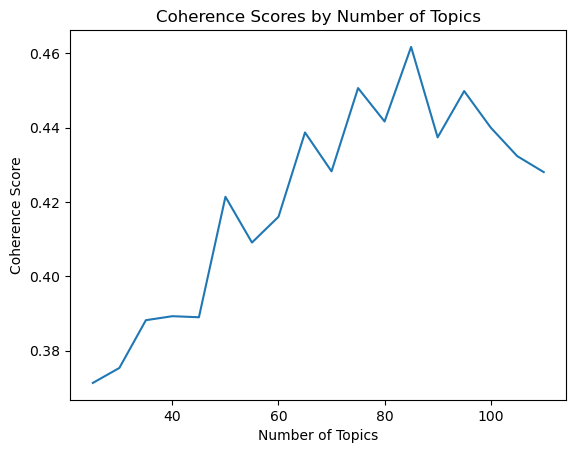

In [ ]:
documents = topic_modeling["Review_prepared"].reset_index(drop=True)

tokenized_documents = [doc.split() for doc in documents]

dictionary = Dictionary(tokenized_documents)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

topics_range = [i for i in range(25, 115, 5)]
coherence_scores = []

for n in tqdm(topics_range):
    model = BERTopic(nr_topics=n)
    model.fit(documents)

    topics = [words for _, words in model.get_topics().items() if len(words) > 0]
    topics_as_words = [[word for word, _ in topic] for topic in topics]

    coherence_model = CoherenceModel(
        topics=topics_as_words,
        texts=tokenized_documents,
        dictionary=dictionary,
        coherence="c_v"
    )
    coherence = coherence_model.get_coherence()
    coherence_scores.append(coherence)

plt.plot(topics_range, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores by Number of Topics")
plt.show()


In [14]:
topic_model = BERTopic(nr_topics=85)
docs = topic_modeling["Review_prepared"].reset_index(drop=True)
topics, probs = topic_model.fit_transform(docs)
topic_modeling_df = pd.DataFrame({'topic': topics, 'document': docs})

In [48]:
topic_model.get_topic_info().head(10)

Topic  Count                                Name  \
0     -1   4286         -1_food_good_place_ambience   
1      0    537          0_manager_even_asked_worst   
2      1    455   1_biryani_biriyani_chicken_mutton   
3      2    365             2_good_boy_bhehave_tast   
4      3    357  3_chinese_punjabi_indian_authentic   
5      4    323        4_buffet_lunch_starters_main   
6      5    236     5_cake_cakes_brownies_chocolate   
7      6    193        6_zomato_order_gold_delivery   
8      7    189     7_excellent_service_abs_bahadur   
9      8    150          8_chicken_wings_fish_fried   

                                      Representation  \
0  [food, good, place, ambience, service, chicken...   
1  [manager, even, asked, worst, table, service, ...   
2  [biryani, biriyani, chicken, mutton, ordered, ...   
3  [good, boy, bhehave, tast, straw, verry, lassi...   
4  [chinese, punjabi, indian, authentic, north, f...   
5  [buffet, lunch, starters, main, spread, course...   
6  [cake, cakes, brownies, chocolate, cupcakes, v...   
7  [zomato, order, gold, delivery, restaurant, de...   
8  [excellent, service, abs, bahadur, thanks, tha...   
9  [chicken, wings, fish, fried, dish, served, sa...   

                                 Representative_Docs  
0  [restaurant good serving food - quantity quali...  
1  [march 15th change rating 1 today worst servic...  
2  [good service excellent food chicken biryani m...  
3                                 [good, good, good]  
4  [nice place chinese decent music nice ambience...  
5  [went team lunch took buffet nice place great ...  
6  [serve delicious well presented cake tried man...  
7  [excellent service zomato, horrible first time...  
8  [excellent food excellent service providing na...  
9  [recently invited food tasting session marsala...

##### Plotting topics

In [15]:
topic_model.visualize_topics()

In the plot we can see that there seems to be groups of topics that are very different from each other, they are far away from each other. However it can also be seen that there are topics that englobe other topics, for example: topics 0 and 22. The biggest topic has size 537 and is represented by the words "manager, even, asked, worst, table". There is also a big blob of topics in the centre of the plot, where differently from the other blobs is not made of a big topic englobing others but is instead a lot of topics neighboring each other.

In [50]:
topic_model.visualize_documents(docs, embeddings=None)

Here we can see that documents in topic 2 and topic 25 for example are distributed very closed together and very separated from all the rest. Most topics are in a blob in the bottom left and despite being in a blob most topics are very well organized, we can draw frontiers between topics. 

In [51]:
topic_model.visualize_hierarchy()

Here we can see the hierarchy of the topics and see how close or far away the topics are from each other

In [53]:
topic_model.visualize_barchart(top_n_topics=12)

In this plot we can see the words that appear most in each topic and their percentage. So for example topic 10 has 4.4% of hangout, 3.95% of friends, 3.8% of music, 3.4% of place, 2.7% of great 

##### Approximated document-topic matrix generated by BERTopic. 

In [55]:
topic_distr, _ = topic_model.approximate_distribution(docs)
topic_distr.shape

(9955, 84)

In [56]:
topic_distr[2000]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.10056928, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.25838561, 0.        , 0.        , 0.21105628,
       0.        , 0.        , 0.21089493, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [57]:
topic_modeling["Review"][2000]

"I didn't go and eat at the Dhaba.\nI had ordered from here. The taste was amazing and te only issue was packaging of the order.\nA must have is Alu Parantha and lassi."

In [58]:
topic_model.visualize_distribution(topic_distr[2000])

After analyzing the topic assign to the review with index 2000, the one analyzed in the other models, we can see that Bert has a hard time classifying it, having 4 topics with almost the same probability , >20%. It is classified as part of topic 31 which has a name that is confusing and seems meaningless

In [ ]:
tokenized_documents = [doc.split() for doc in docs]  
dictionary = Dictionary(tokenized_documents)

# Extract topics as lists of words
topics = [words for _, words in topic_model.get_topics().items() if len(words) > 0]
topics_as_words = [[word for word, _ in topic] for topic in topics]

# Calculate coherence score
coherence_model = CoherenceModel(
        topics=topics_as_words,
        texts=tokenized_documents,
        dictionary=dictionary,
        coherence="c_v"
    )
coherence = coherence_model.get_coherence()
coherence

0.4384168191965498

The coherence score from the Bert model is lower than then score from LDA with Gensim which was unexpected as usually Bert is better

<font color='#BFD72F' size=4>6.5 Final Conclusions</font> <a class="anchor" id="P65"></a>
  
[Back to TOC](#toc)

Can the reviews be classified according to emergent topics? (e.g., can review j be made up of 0.5 topic “service; speed; sympathy”, and 
0.3 topic “ambiance; decoration; furniture”?)

Yes we can, such a thing can be see in the Bert model where is easier to see especially in the bar plot where we analyze the review on index 2000. Where we can see that this review in particular is composed by 5 different topics: 26% of topic 31, 22% of topic 76, 21% of topic 37, 21% of topic 34 and 10% of topic 22.

What do the emergent topic mean? (i.e., are they meaningful regarding the project’s  context?)

Emergent topics represent clusters of similar words and documents identified by the model based on their co-occurrence patterns. They reflect underlying themes or concepts within the data that were not pre-defined. In this specific case we can see some emergent topics like for example: delivery time (topic 62), ambient quality (topic 65) and delivery quality (topics 19, 33 and 59 for example) these were all topics from the Bert model as it is easier to see the topics, the number associated with the topics before are from the graph `Documents and Topics`

Can relevant insights be extracted from the topics?

From the topics gathered we can understand that `fast delivery` is a common topic across several models meaning that a lot of restaurants are fulfilling this customer need. `staff quality` is also a common topic and most reviews highlight bad experiences with the staff members and mangers.  `delivery quality` also a common topic however reviews under this topic are a bit more contradictory, there are reviews that praise the efficiency and speed while others criticize the deliveries, however there are more highlighting the speed of the deliveries. Another common topic was `food quality` which has most reviews criticizing the food and saying things like "worst food", "few quantity of food despite tasting good", "too expensive for the quantity and quality". These are just 4 of the many topics there are, they are impossible to analize all one by one as there are up to 100 topics in some models